# IMPORT LIBRARY

In [1]:
import faulthandler 
from pyspark.sql import SparkSession 
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType
from pyspark.sql.types import ArrayType, DoubleType, BooleanType, DateType, FloatType, TimestampType
from pyspark.sql.functions import col, array_contains, isnan, when, count
from pyspark.sql.functions import lit, concat_ws, concat, collect_list, udf
from pyspark.sql.functions import countDistinct
import plotly.express as px
from sklearn.preprocessing import RobustScaler
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

## spark 접속

In [2]:

spark = SparkSession.builder.master('local').appName('Python Spark SQL Practice').getOrCreate()

In [2]:

faulthandler.enable()   
spark = SparkSession.builder.master('local').appName("Python Spark SQL Practice").config("spark.driver.maxResultSize", "64g").getOrCreate()

# DATA LOAD

In [3]:
def search(dirname):
    filenames = os.listdir(dirname)
    file_list = []
    for filename in filenames:
        full_filename = os.path.join(dirname, filename)
        print(full_filename)
        file_list.append(full_filename)
    return file_list
data_path_list = search("D:/workspace/data/")

D:/workspace/data/2019-Dec.csv
D:/workspace/data/2019-Nov.csv
D:/workspace/data/2019-Oct.csv
D:/workspace/data/2020-Apr.csv
D:/workspace/data/2020-Feb.csv
D:/workspace/data/2020-Jan.csv
D:/workspace/data/2020-Mar.csv


## 스키마 타입

In [4]:
schema = StructType() \
      .add("event_time",TimestampType(),True) \
      .add("event_type",StringType(),True) \
      .add("product_id",StringType(),True) \
      .add("category_id",StringType(),True) \
      .add("category_code",StringType(),True) \
      .add("brand",StringType(),True) \
      .add("price",DoubleType(),True) \
      .add("user_id",StringType(),True) \
      .add("user_session",StringType(),True)

## data merge
    - 2019년 10월 ~ 2020년 4월

In [5]:
for i, x in enumerate(data_path_list):
    file_path = x
    df = spark.read.format("csv") \
      .option("header", True) \
      .option('delimiter', ',') \
      .schema(schema) \
      .load(file_path)
    if i == 0:
        merged_df = df
    else:
        merged_df = merged_df.union(df)

In [6]:
merged_df.show()

+-------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|         event_time|event_type|product_id|        category_id|       category_code|  brand|  price|  user_id|        user_session|
+-------------------+----------+----------+-------------------+--------------------+-------+-------+---------+--------------------+
|2019-12-01 09:00:00|      view|   1005105|2232732093077520756|construction.tool...|  apple|1302.48|556695836|ca5eefc5-11f9-450...|
|2019-12-01 09:00:00|      view|  22700068|2232732091643068746|                NULL|  force| 102.96|577702456|de33debe-c7bf-44e...|
|2019-12-01 09:00:01|      view|   2402273|2232732100769874463|appliances.person...|  bosch| 313.52|539453785|5ee185a7-0689-4a3...|
|2019-12-01 09:00:02|  purchase|  26400248|2053013553056579841|computers.periphe...|   NULL| 132.31|535135317|61792a26-672f-4e6...|
|2019-12-01 09:00:02|      view|  20100164|2232732110089618156|    apparel.t

## spark table 생성

In [7]:
merged_df.createOrReplaceTempView("ecommerce")

# 1. ACQUISITION(고객 유치) 

## 1) DAU (Daily Active User)

### DAU 쿼리

In [8]:
dau = spark.sql("""
SELECT DATE(event_time) AS event_date, COUNT(DISTINCT user_id) AS DAU
FROM ecommerce
GROUP BY event_date
ORDER BY event_date
""")

In [9]:
dau.show()

+----------+------+
|event_date|   DAU|
+----------+------+
|2019-10-01|138532|
|2019-10-02|191269|
|2019-10-03|171202|
|2019-10-04|204000|
|2019-10-05|195812|
|2019-10-06|194376|
|2019-10-07|189661|
|2019-10-08|216037|
|2019-10-09|216194|
|2019-10-10|203411|
|2019-10-11|233042|
|2019-10-12|209497|
|2019-10-13|225661|
|2019-10-14|209438|
|2019-10-15|227812|
|2019-10-16|232011|
|2019-10-17|211813|
|2019-10-18|224919|
|2019-10-19|220472|
|2019-10-20|230312|
+----------+------+
only showing top 20 rows



### DAU 그래프

## 2) MAU(Monthly Active User)

### MAU 쿼리

In [10]:
mau = spark.sql("""
SELECT DATE_FORMAT(event_time, 'yyyy-MM') AS event_month, COUNT(DISTINCT user_id) AS MAU
FROM ecommerce
GROUP BY event_month
ORDER BY event_month
""")

In [11]:
mau.show()

+-----------+-------+
|event_month|    MAU|
+-----------+-------+
|    2019-10|3003621|
|    2019-11|3690591|
|    2019-12|4568466|
|    2020-01|4387144|
|    2020-02|4241163|
|    2020-03|4116768|
|    2020-04|4493564|
|    2020-05| 125161|
+-----------+-------+



### MAU 그래프

# 2. ACTIVATION(활성화)

## 1) DT(Duration Time, 체류 시간)

### DT 쿼리

In [12]:
duration = spark.sql("""SELECT user_session, 
                                MONTH(MAX(event_time)) AS DURATION_MONTH,
                                DATE(MAX(event_time)) AS DURATION_DATE,
                               MAX(event_time) - MIN(event_time) AS duration
                  FROM ecommerce 
                  GROUP BY user_session
                     ORDER BY duration DESC
                     """)

In [9]:
duration = spark.sql('''WITH temp AS (SELECT user_session, 
                                MONTH(MAX(event_time)) AS DURATION_MONTH,
                                DATE(MAX(event_time)) AS DURATION_DATE,
                               MAX(event_time) - MIN(event_time) AS duration
                  FROM ecommerce 
                  GROUP BY user_session
                     ORDER BY duration DESC)
                     SELECT COUNT(*)
                     FROM temp
                     WHERE duration > 
                  '''
          )

In [38]:
duration_under_1day_v1 = spark.sql("""WITH session_time AS (
                                        SELECT user_session, 
                                                MAX(event_time) AS max_session_time,
                                                MIN(event_time) AS min_session_time
                                        FROM ecommerce 
                                        GROUP BY user_session 
                                    ), 

                                    duration AS (
                                        SELECT user_session, 
                                        (unix_timestamp(max_session_time) - unix_timestamp(min_session_time)) AS duration_seconds
                                        FROM session_time 
                                        ORDER BY duration_seconds 
                                    ),
                                
                                    paying_session AS (
                                        SELECT DISTINCT(user_session)
                                        FROM ecommerce
                                        WHERE event_type = 'purchase'
                                    )
                                
                     SELECT s.user_session, d.duration_seconds
                     FROM paying_session s LEFT JOIN duration d 
                                        ON s.user_session = d.user_session
                                        WHERE duration_seconds < 86400 

                     
                     """).toPandas()

Py4JJavaError: An error occurred while calling o324.collectToPython.
: java.lang.OutOfMemoryError: Java heap space


In [9]:
duration_under_1day_v1 = spark.sql("""WITH paying_sessions AS (
    SELECT DISTINCT user_session
    FROM ecommerce
    WHERE event_type = 'purchase'
), 

session_time AS (
    SELECT e.user_session, 
           MAX(e.event_time) AS max_session_time,
           MIN(e.event_time) AS min_session_time
    FROM ecommerce e
    JOIN paying_sessions p ON e.user_session = p.user_session
    GROUP BY e.user_session
)

SELECT s.user_session, 
       (UNIX_TIMESTAMP(s.max_session_time) - UNIX_TIMESTAMP(s.min_session_time)) AS duration_seconds
FROM session_time s
""").toPandas()

In [12]:
duration_under_1day_v1.describe()

duration_seconds
count      5.267605e+06
mean       6.246561e+02
std        2.153458e+03
min        0.000000e+00
25%        1.210000e+02
50%        2.510000e+02
75%        5.540000e+02
max        8.638500e+04

In [15]:
duration_under_1day_v2 = spark.sql("""WITH paying_sessions AS (
    SELECT DISTINCT user_session
    FROM ecommerce
    WHERE event_type = 'purchase'
), 

session_time AS (
    SELECT e.user_session, 
           MAX(e.event_time) AS max_session_time,
           MIN(e.event_time) AS min_session_time
    FROM ecommerce e
    JOIN paying_sessions p ON e.user_session = p.user_session
    GROUP BY e.user_session
)

SELECT s.user_session, 
       (UNIX_TIMESTAMP(s.max_session_time) - UNIX_TIMESTAMP(s.min_session_time)) AS duration_seconds
FROM session_time s
""").toPandas()

Py4JJavaError: An error occurred while calling o136.collectToPython.
: java.lang.OutOfMemoryError: Java heap space
	at scala.collection.mutable.ResizableArray.ensureSize(ResizableArray.scala:106)
	at scala.collection.mutable.ResizableArray.ensureSize$(ResizableArray.scala:96)
	at scala.collection.mutable.ArrayBuffer.ensureSize(ArrayBuffer.scala:49)
	at scala.collection.mutable.ArrayBuffer.$plus$eq(ArrayBuffer.scala:85)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$2(SparkPlan.scala:449)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$4054/0x000001f92a046d60.apply(Unknown Source)
	at scala.collection.Iterator.foreach(Iterator.scala:943)
	at scala.collection.Iterator.foreach$(Iterator.scala:943)
	at org.apache.spark.util.NextIterator.foreach(NextIterator.scala:21)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1(SparkPlan.scala:449)
	at org.apache.spark.sql.execution.SparkPlan.$anonfun$executeCollect$1$adapted(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.SparkPlan$$Lambda$4053/0x000001f92a046988.apply(Unknown Source)
	at scala.collection.IndexedSeqOptimized.foreach(IndexedSeqOptimized.scala:36)
	at scala.collection.IndexedSeqOptimized.foreach$(IndexedSeqOptimized.scala:33)
	at scala.collection.mutable.ArrayOps$ofRef.foreach(ArrayOps.scala:198)
	at org.apache.spark.sql.execution.SparkPlan.executeCollect(SparkPlan.scala:448)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.$anonfun$executeCollect$1(AdaptiveSparkPlanExec.scala:392)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec$$Lambda$3562/0x000001f929f2fbf0.apply(Unknown Source)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.withFinalPlanUpdate(AdaptiveSparkPlanExec.scala:420)
	at org.apache.spark.sql.execution.adaptive.AdaptiveSparkPlanExec.executeCollect(AdaptiveSparkPlanExec.scala:392)
	at org.apache.spark.sql.Dataset.$anonfun$collectToPython$1(Dataset.scala:4149)
	at org.apache.spark.sql.Dataset$$Lambda$3258/0x000001f929ec6350.apply(Unknown Source)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$2(Dataset.scala:4323)
	at org.apache.spark.sql.Dataset$$Lambda$1846/0x000001f929a720f8.apply(Unknown Source)
	at org.apache.spark.sql.execution.QueryExecution$.withInternalError(QueryExecution.scala:546)
	at org.apache.spark.sql.Dataset.$anonfun$withAction$1(Dataset.scala:4321)
	at org.apache.spark.sql.Dataset$$Lambda$1496/0x000001f92993ad20.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$6(SQLExecution.scala:125)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1507/0x000001f92993e4a8.apply(Unknown Source)
	at org.apache.spark.sql.execution.SQLExecution$.withSQLConfPropagated(SQLExecution.scala:201)
	at org.apache.spark.sql.execution.SQLExecution$.$anonfun$withNewExecutionId$1(SQLExecution.scala:108)
	at org.apache.spark.sql.execution.SQLExecution$$$Lambda$1497/0x000001f92993afe8.apply(Unknown Source)


In [ ]:
duration_under_1day_v2.describe()

In [14]:
total_session_num = spark.sql("""SELECT COUNT(DISTINCT user_session)
                              FROM ecommerce""").show()


+----------------------------+
|count(DISTINCT user_session)|
+----------------------------+
|                    89693594|
+----------------------------+



In [31]:
duration_under_1day = spark.sql("""WITH session_time AS (
                                        SELECT user_session, 
                                                MAX(event_time) AS max_session_time,
                                                MIN(event_time) AS min_session_time
                                        FROM ecommerce 
                                        GROUP BY user_session 
                                    ), 

                                    duration AS (
                                        SELECT user_session, 
                                        unix_timestamp(max_session_time - min_session_time) AS duration_seconds
                                        FROM session_time 
                                        ORDER BY duration_seconds 
                                    )
                     SELECT s.user_session, d.duration_seconds
                     FROM ecommerce s LEFT JOIN duration d 
                                        ON s.user_session = d.user_session
                                        WHERE event_type = 'purchase'
                                        AND duration_seconds < 86400 
                     """).toPandas()

Py4JJavaError: An error occurred while calling o292.collectToPython.
: java.lang.OutOfMemoryError: Java heap space


In [8]:
duration_under_1day_v2 = spark.sql("""SELECT user_session, 
                                                MAX(event_time) AS max_session_time,
                                                MIN(event_time) AS min_session_time,

                                                COUNT (CASE WHEN event_type='purchase' then 1 end) AS purchase_count
                                        FROM ecommerce 
                                        GROUP BY user_session 
                                        HAVING purchase_count > 0""").toPandas()

Py4JJavaError: An error occurred while calling o120.collectToPython.
: java.lang.OutOfMemoryError: Java heap space


In [ ]:
duration_under_1day

In [ ]:
from tqdm import tqdm

category_list = [['medicine'],
 ['computers'],
 ['auto'],
 ['stationery'],
 ['sport'],
 ['apparel'],
 ['appliances'],
 ['country_yard'],
 ['furniture'],
 ['accessories'],
 ['kids'],
 ['electronics'],
 ['construction'],
 [None]]

category_dataframes = []

for x in tqdm(category_list):
     purcahse_cycle_per_category = spark.sql(f"""
                                                WITH third AS(
                                                            WITH second AS(
                                                                        WITH first AS(
                                                                                    SELECT 
                                                                                          user_id,
                                                                                          event_time
                                                                                    FROM ecommerce
                                                                                    WHERE SUBSTRING_INDEX(category_code, '.', 1) = '{x[0]}'
                                                                                    AND event_type = 'purchase'
                                                                                    )
                                                                        SELECT 
                                                                              user_id,
                                                                              event_time AS order_date,
                                                                              LAG(event_time) OVER (
                                                                                                      PARTITION BY user_id 
                                                                                                      ORDER BY event_time) AS prev_order_date      
                                                                        FROM first
                                                                        GROUP BY user_id, event_time
                                                                        )
                                                            SELECT
                                                                        user_id,
                                                                        AVG(DATEDIFF(order_date, prev_order_date)) AS user_avg_purchase_cycle
                                                            FROM second
                                                            WHERE prev_order_date IS NOT NULL
                                                            GROUP BY user_id
                                                      )
                                                      SELECT 
                                                            AVG(user_avg_purchase_cycle) AS category_avg_purchase_cycle
                                                      FROM third
     """)
     pdf = purcahse_cycle_per_category.toPandas()
     pdf["category_code"] = x[0]
     category_dataframes.append(pdf)

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
df_frequency_purchase_per_category = pd.concat(category_dataframes, ignore_index=True)

In [ ]:
df_frequency_purchase_per_category

In [34]:
duration.show()

+--------------------+--------------+-------------+--------------------+
|        user_session|DURATION_MONTH|DURATION_DATE|            duration|
+--------------------+--------------+-------------+--------------------+
|1559d1e4-6114-4e2...|             5|   2020-05-01|INTERVAL '211 13:...|
|68e53f3c-17a2-4b8...|             4|   2020-04-30|INTERVAL '210 23:...|
|0c1c7ea1-3e79-47e...|             5|   2020-05-01|INTERVAL '210 21:...|
|994e6c91-0273-467...|             4|   2020-04-29|INTERVAL '210 16:...|
|9fa2aabd-0905-4fa...|             4|   2020-04-29|INTERVAL '210 16:...|
|455049a5-25ba-40a...|             4|   2020-04-30|INTERVAL '210 14:...|
|11f45d7a-2489-4e8...|             5|   2020-05-01|INTERVAL '210 09:...|
|35933c92-9f62-486...|             4|   2020-04-28|INTERVAL '209 18:...|
|e176e1a9-37bf-40a...|             4|   2020-04-29|INTERVAL '209 14:...|
|22484115-ac2f-497...|             5|   2020-05-01|INTERVAL '209 11:...|
|ef0d9aa2-a32c-465...|             4|   2020-04-27|

In [13]:
duration.toPandas()

user_session  DURATION_MONTH DURATION_DATE  \
0      1559d1e4-6114-4e2c-87cd-c09c81376fae               5    2020-05-01   
1      68e53f3c-17a2-4b8e-9e87-03adc7351213               4    2020-04-30   
2      0c1c7ea1-3e79-47e1-ab80-8fe055fe4b1c               5    2020-05-01   
3      994e6c91-0273-467d-bf87-a15d025bd484               4    2020-04-29   
4      9fa2aabd-0905-4faf-b6ae-4d33b9f63be0               4    2020-04-29   
...                                     ...             ...           ...   
99995  dae86eff-24c6-4c76-934f-d4e16e333b11               1    2020-01-31   
99996  619265d0-12b0-4267-9042-7c6cf42ccaf1               3    2020-03-07   
99997  c0db8577-5504-4bc5-a2f8-a2c01b703bcb               4    2020-04-29   
99998  6914a144-4ed8-4441-932a-c4795c883a14               2    2020-02-02   
99999  98cc8498-ff3d-4cb5-9eb4-c53c321a6d85               2    2020-02-02   

               duration  
0     211 days 13:24:27  
1     210 days 23:01:58  
2     210 days 21:49:43  
3     210 days 16:15:26  
4     210 days 16:00:54  
...                 ...  
99995  98 days 08:00:37  
99996  98 days 08:00:21  
99997  98 days 08:00:13  
99998  98 days 07:59:56  
99999  98 days 07:58:31  

[100000 rows x 4 columns]

## 2) 구매까지 걸리는 DT

### duration 테이블 만들기

In [14]:
duration.createOrReplaceTempView('duration_table')

### user_session 별로 view, purchase, cart의 수

In [15]:
pivot_session = spark.sql('''WITH source AS (
                                                SELECT user_session, event_type, COUNT(event_time) AS event_count
                                                FROM ecommerce
                                                GROUP BY user_session, event_type
                                                )
                            SELECT 
                                user_session,
                                SUM(CASE WHEN event_type = 'view' THEN event_count ELSE 0 END) AS view,
                                SUM(CASE WHEN event_type = 'cart' THEN event_count ELSE 0 END) AS cart,
                                SUM(CASE WHEN event_type = 'purchase' THEN event_count ELSE 0 END) AS purchase
                            FROM source
                            GROUP BY user_session
                            ORDER BY user_session
                        ''')

In [16]:
pivot_session.createOrReplaceTempView('session_pivot_table')

### 구매 이력이 있는 섹션의 DT

In [17]:
purchase_session_avg_duration = spark.sql('''
                                                SELECT MEAN(d.duration)
                                                FROM duration_table AS d, 
                                                    (SELECT user_session, purchase
                                                    FROM session_pivot_table
                                                    WHERE purchase > 0)   AS p
                                                WHERE d.user_session = p.user_session
                                        ''')

In [18]:
purchase_session_avg_duration.show()

+--------------------+
|      mean(duration)|
+--------------------+
|INTERVAL '2 01:41...|
+--------------------+



## 3) 월간 DT

### 월간 DT 쿼리

In [15]:
duration_month = spark.sql("""
WITH temp AS (
    SELECT user_session, 
    MONTH(MAX(event_time)) AS DURATION_MONTH,
    DATE(MAX(event_time)) AS DURATION_DATE,
    MAX(event_time) - MIN(event_time) AS duration
    FROM ecommerce 
    GROUP BY user_session
)
SELECT DURATION_DATE, AVG(duration) AS AVG_DURATION
FROM temp
GROUP BY DURATION_DATE
ORDER BY DURATION_DATE
""")

In [16]:
duration_month.show()

+-------------+--------------------+
|DURATION_DATE|        AVG_DURATION|
+-------------+--------------------+
|   2019-10-01|INTERVAL '0 00:04...|
|   2019-10-02|INTERVAL '0 00:07...|
|   2019-10-03|INTERVAL '0 00:10...|
|   2019-10-04|INTERVAL '0 00:10...|
|   2019-10-05|INTERVAL '0 00:11...|
|   2019-10-06|INTERVAL '0 00:13...|
|   2019-10-07|INTERVAL '0 00:14...|
|   2019-10-08|INTERVAL '0 00:15...|
|   2019-10-09|INTERVAL '0 00:14...|
|   2019-10-10|INTERVAL '0 00:15...|
|   2019-10-11|INTERVAL '0 00:14...|
|   2019-10-12|INTERVAL '0 00:16...|
|   2019-10-13|INTERVAL '0 00:15...|
|   2019-10-14|INTERVAL '0 00:16...|
|   2019-10-15|INTERVAL '0 00:15...|
|   2019-10-16|INTERVAL '0 00:15...|
|   2019-10-17|INTERVAL '0 00:15...|
|   2019-10-18|INTERVAL '0 00:14...|
|   2019-10-19|INTERVAL '0 00:13...|
|   2019-10-20|INTERVAL '0 00:13...|
+-------------+--------------------+
only showing top 20 rows



## 4) FUNNEL (EVENT_TYPE 별 COUNT)

### FUNNEL 쿼리

In [17]:
funnel = spark.sql("""
                   SELECT 
                        event_type, COUNT(*) AS CNT
                   FROM 
                        ecommerce
                   GROUP BY 
                        event_type
                   ORDER BY
                        CNT DESC
""")

In [22]:
funnel.show()

+----------+---------+
|event_type|      CNT|
+----------+---------+
|      view|385746849|
|      cart| 19114063|
|  purchase|  6848824|
+----------+---------+



In [18]:
df_funnel = funnel.toPandas()

In [19]:
df_funnel

event_type        CNT
0       view  385746849
1       cart   19114063
2   purchase    6848824

### FUNNEL 그래프

In [25]:
fig = px.funnel(data_frame= df_funnel, x = 'event_type', y = 'CNT')
fig.update_traces(texttemplate= '%{value:,.0f}') # 숫자 형식 지정
fig.show()

- 구매 전환율 : 1.78%
    - 한국 평균 : 1.3%
    - 쿠팡 : 7 ~ 8%

2022년 글로벌 평균 구매전환율은 1.3% 입니다.

구매 전환율이 3.2%보다 높으면 상위 20%에 속한다고 합니다.

4.8%보다 높으면 전 세계 상위 10%에 속한다고 합니다.

0.2%보다 낮으면 조금 심각한 문제라고 합니다. 이런 경우 트래킹/분석 툴을 통해 무엇이 문제인지 확인해야 합니다.

글로벌 장바구니에 넣는 비율은 방문자의 14.5%라고 합니다.

In [37]:
purchase_ratio = spark.sql("""
                            WITH cart_users AS (
                                SELECT DISTINCT user_id, product_id
                                FROM ecommerce
                                WHERE event_type = 'cart'
                            ),

                            purchase_users AS (
                                SELECT DISTINCT user_id, product_id
                                FROM ecommerce
                                WHERE event_type = 'purchase'
                            ),

                            cart_only_users AS (
                                SELECT user_id FROM cart_users
                                EXCEPT 
                                SELECT user_id FROM purchase_users
                            )

                            SELECT (COUNT(DISTINCT p.user_id) * 1.0 / COUNT(DISTINCT c.user_id)) AS purchase_rate
                            FROM cart_users c LEFT JOIN purchase_users p
                            ON c.user_id = p.user_id
""").toPandas()

In [41]:
purchase_ratio

purchase_rate
0  0.5512679318927007

In [267]:
sub_category_df = spark.sql("""SELECT DISTINCT (SUBSTRING_INDEX(category_code, '.', 2)) AS cnt 
          FROM ecommerce""").toPandas()

In [14]:
main_category_df = spark.sql("""SELECT DISTINCT (SUBSTRING_INDEX(category_code, '.', 1)) AS cnt 
          FROM ecommerce""").toPandas()

In [273]:
sub_category_df.values.tolist()

[['electronics.camera'],
 ['computers.ebooks'],
 ['furniture.bathroom'],
 ['country_yard.furniture'],
 ['sport.snowboard'],
 ['apparel.shirt'],
 ['electronics.tablet'],
 ['apparel.jeans'],
 ['electronics.audio'],
 ['stationery.cartrige'],
 ['electronics.telephone'],
 ['apparel.pajamas'],
 ['apparel.skirt'],
 ['apparel.jacket'],
 ['apparel.dress'],
 ['accessories.bag'],
 ['sport.bicycle'],
 ['kids.skates'],
 ['apparel.underwear'],
 ['apparel.scarf'],
 ['sport.ski'],
 ['country_yard.lawn_mower'],
 ['construction.components'],
 ['sport.trainer'],
 ['electronics.clocks'],
 ['furniture.living_room'],
 ['apparel.tshirt'],
 ['kids.fmcg'],
 ['electronics.smartphone'],
 ['furniture.kitchen'],
 ['furniture.universal'],
 ['apparel.trousers'],
 ['furniture.bedroom'],
 ['kids.carriage'],
 ['sport.diving'],
 ['construction.tools'],
 ['computers.peripherals'],
 ['appliances.kitchen'],
 ['medicine.tools'],
 ['computers.notebook'],
 ['electronics.video'],
 ['kids.swing'],
 ['accessories.wallet'],
 ['ap

In [13]:
category_list = main_category_df.values.tolist()

NameError: name 'main_category_df' is not defined

In [47]:
category_list

[['medicine'],
 ['computers'],
 ['auto'],
 ['stationery'],
 ['sport'],
 ['apparel'],
 ['appliances'],
 ['country_yard'],
 ['furniture'],
 ['accessories'],
 ['kids'],
 ['electronics'],
 ['construction'],
 [None]]

In [44]:
from tqdm import tqdm

In [52]:
category_dataframes = []
for x in tqdm(category_list):
     funnel_per_category = spark.sql(f"""
                    SELECT 
                         event_type, COUNT(*) AS CNT
                    FROM 
                         ecommerce
                    WHERE
                         SUBSTRING_INDEX(category_code, '.', 1) = '{x[0]}'
                         
                    GROUP BY 
                         event_type
                                   
                    ORDER BY
                         CNT DESC
                         
                    
     """)
     pdf = funnel_per_category.toPandas()
     pdf["category_code"] = x[0]
     category_dataframes.append(pdf)


  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
df_funnel_per_category = pd.concat(category_dataframes, ignore_index=True)

In [ ]:
df_funnel_per_category

In [16]:
day_of_week_funnel = spark.sql('''SELECT event_type, COUNT(event_type) AS count, DAYOFWEEK(event_time) AS day 
                   FROM ecommerce 
                   GROUP BY event_type , DAYOFWEEK(event_time)
                   ORDER BY day DESC, DECODE(event_type, 'view', 1, 'cart',2,3) ''')

In [17]:
day_of_week_funnel.toPandas()

event_type     count  day
0        view  56435853    7
1        cart   2930652    7
2    purchase    980182    7
3        view  55320186    6
4        cart   3038973    6
5    purchase    942724    6
6        view  53474149    5
7        cart   2491246    5
8    purchase    956283    5
9        view  53975675    4
10       cart   2519734    4
11   purchase    963658    4
12       view  53900850    3
13       cart   2543171    3
14   purchase    936772    3
15       view  54502591    2
16       cart   2711069    2
17   purchase   1013977    2
18       view  58137545    1
19       cart   2879218    1
20   purchase   1055228    1

# 3. RETENTION(리텐션)

## 1) Monthly Retention
    - 접속 했는지 여부

### 월간 리텐션 쿼리

In [26]:
retention_range_30 = spark.sql("""
                               WITH first as (
                                    SELECT user_id, MIN(event_time) AS first_interaction_time
                                    FROM ecommerce
                                    GROUP BY user_id
                                )

                                SELECT MONTH(first_interaction_time) AS MONTH, FLOOR(MONTHS_BETWEEN(event_time, first_interaction_time)) AS diff_month,
                                COUNT(DISTINCT s.user_id) as user_cnt
                                FROM ecommerce s LEFT JOIN first f
                                ON s.user_id = f.user_id
                                GROUP BY MONTH, FLOOR(MONTHS_BETWEEN(event_time, first_interaction_time))
                                ORDER BY diff_month

                          """)


In [27]:
retention_range_30.show()

+-----+----------+--------+
|MONTH|diff_month|user_cnt|
+-----+----------+--------+
|   11|         0| 2294808|
|    1|         0| 2152155|
|    4|         0| 2100242|
|   12|         0| 2534092|
|   10|         0| 3003621|
|    3|         0| 1692773|
|    2|         0| 1841332|
|    5|         0|   20780|
|   12|         1|  546728|
|    3|         1|  221144|
|   10|         1| 1274245|
|    4|         1|     353|
|    1|         1|  414526|
|    2|         1|  283300|
|   11|         1|  722024|
|   12|         2|  451912|
|   11|         2|  570435|
|    2|         2|  191446|
|    3|         2|     240|
|   10|         2| 1141914|
+-----+----------+--------+
only showing top 20 rows



### pandas, pivot 전환

In [28]:
df_retention_30 = retention_range_30.toPandas()

In [29]:
df_retention_30_pivot = df_retention_30.pivot(index='MONTH',columns='diff_month',values='user_cnt').reindex([10,11,12,1,2,3,4])

In [30]:
df_retention_30_pivot

diff_month          0          1          2         3         4         5  \
MONTH                                                                       
10          3003621.0  1274245.0  1141914.0  952834.0  853271.0  720473.0   
11          2294808.0   722024.0   570435.0  501031.0  399245.0  291355.0   
12          2534092.0   546728.0   451912.0  336531.0  214911.0     313.0   
1           2152155.0   414526.0   285484.0  191246.0     245.0       NaN   
2           1841332.0   283300.0   191446.0     314.0       NaN       NaN   
3           1692773.0   221144.0      240.0       NaN       NaN       NaN   
4           2100242.0      353.0        NaN       NaN       NaN       NaN   

diff_month         6       7  
MONTH                         
10          546060.0  2378.0  
11             471.0     NaN  
12               NaN     NaN  
1                NaN     NaN  
2                NaN     NaN  
3                NaN     NaN  
4                NaN     NaN

### value 비율로 변환

In [31]:
for i in range(len(df_retention_30_pivot)):
    a = df_retention_30_pivot.iloc[i,0]
    for j in range(len(df_retention_30_pivot.columns)):
        if df_retention_30_pivot.isnull().iloc[i,j]:
            pass
        else:
            df_retention_30_pivot.iloc[i,j] = round(df_retention_30_pivot.iloc[i,j] / a, 4)


In [32]:
df_retention_30_pivot.to_csv("월간리텐션.csv", index=False)

### 월간 리텐션 그래프

<Axes: xlabel='diff_month', ylabel='MONTH'>

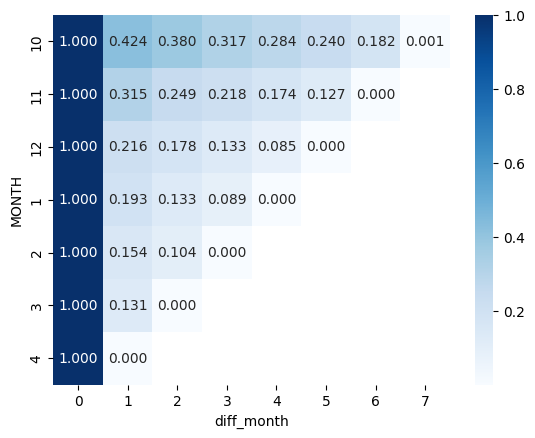

In [47]:

sns.heatmap(df_retention_30_pivot, annot=True, fmt=".3f", cmap = 'Blues')

[문제를 찾자]
전반적으로 10, 11월 retention 좋음

1~3월 폭망

그 이유는 무엇일까???

Q1.전체적인 건수가 줄어서???
그럼 왜 줄어 들었을까????

단순히 연초라서????
Q2.연말에 폭풍 소비 후 연초에 살 필요성이 없음????

아니면 제품군?????
EX. 컴퓨터나 장기간 사용할 물건을 구매해서 다시 들어갈 일이 생기지 않았나???
=> 블랙프레이데이를 이용해서 저런 것들을 구매 후 재방문으로는 이어지지 않았나???




### 구매일 기준

In [157]:
retention_range_30_purchase = spark.sql("""
                               WITH first as (
                                    SELECT user_id, MIN(event_time) AS first_interaction_time
                                    FROM ecommerce
                                    WHERE event_type = 'purchase'
                                    GROUP BY user_id
                                )

                                SELECT MONTH(first_interaction_time) AS MONTH, FLOOR(MONTHS_BETWEEN(event_time, first_interaction_time)) AS diff_month,
                                COUNT(DISTINCT s.user_id) as user_cnt
                                FROM ecommerce s LEFT JOIN first f
                                ON s.user_id = f.user_id
                                WHERE event_type = 'purchase'
                                GROUP BY MONTH, FLOOR(MONTHS_BETWEEN(event_time, first_interaction_time))
                                ORDER BY diff_month

                          """)


In [ ]:
retention_range_30_purchase.show()

In [158]:
df_retention_30_purchase = retention_range_30_purchase.toPandas()
# 63m23.6s

In [159]:
df_retention_30_purchase_pivot = df_retention_30_purchase.pivot(index='MONTH',columns='diff_month',values='user_cnt').reindex([10,11,12,1,2,3,4])

In [160]:
df_retention_30_purchase_pivot

diff_month         0        1        2        3        4        5        6  \
MONTH                                                                        
10          345250.0  78054.0  66010.0  48553.0  44251.0  33581.0  17080.0   
11          350019.0  61983.0  44714.0  40565.0  29616.0  15767.0     10.0   
12          348605.0  48820.0  43524.0  31136.0  14422.0     17.0      NaN   
1           214768.0  31941.0  21704.0   9746.0      4.0      NaN      NaN   
2           225547.0  28325.0  13912.0     19.0      NaN      NaN      NaN   
3           258636.0  20309.0      9.0      NaN      NaN      NaN      NaN   
4           319123.0     27.0      NaN      NaN      NaN      NaN      NaN   

diff_month     7  
MONTH             
10          21.0  
11           NaN  
12           NaN  
1            NaN  
2            NaN  
3            NaN  
4            NaN

In [161]:
for i in range(len(df_retention_30_purchase_pivot)):
    a = df_retention_30_purchase_pivot.iloc[i,0]
    for j in range(len(df_retention_30_purchase_pivot.columns)):
        if df_retention_30_purchase_pivot.isnull().iloc[i,j]:
            pass
        else:
            df_retention_30_purchase_pivot.iloc[i,j] = round(df_retention_30_purchase_pivot.iloc[i,j] / a, 4)


<Axes: xlabel='diff_month', ylabel='MONTH'>

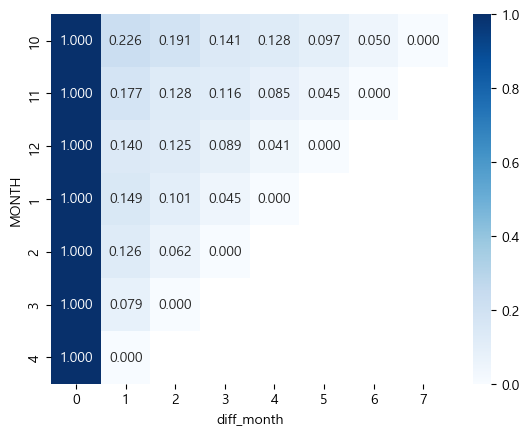

In [162]:

sns.heatmap(df_retention_30_purchase_pivot, annot=True, fmt=".3f", cmap = 'Blues')

In [109]:
df_retention_30_purchase_pivot.to_csv("월간리텐션_구매일기준.csv")

## 2) Weekly Retention

### 주간 리텐션 쿼리

In [23]:
retention_range_7 = spark.sql("""
                               WITH first as (
                                    SELECT user_id, MIN(event_time) AS first_interaction_time
                                    FROM ecommerce
                                    GROUP BY user_id
                                )
                                SELECT DATE(DATE_TRUNC('week',first_interaction_time)) AS WEEK, 
                                CAST(DATEDIFF(s.event_time, f.first_interaction_time) / 7 AS INT) AS diff_week,
                                COUNT(DISTINCT s.user_id) as user_cnt
                                FROM ecommerce s LEFT JOIN first f
                                ON s.user_id = f.user_id
                                GROUP BY WEEK, diff_week
                                ORDER BY diff_week

                          """)


In [35]:
retention_range_7.show()

+----------+---------+--------+
|      WEEK|diff_week|user_cnt|
+----------+---------+--------+
|2019-12-23|        0|  663936|
|2020-01-13|        0|  513541|
|2020-02-17|        0|  541865|
|2019-09-30|        0|  818388|
|2020-02-24|        0|  383602|
|2020-03-23|        0|  261293|
|2020-03-16|        0|  263913|
|2020-01-06|        0|  490528|
|2019-12-30|        0|  614861|
|2020-03-30|        0|  305555|
|2020-04-20|        0|  566769|
|2019-11-25|        0|  437714|
|2019-10-14|        0|  617645|
|2020-04-06|        0|  421139|
|2019-11-18|        0|  551204|
|2019-12-09|        0|  517199|
|2020-01-20|        0|  461124|
|2020-04-13|        0|  569921|
|2019-12-16|        0|  637462|
|2020-02-10|        0|  484614|
+----------+---------+--------+
only showing top 20 rows



### pandas, pivot 전환

In [24]:
df_retention_7 = retention_range_7.toPandas()

In [25]:
df_retention_7.sort_values(by=['WEEK','diff_week'])

WEEK  diff_week  user_cnt
4    2019-09-30          0    818388
34   2019-09-30          1    277762
79   2019-09-30          2    249026
105  2019-09-30          3    217328
132  2019-09-30          4    237233
..          ...        ...       ...
51   2020-04-13          1     88037
72   2020-04-13          2     23189
10   2020-04-20          0    566769
43   2020-04-20          1     25032
20   2020-04-27          0    329410

[496 rows x 3 columns]

In [27]:
df_retention_7_pivot = df_retention_7.pivot(index='WEEK',columns='diff_week',values='user_cnt')

In [28]:
df_retention_7_pivot

diff_week         0         1         2         3         4         5   \
WEEK                                                                     
2019-09-30  818388.0  277762.0  249026.0  217328.0  237233.0  237564.0   
2019-10-07  762779.0  189777.0  158667.0  170302.0  177742.0  191278.0   
2019-10-14  617645.0  121323.0  122805.0  127420.0  138418.0   97092.0   
2019-10-21  552380.0  100164.0   99091.0  103100.0   75901.0   71711.0   
2019-10-28  462835.0   91026.0   89511.0   63843.0   61109.0   58487.0   
2019-11-04  564746.0  124909.0   83590.0   77329.0   74211.0   81056.0   
2019-11-11  592037.0  102670.0   90169.0   82371.0   94816.0   93315.0   
2019-11-18  551204.0   76492.0   67458.0   69977.0   72175.0   64730.0   
2019-11-25  437714.0   66363.0   63482.0   61671.0   54092.0   44019.0   
2019-12-02  420888.0   69569.0   63035.0   52560.0   43931.0   38909.0   
2019-12-09  517199.0   80627.0   65260.0   52545.0   46206.0   45810.0   
2019-12-16  637462.0   95003.0   71299.0   59772.0   60910.0   50468.0   
2019-12-23  663936.0   81939.0   63649.0   62084.0   51109.0   48616.0   
2019-12-30  614861.0   70492.0   62267.0   49710.0   46036.0   40291.0   
2020-01-06  490528.0   63161.0   47347.0   42658.0   39541.0   40874.0   
2020-01-13  513541.0   60949.0   49793.0   45394.0   48029.0   40147.0   
2020-01-20  461124.0   56717.0   45221.0   45476.0   39762.0   34565.0   
2020-01-27  455423.0   54091.0   50707.0   42432.0   37959.0   40344.0   
2020-02-03  344553.0   49329.0   37686.0   33560.0   35485.0   23080.0   
2020-02-10  484614.0   61138.0   50815.0   52043.0   30560.0   22699.0   
2020-02-17  541865.0   65517.0   65509.0   37199.0   25711.0   23474.0   
2020-02-24  383602.0   54776.0   31054.0   19925.0   18142.0   18464.0   
2020-03-02  571024.0   53319.0   33584.0   29649.0   30453.0   35663.0   
2020-03-09  461455.0   33831.0   27597.0   25777.0   29407.0   31329.0   
2020-03-16  263913.0   28372.0   23818.0   24767.0   24608.0   22730.0   
2020-03-23  261293.0   30199.0   29067.0   28318.0   25288.0    7658.0   
2020-03-30  305555.0   41899.0   37543.0   32729.0    8521.0       NaN   
2020-04-06  421139.0   63781.0   52333.0   12742.0       NaN       NaN   
2020-04-13  569921.0   88037.0   23189.0       NaN       NaN       NaN   
2020-04-20  566769.0   25032.0       NaN       NaN       NaN       NaN   
2020-04-27  329410.0       NaN       NaN       NaN       NaN       NaN   

diff_week         6         7         8         9   ...        21        22  \
WEEK                                                ...                       
2019-09-30  254368.0  189930.0  189973.0  182434.0  ...  129174.0  144455.0   
2019-10-07  139484.0  137583.0  132855.0  149478.0  ...  108647.0   81747.0   
2019-10-14   95831.0   92950.0  105064.0  111131.0  ...   55967.0   48729.0   
2019-10-21   68842.0   78667.0   84997.0   75264.0  ...   34923.0   33922.0   
2019-10-28   66737.0   69131.0   61277.0   51279.0  ...   28532.0   29863.0   
2019-11-04   86185.0   74464.0   62020.0   57031.0  ...   35716.0   41833.0   
2019-11-11   80111.0   64344.0   61188.0   64710.0  ...   46411.0   50524.0   
2019-11-18   52953.0   47623.0   50400.0   44158.0  ...   32384.0   32671.0   
2019-11-25   39915.0   40491.0   36213.0   36987.0  ...   27940.0    8283.0   
2019-12-02   38484.0   34364.0   35333.0   34585.0  ...    8070.0       NaN   
2019-12-09   38819.0   38007.0   37360.0   41287.0  ...       NaN       NaN   
2019-12-16   49298.0   46329.0   52067.0   45723.0  ...       NaN       NaN   
2019-12-23   44466.0   51322.0   47483.0   42646.0  ...       NaN       NaN   
2019-12-30   45230.0   41131.0   37269.0   44799.0  ...       NaN       NaN   
2020-01-06   35671.0   33644.0   38034.0   24434.0  ...       NaN       NaN   
2020-01-13   37676.0   41906.0   25940.0   20062.0  ...       NaN       NaN   
2020-01-20   38963.0   26149.0   19512.0   18535.0  ...       NaN       NaN   
2020-01-27   25557.0   19672.0   18778.0   19754.0  ... 

### value 비율로 전환

In [29]:
for i in range(len(df_retention_7_pivot)):
    a = df_retention_7_pivot.iloc[i,0]
    for j in range(len(df_retention_7_pivot.columns)):
        if df_retention_7_pivot.isnull().iloc[i,j]:
            pass
        else:
            df_retention_7_pivot.iloc[i,j] = round(df_retention_7_pivot.iloc[i,j] / a, 4)


In [41]:
df_retention_7_pivot.to_csv("주간리텐션.csv", index=False)

### 주간 리텐션 그래프

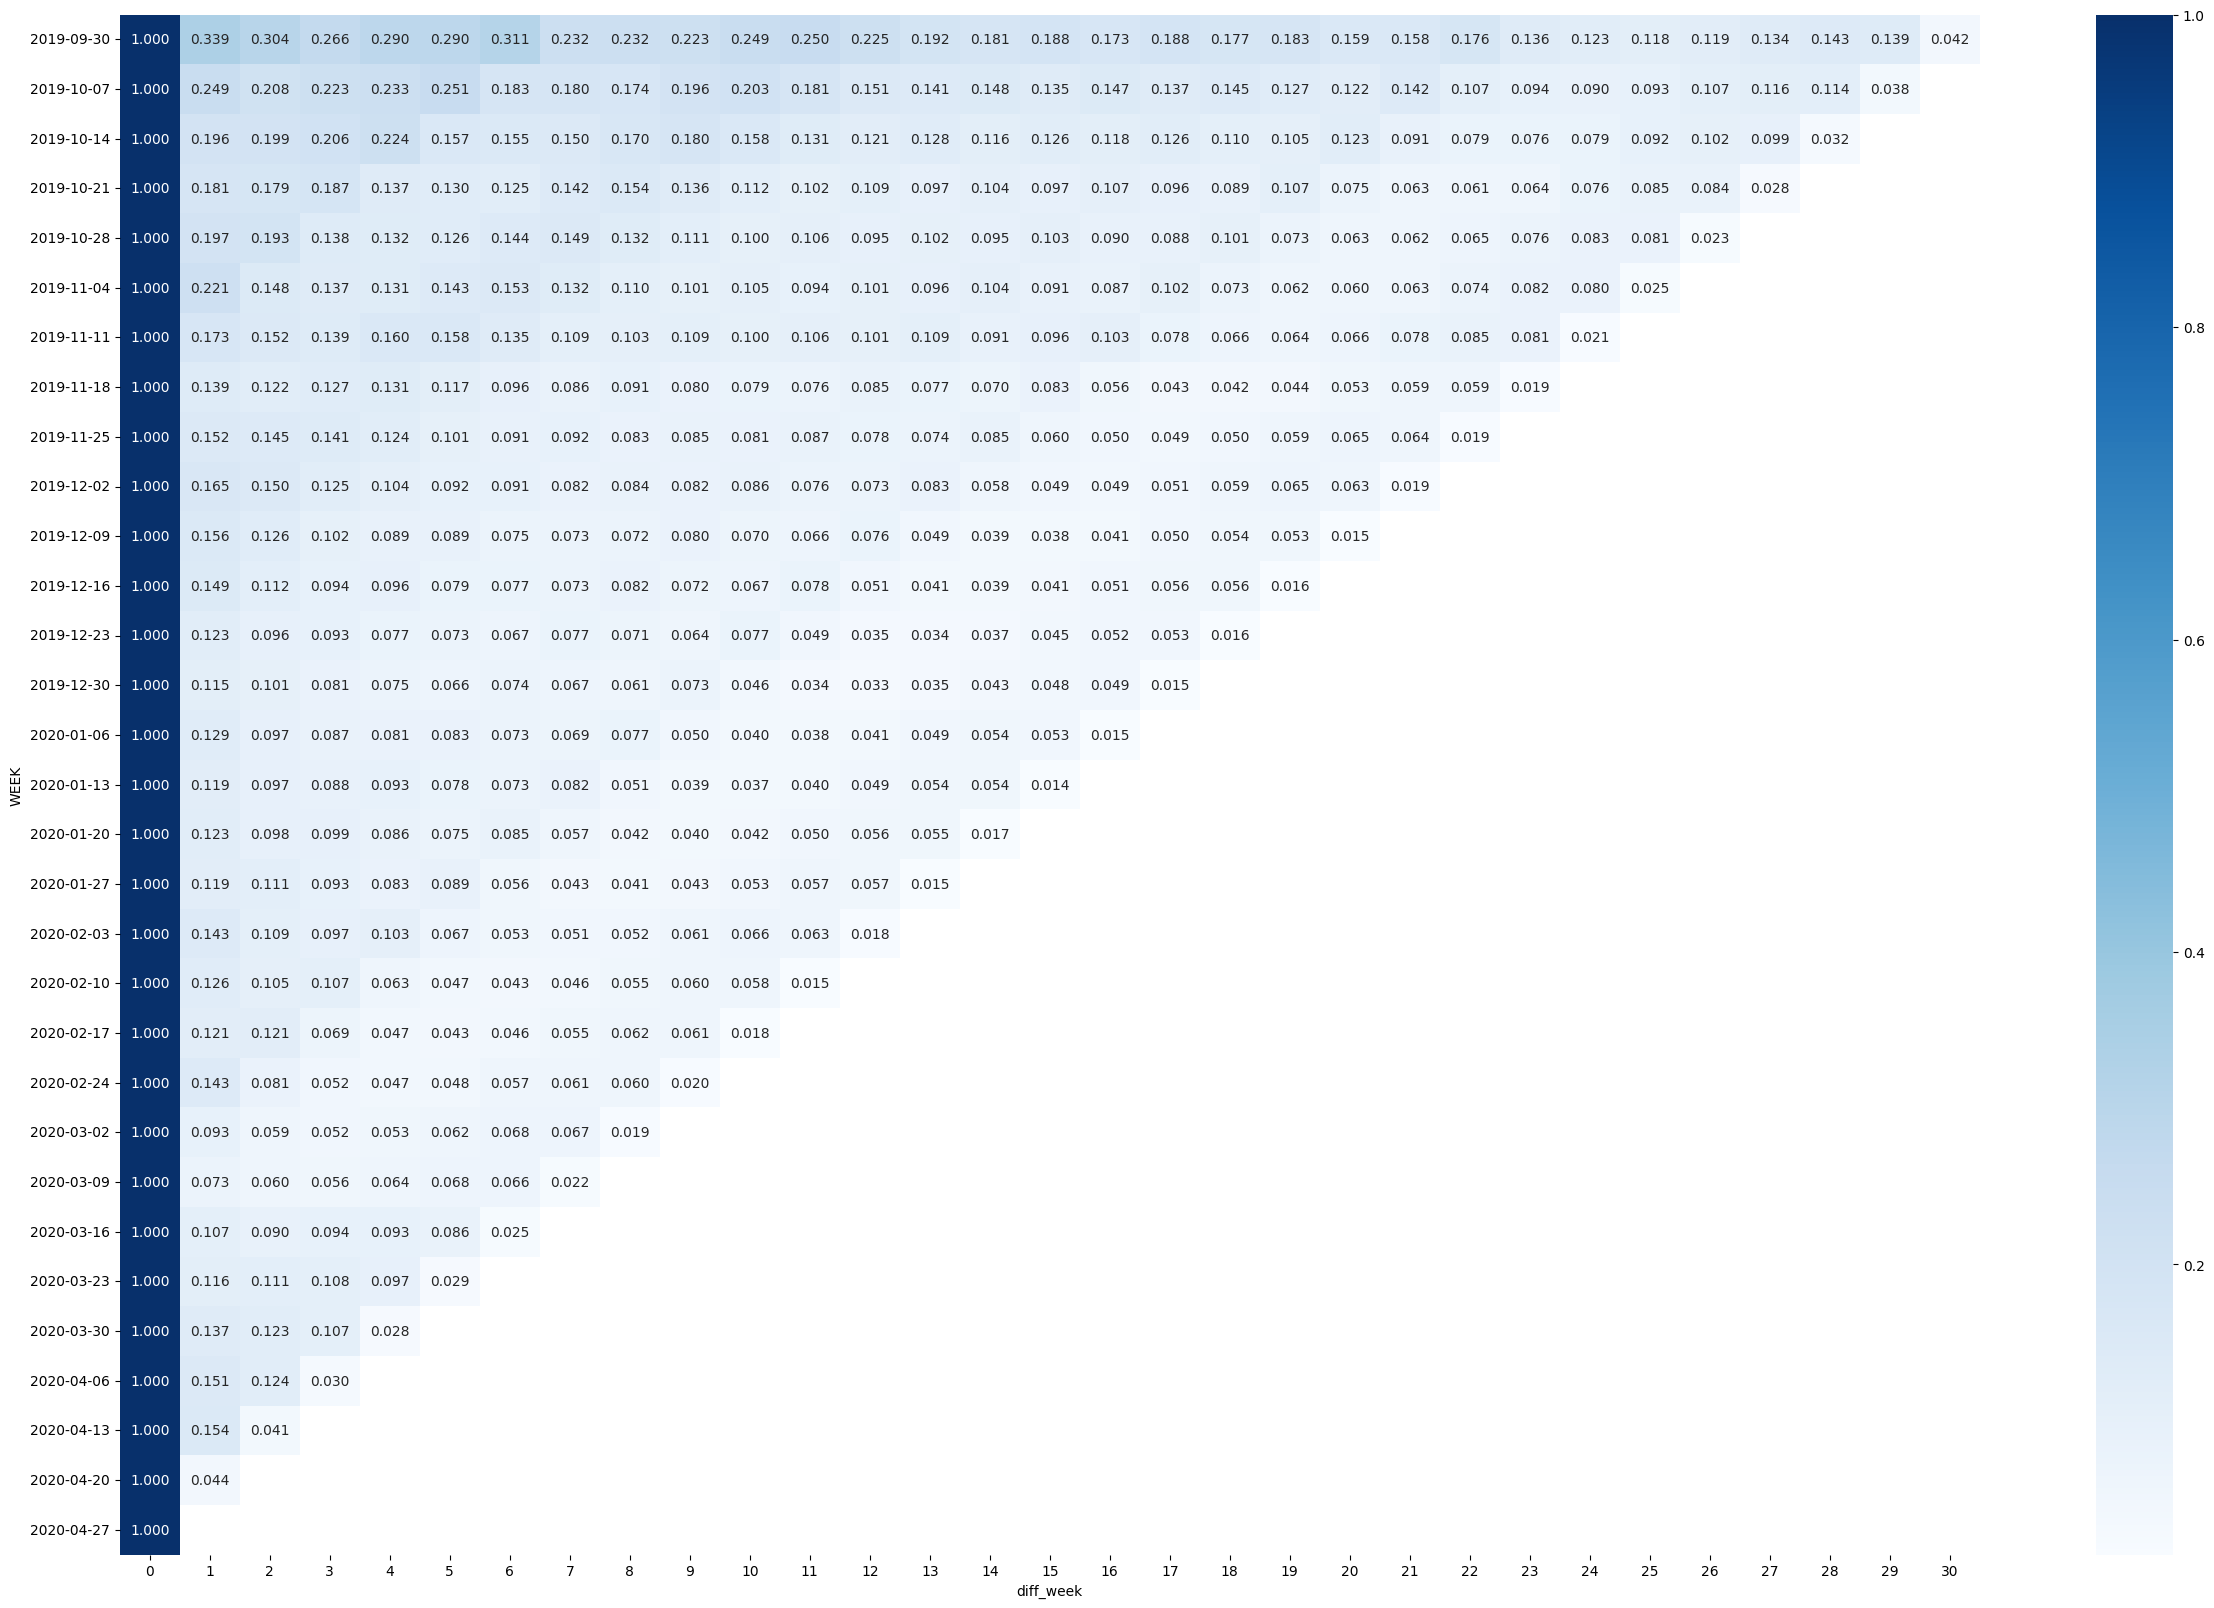

In [30]:
plt.figure(figsize=(30, 20))
sns.heatmap(df_retention_7_pivot, annot=True, fmt=".3f", cmap="Blues")
plt.show()

### 구매일 기준

In [149]:
retention_range_7_purchase = spark.sql("""
                               WITH first as (
                                    SELECT user_id, MIN(event_time) AS first_interaction_time
                                    FROM ecommerce
                                    WHERE event_type = 'purchase'
                                    GROUP BY user_id
                                )
                                SELECT DATE(DATE_TRUNC('week',first_interaction_time)) AS WEEK, 
                                CAST(DATEDIFF(s.event_time, f.first_interaction_time) / 7 AS INT) AS diff_week,
                                COUNT(DISTINCT s.user_id) as user_cnt
                                FROM ecommerce s LEFT JOIN first f
                                ON s.user_id = f.user_id
                                WHERE event_type = 'purchase'
                                GROUP BY WEEK, diff_week
                                ORDER BY diff_week

                          """)


In [150]:
df_retention_range_7_purchase = retention_range_7_purchase.toPandas()
#54m38.7s

In [151]:
df_retention_range_7_purchase.sort_values(by=['WEEK','diff_week'])

WEEK  diff_week  user_cnt
4    2019-09-30          0     76016
34   2019-09-30          1     14462
79   2019-09-30          2     11647
105  2019-09-30          3      9331
132  2019-09-30          4      8929
..          ...        ...       ...
51   2020-04-13          1      8426
72   2020-04-13          2      1882
10   2020-04-20          0     70797
43   2020-04-20          1      1236
20   2020-04-27          0     54584

[496 rows x 3 columns]

In [152]:
df_retention_range_7_purchase_pivot = df_retention_range_7_purchase.pivot(index='WEEK',columns='diff_week',values='user_cnt')

In [153]:
df_retention_range_7_purchase_pivot

diff_week         0        1        2       3        4       5        6   \
WEEK                                                                       
2019-09-30   76016.0  14462.0  11647.0  9331.0   8929.0  7925.0  10252.0   
2019-10-07   84825.0  11149.0   8291.0  7834.0   7112.0  9793.0   5878.0   
2019-10-14   81661.0   8814.0   7470.0  6643.0   9210.0  5429.0   5286.0   
2019-10-21   70200.0   6650.0   5631.0  7587.0   4380.0  4230.0   3896.0   
2019-10-28   59002.0   5602.0   6533.0  3830.0   3801.0  3438.0   4250.0   
2019-11-04   68016.0   8460.0   4821.0  4552.0   4149.0  4925.0   5385.0   
2019-11-11  131239.0   8154.0   7302.0  6140.0  10008.0  9312.0   6745.0   
2019-11-18   72987.0   6443.0   5045.0  5387.0   6215.0  4881.0   3046.0   
2019-11-25   61007.0   5743.0   5771.0  5583.0   4349.0  2814.0   2873.0   
2019-12-02   56666.0   6456.0   5882.0  4388.0   2899.0  2766.0   2902.0   
2019-12-09   56918.0   7016.0   4702.0  3046.0   3044.0  3074.0   2548.0   
2019-12-16  102121.0  10212.0   5478.0  5067.0   5320.0  4473.0   4528.0   
2019-12-23   93431.0   5854.0   5202.0  4998.0   4270.0  4111.0   3951.0   
2019-12-30   52200.0   4117.0   3421.0  2762.0   2678.0  2314.0   2576.0   
2020-01-06   51478.0   5003.0   3668.0  3285.0   2915.0  2983.0   2270.0   
2020-01-13   53281.0   4758.0   3996.0  3507.0   3441.0  2706.0   2882.0   
2020-01-20   52559.0   5077.0   3843.0  3737.0   2940.0  3002.0   3120.0   
2020-01-27   51868.0   5078.0   4391.0  3176.0   3392.0  3321.0   2483.0   
2020-02-03   47962.0   4994.0   3309.0  3284.0   3334.0  2449.0   1763.0   
2020-02-10   66234.0   5437.0   5458.0  5118.0   3587.0  2507.0   2083.0   
2020-02-17   53781.0   5233.0   4792.0  3360.0   2356.0  2005.0   1752.0   
2020-02-24   47544.0   5276.0   3439.0  2376.0   1999.0  1677.0   1774.0   
2020-03-02   80707.0   6736.0   3860.0  3136.0   2858.0  2862.0   2642.0   
2020-03-09   66482.0   4322.0   3270.0  2671.0   2670.0  2442.0   2378.0   
2020-03-16   45413.0   3743.0   2705.0  2481.0   2091.0  2014.0    618.0   
2020-03-23   47127.0   3838.0   3129.0  2513.0   2342.0   673.0      NaN   
2020-03-30   54129.0   4849.0   3448.0  3071.0    712.0     NaN      NaN   
2020-04-06   63904.0   5304.0   4364.0   973.0      NaN     NaN      NaN   
2020-04-13   90760.0   8426.0   1882.0     NaN      NaN     NaN      NaN   
2020-04-20   70797.0   1236.0      NaN     NaN      NaN     NaN      NaN   
2020-04-27   54584.0      NaN      NaN     NaN      NaN     NaN      NaN   

diff_week       7       8       9   ...      21      22      23      24  \
WEEK                                ...                                   
2019-09-30  6309.0  6509.0  5966.0  ...  4314.0  4437.0  3400.0  2648.0   
2019-10-07  5938.0  5329.0  7091.0  ...  4493.0  3417.0  2492.0  2355.0   
2019-10-14  4970.0  6232.0  6956.0  ...  3142.0  2290.0  2099.0  1957.0   
2019-10-21  5175.0  5555.0  4565.0  ...  1872.0  1738.0  1620.0  1648.0   
2019-10-28  4644.0  3770.0  2450.0  ...  1383.0  1372.0  1422.0  1301.0   
2019-11-04  4382.0  2816.0  3063.0  ...  1575.0  1588.0  1586.0  1562.0   
2019-11-11  4276.0  4593.0  4876.0  ...  3122.0  2759.0  2821.0   388.0   
2019-11-18  3049.0  3219.0  2862.0  ...  1599.0  1599.0   625.0     NaN   
2019-11-25  2933.0  2625.0  2678.0  ...  1447.0   383.0     NaN     NaN   
2019-12-02  2531.0  2562.0  2488.0  ...   444.0     NaN     NaN     NaN   
2019-12-09  2652.0  2491.0  2653.0  ...     NaN     NaN     NaN     NaN   
2019-12-16  4323.0  5143.0  3759.0  ...     NaN     NaN     NaN     NaN   
2019-12-23  4356.0  3258.0  4087.0  ...     NaN     NaN     NaN     NaN   
2019-12-30  1993.0  2094.0  2694.0  ...     NaN     NaN     NaN     NaN   
2020-01-06  2521.0  2678.0  2153.0  ...     NaN     NaN     NaN     NaN   
2020-01-13  2973.0  2299.0  1703.0  ...     NaN     NaN     NaN     NaN   
2020-01-20  2295.0  1726.0  1535.0  ...     NaN     NaN     NaN     NaN   
2020-01-27  1824.0  1674.0  1509.0  ...     NaN     NaN     NaN   

In [154]:
for i in range(len(df_retention_range_7_purchase_pivot)):
    a = df_retention_range_7_purchase_pivot.iloc[i,0]
    for j in range(len(df_retention_range_7_purchase_pivot.columns)):
        if df_retention_range_7_purchase_pivot.isnull().iloc[i,j]:
            pass
        else:
            df_retention_range_7_purchase_pivot.iloc[i,j] = round(df_retention_range_7_purchase_pivot.iloc[i,j] / a, 4)


In [155]:
df_retention_range_7_purchase_pivot.to_csv("주간리텐션_구매일기준.csv", index=False)

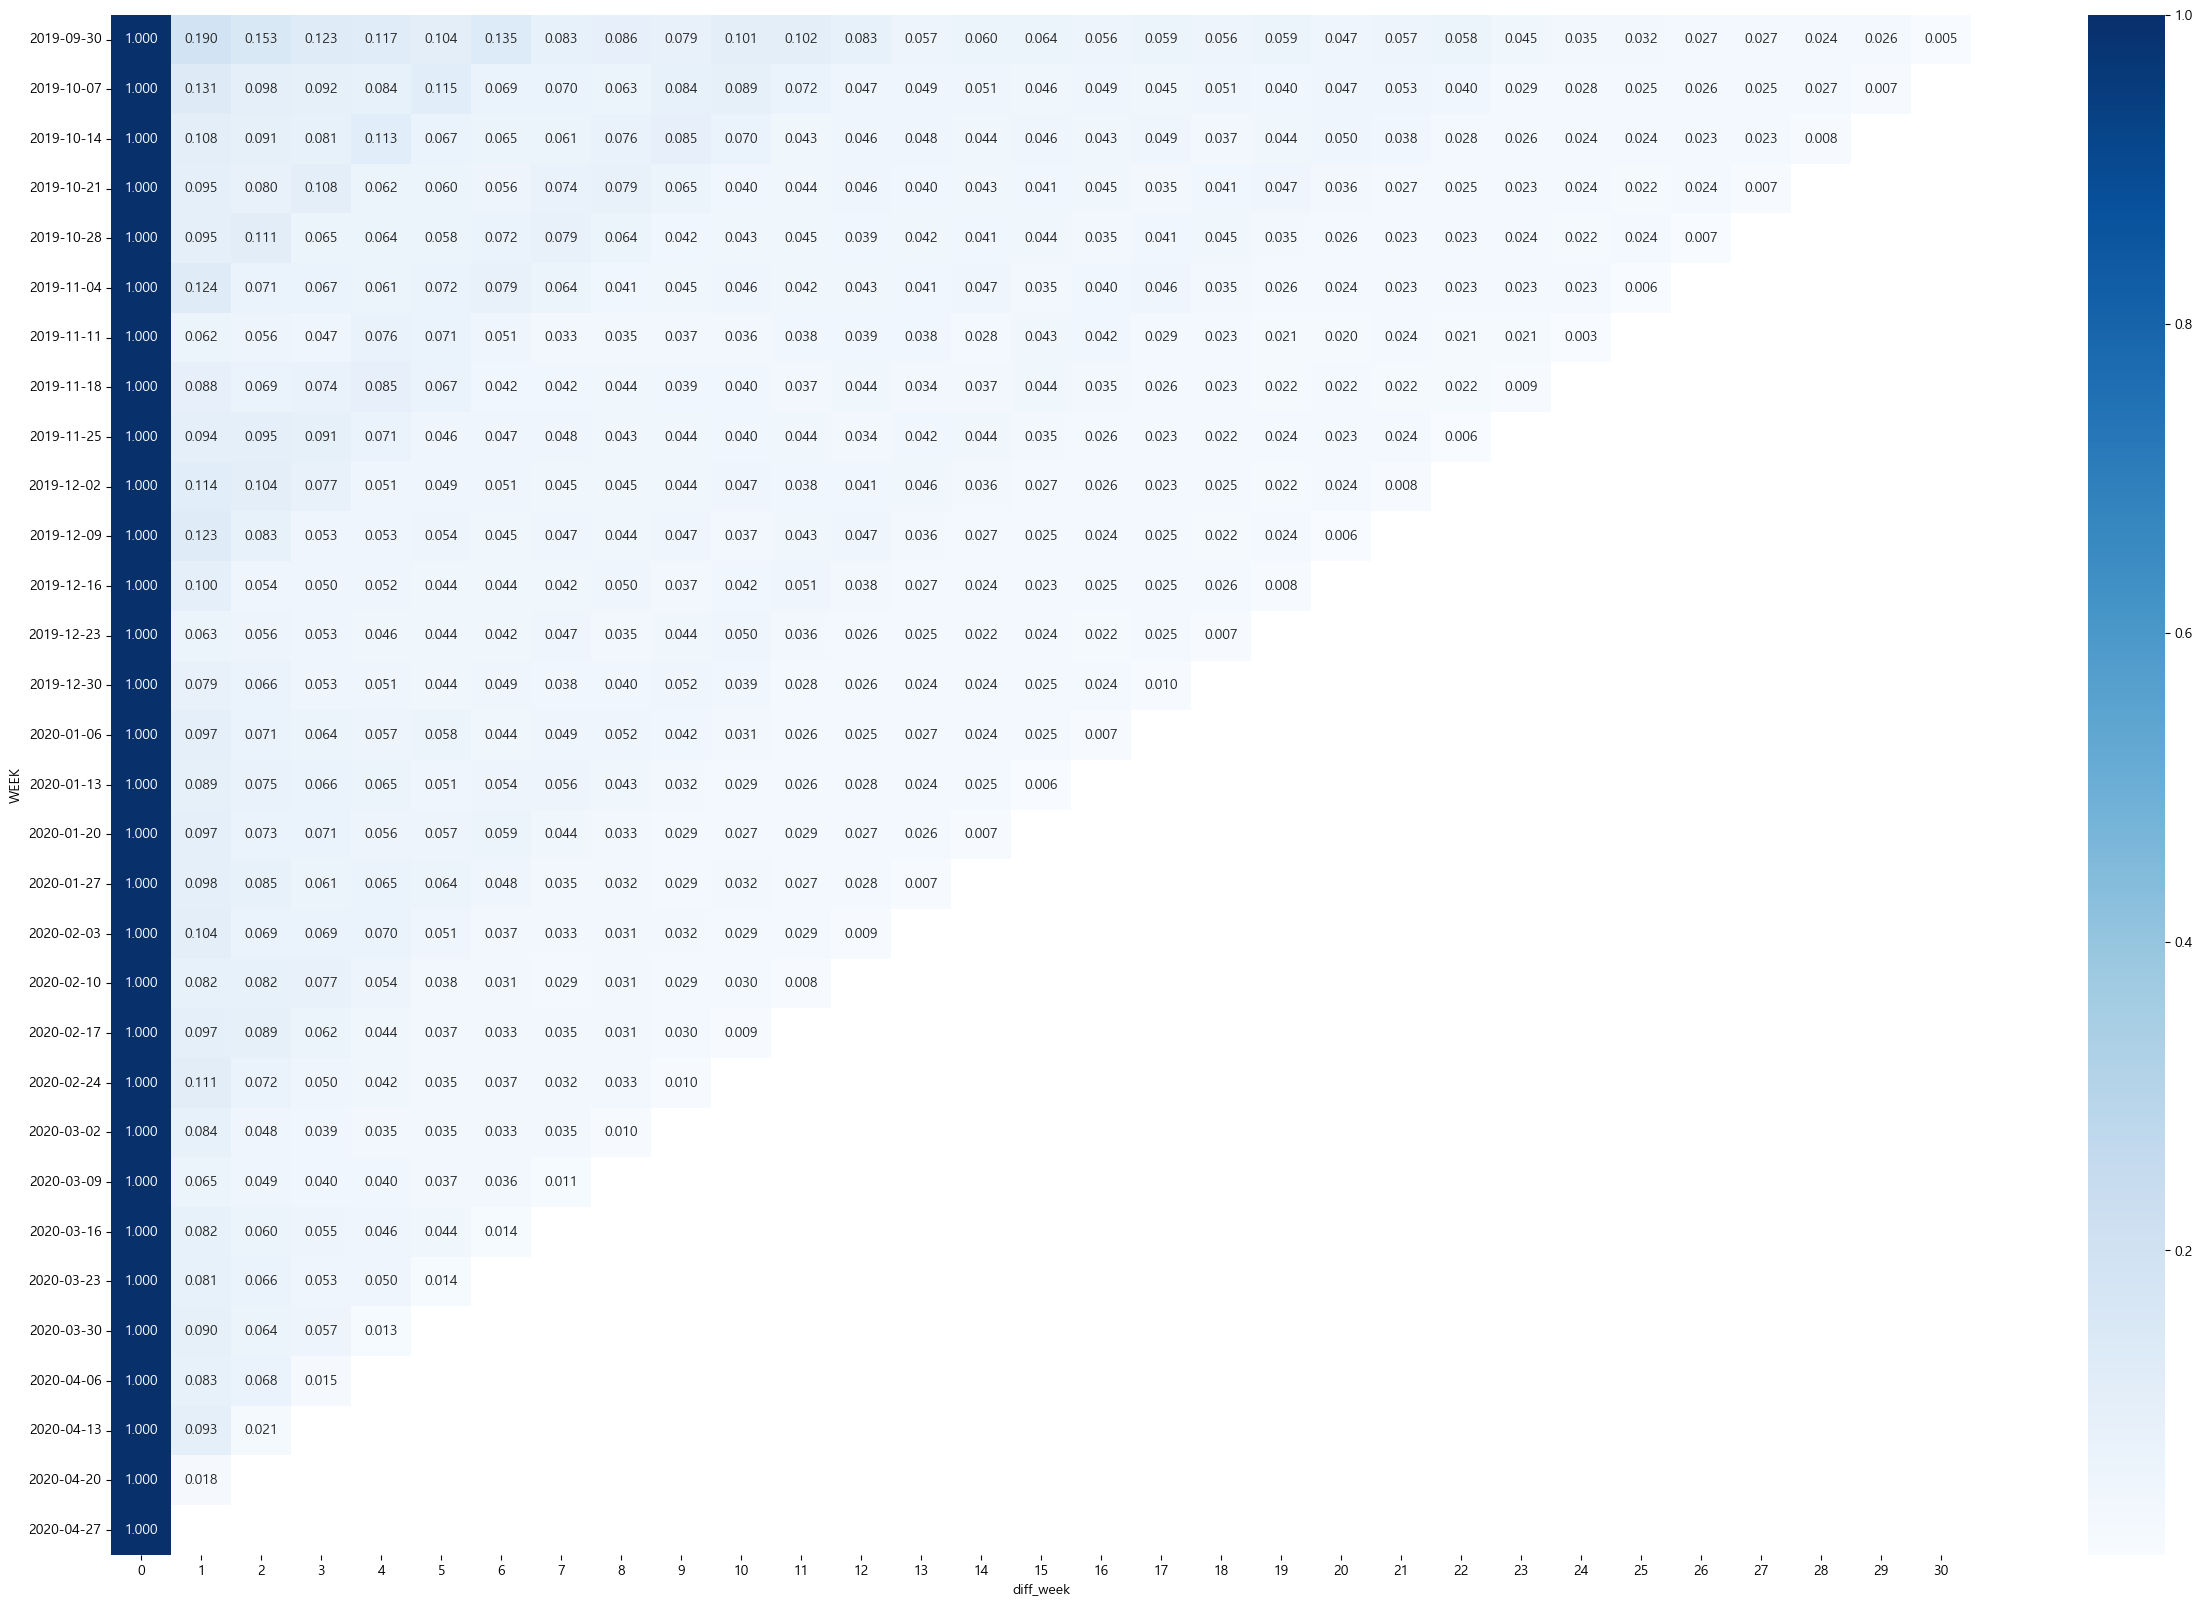

In [156]:
plt.figure(figsize=(30, 20))
sns.heatmap(df_retention_range_7_purchase_pivot, annot=True, fmt=".3f", cmap="Blues")
plt.show()

In [265]:
cart = spark.sql("""
                    SELECT COUNT(DISTINCT user_id)
                    FROM (
                            SELECT user_id, product_id
                            FROM ecommerce
                            WHERE event_type = 'cart'
                            EXCEPT
                            SELECT user_id, product_id
                            FROM ecommerce
                            WHERE event_type = 'purchase'
                            ) AS cart_only
                 """)

In [266]:
cart.toPandas()

count(DISTINCT user_id)
0                  2624018

## 3) engagement = DAU / MAU  (서비스 리텐션 수준을 볼 수 있는 간단한 지표)

## 4) RFM

### 특정일 기준으로 사용자가 최근 구매한 날짜가 며칠 전인지

#### 쿼리

In [8]:
rfm2  = spark.sql(""" 
                    SELECT user_id, 
                    DATEDIFF("2020-05-01", MAX(event_time)) AS Recency,
                    COUNT(*) AS Frequency,
                    FLOOR(SUM(price)) AS Monetary
                    FROM ecommerce
                    WHERE event_type = 'purchase'
                    GROUP BY user_id 
                    ORDER BY Frequency DESC
                 """)

In [9]:
df_rfm2 = rfm2.toPandas()

#### 분포

In [10]:
df_rfm2.describe()

Recency     Frequency      Monetary
count  2.064899e+06  2.064899e+06  2.064899e+06
mean   8.937825e+01  3.316784e+00  9.958964e+02
std    6.203655e+01  8.143284e+00  3.678657e+03
min    0.000000e+00  1.000000e+00  0.000000e+00
25%    3.400000e+01  1.000000e+00  1.400000e+02
50%    8.000000e+01  2.000000e+00  3.220000e+02
75%    1.390000e+02  3.000000e+00  8.570000e+02
max    2.130000e+02  2.120000e+03  7.901200e+05

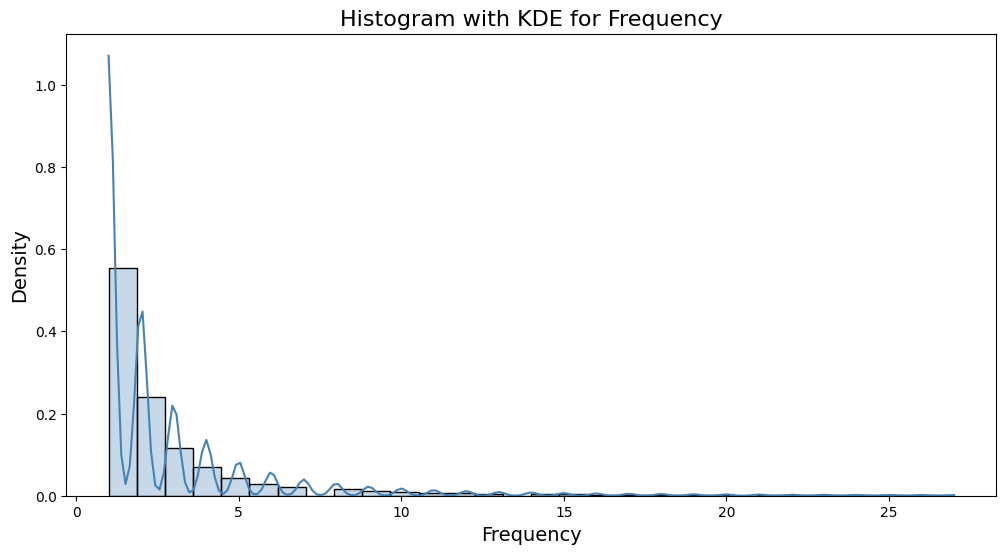

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns


frequency = df_rfm2['Frequency'][df_rfm2['Frequency']<df_rfm2['Frequency'].quantile(0.99)]

# 히스토그램과 KDE 그리기
plt.figure(figsize=(12, 6))  # 그래프 크기 설정
sns.histplot(frequency, kde=True, color='steelblue', 
             bins=30, stat='density', alpha=0.3)
plt.title('Histogram with KDE for Frequency', fontsize=16)
plt.xlabel('Frequency', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(visible=False)  # 그리드 숨기기
plt.show()

#### frequency 와 Monetary max값 user ID 탐색

In [100]:
df_rfm2[df_rfm2['Frequency']==2120]

user_id  Recency  Frequency  Monetary
0  568782581       53       2120    540447

In [101]:
df_rfm2[df_rfm2['Monetary']==790120]

user_id  Recency  Frequency  Monetary
6  553431815        0        888    790120

In [104]:
max_frequency = spark.sql("""
SELECT user_id, category_code, brand, price
                          FROM ecommerce
                          WHERE user_id IN (553431815, 568782581) AND event_type = 'purchase'

""").toPandas()

In [105]:
max_frequency

user_id                     category_code    brand    price
0     568782581      appliances.personal.massager     None   210.82
1     568782581          construction.tools.light  samsung   168.79
2     568782581  appliances.kitchen.refrigerators       lg   694.74
3     568782581          construction.tools.light  samsung   168.86
4     568782581         appliances.kitchen.washer       lg   296.02
...         ...                               ...      ...      ...
3003  553431815          construction.tools.light    apple  1020.61
3004  553431815                     sport.bicycle    apple   170.58
3005  553431815          construction.tools.light    apple  1106.85
3006  553431815          construction.tools.light    apple  1106.85
3007  553431815          construction.tools.light    apple  1106.85

[3008 rows x 4 columns]

#### Recency

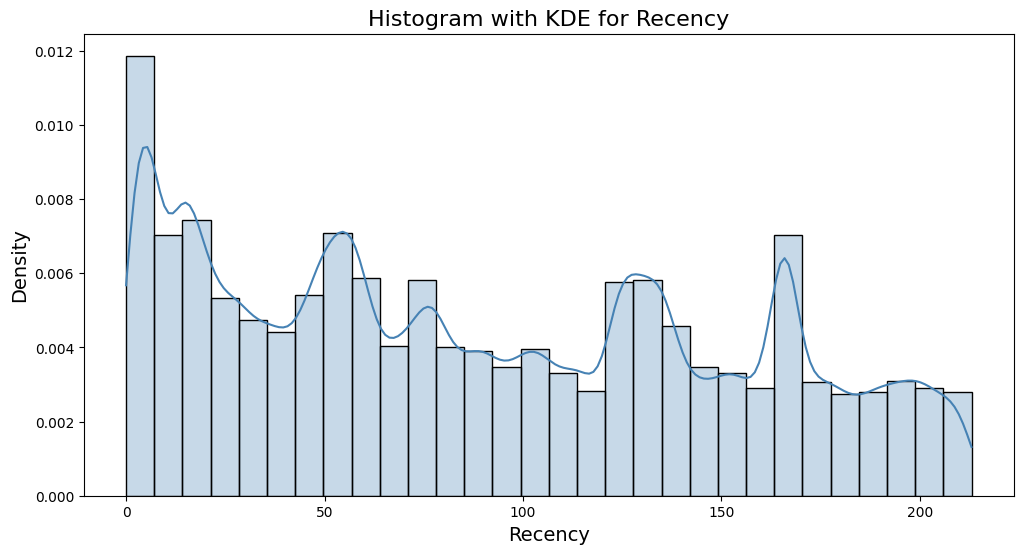

In [111]:
# 히스토그램과 KDE 그리기
plt.figure(figsize=(12, 6))  # 그래프 크기 설정
sns.histplot(df_rfm2['Recency'], kde=True, color='steelblue', 
             bins=30, stat='density', alpha=0.3)
plt.title('Histogram with KDE for Recency', fontsize=16)
plt.xlabel('Recency', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(visible=False)  # 그리드 숨기기
plt.show()

In [117]:
for i in range(100):
    print(f"하위 {i}% : {df_rfm2['Recency'].quantile(i*0.01)}")


하위 0% : 0.0
하위 1% : 1.0
하위 2% : 2.0
하위 3% : 3.0
하위 4% : 3.0
하위 5% : 4.0
하위 6% : 5.0
하위 7% : 6.0
하위 8% : 7.0
하위 9% : 8.0
하위 10% : 9.0
하위 11% : 12.0
하위 12% : 13.0
하위 13% : 14.0
하위 14% : 15.0
하위 15% : 16.0
하위 16% : 17.0
하위 17% : 19.0
하위 18% : 20.0
하위 19% : 22.0
하위 20% : 24.0
하위 21% : 26.0
하위 22% : 28.0
하위 23% : 29.0
하위 24% : 31.0
하위 25% : 34.0
하위 26% : 36.0
하위 27% : 38.0
하위 28% : 40.0
하위 29% : 43.0
하위 30% : 45.0
하위 31% : 47.0
하위 32% : 48.0
하위 33% : 50.0
하위 34% : 51.0
하위 35% : 53.0
하위 36% : 54.0
하위 37% : 55.0
하위 38% : 57.0
하위 39% : 58.0
하위 40% : 59.0
하위 41% : 61.0
하위 42% : 63.0
하위 43% : 66.0
하위 44% : 68.0
하위 45% : 71.0
하위 46% : 73.0
하위 47% : 75.0
하위 48% : 77.0
하위 49% : 78.0
하위 50% : 80.0
하위 51% : 83.0
하위 52% : 86.0
하위 53% : 88.0
하위 54% : 91.0
하위 55% : 93.0
하위 56% : 96.0
하위 57% : 99.0
하위 58% : 102.0
하위 59% : 104.0
하위 60% : 107.0
하위 61% : 110.0
하위 62% : 113.0
하위 63% : 115.0
하위 64% : 118.0
하위 65% : 122.0
하위 66% : 124.0
하위 67% : 125.0
하위 68% : 127.0
하위 69% : 129.0
하위 70% : 130.0
하위 71% : 132.0

- Recency 기준
    - high-> 상위 ~25% (3사분위수)
    - middle -> 상위 25~75%
    - low -> 하위 ~25% (1사분위수)

#### Frequency

In [99]:
df_rfm2['Monetary'][df_rfm2['Monetary']==0].count()

np.int64(57)

In [80]:
df_rfm2['Frequency'][df_rfm2['Frequency']==1].count()/df_rfm2['Frequency'].count()

np.float64(0.4758673426642175)

In [108]:
(df_rfm2['Frequency'][df_rfm2['Frequency']==2].count() + df_rfm2['Frequency'][df_rfm2['Frequency']==3].count())/df_rfm2['Frequency'].count()

np.float64(0.3055122792930792)

In [109]:
df_rfm2['Frequency'][df_rfm2['Frequency']>=4].count()/df_rfm2['Frequency'].count()

np.float64(0.2186203780427033)

- Frequency 기준
    - high-> 4번 이상(약 20%)
    - middle -> 2번 이상(약 30%)
    - low -> 1번 이하 (약 50%)

#### Monetary

In [ ]:
outlier = df_rfm2['Monetary'].quantile(0.75) + 1.5*IQR
outlier

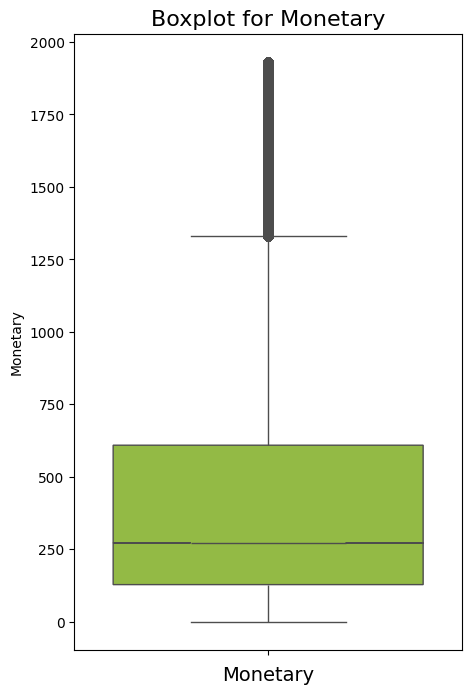

In [29]:
# 박스플롯 그리기
plt.figure(figsize=(5,8))  # 그래프 크기 설정
sns.boxplot(
    df_rfm2['Monetary'][df_rfm2['Monetary']<outlier],
    notch=True, 
    color='yellowgreen'  # 박스플롯 색상
)
plt.title('Boxplot for Monetary', fontsize=16)
plt.xlabel('Monetary', fontsize=14)
plt.grid(visible=False)  # 그리드 숨기기
plt.show()

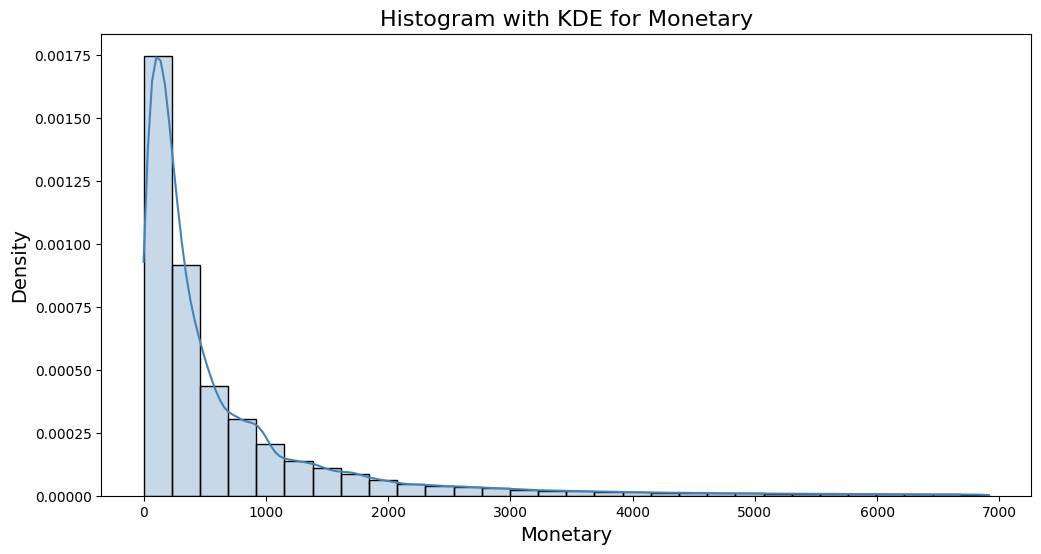

In [17]:
# 히스토그램과 KDE 그리기
plt.figure(figsize=(12, 6))  # 그래프 크기 설정
sns.histplot(df_rfm2['Monetary'][df_rfm2['Monetary']<df_rfm2['Monetary'].quantile(0.98)], kde=True, color='steelblue', 
             bins=30, stat='density', alpha=0.3)
plt.title('Histogram with KDE for Monetary', fontsize=16)
plt.xlabel('Monetary', fontsize=14)
plt.ylabel('Density', fontsize=14)
plt.grid(visible=False)  # 그리드 숨기기
plt.show()

 Q1 - 1.5 * IQR 미만이거나 Q3 + 1.5 * IQR 초과인 값들을 이상치로 간주

In [20]:
IQR = df_rfm2['Monetary'].quantile(0.75) - df_rfm2['Monetary'].quantile(0.25)

In [25]:
df_rfm2['Monetary'].quantile(0.25) - 1.5*IQR

np.float64(-935.5)

In [28]:
outlier = df_rfm2['Monetary'].quantile(0.75) + 1.5*IQR
outlier

np.float64(1932.5)

In [123]:
df_rfm2.sort_values(by='Monetary' ,ascending=False).head(20)

user_id  Recency  Frequency  Monetary
6    553431815        0        888    790120
1    549109608       25       1383    750149
35   569333570       18        488    689273
2    513230794       40       1373    647798
45   595104624       36        458    605792
3    513320236        3       1159    567148
56   610871788        0        407    561013
0    568782581       53       2120    540447
4    598224683        1       1059    539601
51   538216048       51        417    523403
5    563599039       78        958    474648
12   512386086      134        806    473119
34   515428951       52        490    447804
38   516010934       35        482    403633
32   512409624       38        521    386011
54   518514099       21        410    368759
180  562104312       19        260    351876
93   514726585       34        341    336402
289  515384420        7        218    332926
110  534545940      108        315    331185

In [11]:
i = 80
print(f"하위 {i}% : {df_rfm2['Monetary'].quantile(i*0.01)}")

하위 80% : 1050.0


In [12]:
i = 20
print(f"하위 {i}% : {df_rfm2['Monetary'].quantile(i*0.01)}")

하위 20% : 114.0


In [13]:
i = 99
print(f"하위 {i}% : {df_rfm2['Monetary'].quantile(i*0.01)}")

하위 99% : 10940.0


- Monetary 기준
    - high-> 상위 ~25% (3사분위수)
    - middle -> 상위 25~75%
    - low -> 하위 ~25% (1사분위수)

#### RFM 점수화 하기

In [31]:
r_q1 = df_rfm2['Recency'].quantile(0.25)
r_q3 = df_rfm2['Recency'].quantile(0.75)
df_rfm2['Recency_score'] = pd.cut(df_rfm2['Recency'], bins=[-float('inf'), r_q1, r_q3, float('inf')], labels=[3,2,1])
m_q1 = df_rfm2['Monetary'].quantile(0.25)
m_q3 = df_rfm2['Monetary'].quantile(0.75)
df_rfm2['Monetary_score'] = pd.cut(df_rfm2['Monetary'], bins=[-float('inf'), m_q1, m_q3, float('inf')], labels=[1,2,3])


In [33]:
def frequency_score(frequency):
    if frequency >= 4:
        return 3  # high
    elif frequency >= 2:
        return 2  # middle
    else:
        return 1  # low


In [34]:
df_rfm2['Frequency_score'] = df_rfm2['Frequency'].apply(frequency_score)

In [35]:
df_rfm2

user_id  Recency  Frequency  Monetary Recency_score Monetary_score  \
0        568782581       53       2120    540447             2              3   
1        549109608       25       1383    750149             3              3   
2        513230794       40       1373    647798             2              3   
3        513320236        3       1159    567148             3              3   
4        598224683        1       1059    539601             3              3   
...            ...      ...        ...       ...           ...            ...   
2064894  635125080       30          1       170             3              2   
2064895  488893876       30          1       407             3              2   
2064896  633361079       30          1       421             3              2   
2064897  635075963       30          1       423             3              2   
2064898  632607170       30          1       411             3              2   

         Frequency_score  
0                      3  
1                      3  
2                      3  
3                      3  
4                      3  
...                  ...  
2064894                1  
2064895                1  
2064896                1  
2064897                1  
2064898                1  

[2064899 rows x 7 columns]

In [36]:
df_rfm2.to_csv("RFM_SCORE.csv", index=False)

In [8]:
df_rfm2 = pd.read_csv("RFM_SCORE.csv")

In [55]:
df_rfm2['Recency_score'] = df_rfm2['Recency_score'].astype(int)
df_rfm2['Frequency_score'] = df_rfm2['Frequency_score'].astype(int)
df_rfm2['Monetary_score'] = df_rfm2['Monetary_score'].astype(int)

In [56]:
df_rfm2['RFM_Score'] = (
    df_rfm2['Recency_score'] * 100 +
    df_rfm2['Frequency_score'] * 10 +
    df_rfm2['Monetary_score']
)

In [45]:
df_rfm2['RFM_Score'] = df_rfm2['RFM_Score'].astype(str)

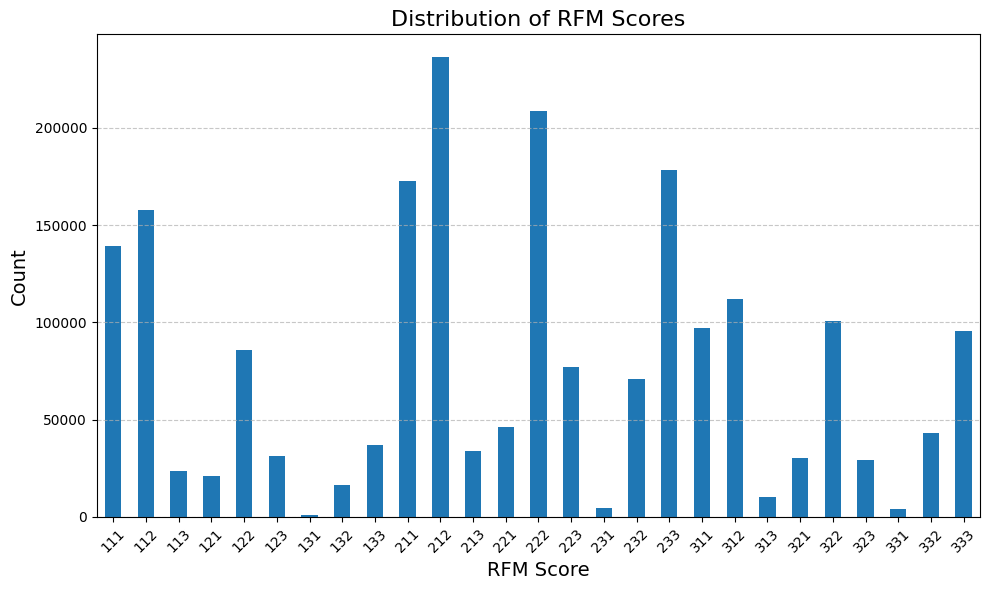

In [46]:
plt.figure(figsize=(10, 6))
df_rfm2['RFM_Score'].value_counts().sort_index().plot(kind='bar')

plt.title('Distribution of RFM Scores', fontsize=16)
plt.xlabel('RFM Score', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [64]:
rfm_group = []
for x in df_rfm2['RFM_Score']:
    if x == 333:
        rfm_group.append('VIP')
    elif x in [332, 323, 322]:
        rfm_group.append('충성고객')
    elif x in [331, 321]:
        rfm_group.append('잠재적 고가치 고객')
    elif x in [311, 312, 313]:
        rfm_group.append('신규 고객')
    elif x in [133, 132, 121, 131, 122, 123]:
        rfm_group.append('이탈 고객')
    elif x in [221,231, 222, 223, 232, 233]:
        rfm_group.append('이탈 우려 고객')
    elif x in [111, 112, 113, 211, 212, 213]:
        rfm_group.append('일시적 고객')


In [65]:
set(rfm_group)

{'VIP', '신규 고객', '이탈 고객', '이탈 우려 고객', '일시적 고객', '잠재적 고가치 고객', '충성고객'}

In [66]:
df_rfm2['RFM_Group']=rfm_group

In [71]:
plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

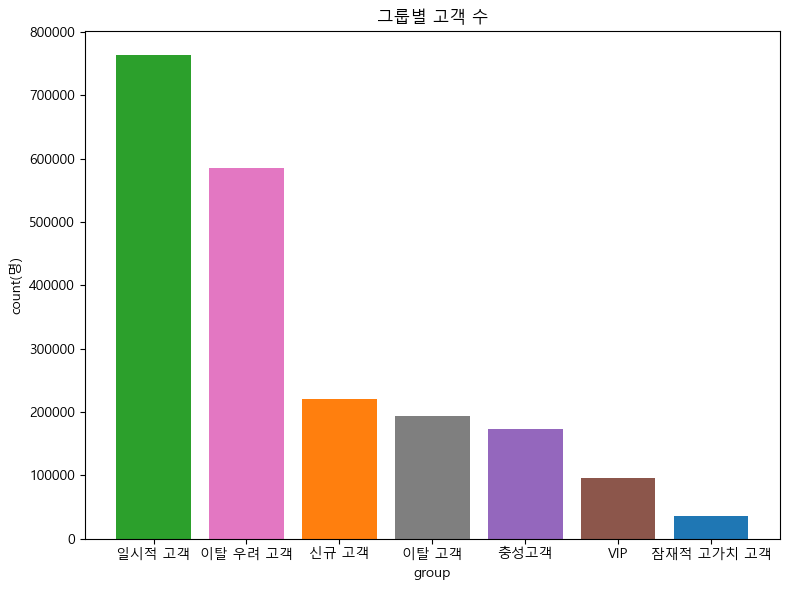

In [74]:
RFM_group = df_rfm2['RFM_Group'].value_counts().reset_index()
RFM_group.columns = ['group','count']
RFM_group.sort_values('count', ascending=False)


plt.figure(figsize=(8, 6))
colors = ['#2ca02c','#e377c2','#ff7f0e','#7f7f7f','#9467bd',
          '#8c564b','#1f77b4','#d62728','#bcbd22']
plt.bar(RFM_group['group'], RFM_group['count'], color=colors)
plt.xlabel('group')
plt.ylabel('count(명)')
plt.title('그룹별 고객 수')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [75]:
grouped_sales = df_rfm2.groupby('RFM_Group')['Monetary'].sum()
grouped_sales.sort_values(ascending=False, inplace=True)
total_sales = grouped_sales.sum()
sales_percentage = (grouped_sales / total_sales) * 100


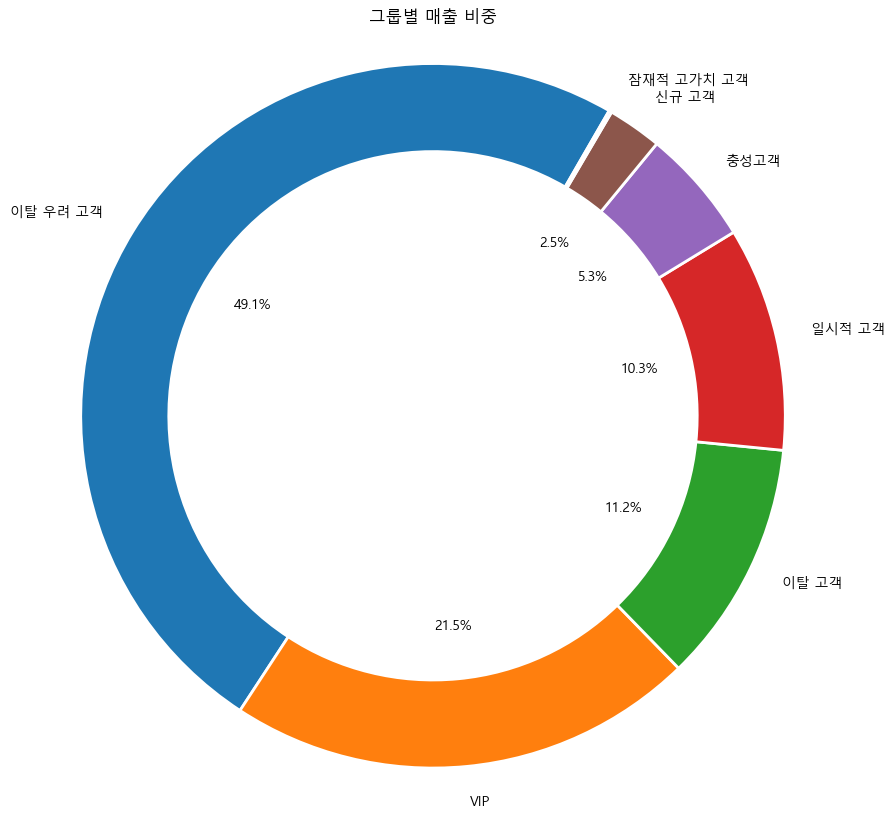

In [76]:
pie_colors = plt.cm.tab10.colors[:len(grouped_sales)]
plt.figure(figsize=(10, 10))
plt.pie(sales_percentage, 
        labels=sales_percentage.index, 
        autopct=lambda p: '{:.1f}%'.format(p) if p > 2 else '', 
        startangle=60, 
        wedgeprops={'width': 0.25, 'edgecolor': 'w', 'linewidth': 2}, 
        colors=pie_colors)
plt.title('그룹별 매출 비중')
plt.axis('equal')
plt.show()

In [79]:
spark_df = spark.createDataFrame(df_rfm2)

In [84]:
spark_df.createOrReplaceTempView("temp_table")

In [92]:
df_rfm2.to_csv("RFM_GROUP.csv", index=False)

In [93]:
spark_rfm_df = spark.read.option("encoding", "UTF-8").csv('RFM_GROUP.csv', header=True)
spark_rfm_df.show()
spark_rfm_df.createOrReplaceTempView("rfm_tb")

+---------+-------+---------+--------+-------------+--------------+---------------+---------+--------------+
|  user_id|Recency|Frequency|Monetary|Recency_score|Monetary_score|Frequency_score|RFM_Score|     RFM_Group|
+---------+-------+---------+--------+-------------+--------------+---------------+---------+--------------+
|568782581|     53|     2120|  540447|            2|             3|              3|      233|이탈 우려 고객|
|549109608|     25|     1383|  750149|            3|             3|              3|      333|           VIP|
|513230794|     40|     1373|  647798|            2|             3|              3|      233|이탈 우려 고객|
|513320236|      3|     1159|  567148|            3|             3|              3|      333|           VIP|
|598224683|      1|     1059|  539601|            3|             3|              3|      333|           VIP|
|563599039|     78|      958|  474648|            2|             3|              3|      233|이탈 우려 고객|
|553431815|      0|      888|  790120

In [97]:
retention_range_30_RFM = spark.sql("""
                               WITH first as (
                                    SELECT user_id, MIN(event_time) AS first_interaction_time
                                    FROM ecommerce
                                    GROUP BY user_id
                                )

                                SELECT 
                                   MONTH(first_interaction_time) AS MONTH, 
                                   FLOOR(MONTHS_BETWEEN(event_time, first_interaction_time)) AS diff_month,
                                   RFM_Group,                         
                                   COUNT(DISTINCT s.user_id) as user_cnt
                                FROM ecommerce s LEFT JOIN first f
                                ON s.user_id = f.user_id
                                LEFT JOIN rfm_tb r
                                ON r.user_id = s.user_id                                
                                GROUP BY MONTH, FLOOR(MONTHS_BETWEEN(event_time, first_interaction_time)), RFM_Group
                                ORDER BY diff_month

                          """)


In [98]:
df_retention_range_30_RFM = retention_range_30_RFM.toPandas()
# 76m14.4s

In [102]:
df_retention_range_30_RFM.to_csv("월간리텐션_RFM.csv")

### RFM 그룹별 분석

#### 대분류

In [135]:
rfm_major_category = spark.sql("""SELECT SUBSTRING_INDEX(category_code, '.', 1) AS code,
                        rfm_group,
                        COUNT(e.user_id ) AS cnt,
                        SUM(price) AS total_price 

          FROM ecommerce e
          LEFT JOIN rfm_tb as r
          ON e.user_id = r.user_id

          GROUP BY rfm_group, code


          """)

In [136]:
df_rfm_major_category = rfm_major_category.toPandas()


In [137]:
df_rfm_major_category.to_csv("RFM 카테고리 분석(대분류).csv")

In [138]:
rfm_group_list = ['VIP', '충성고객', '잠재적 고가치 고객', '신규 고객', '이탈 고객','이탈 우려 고객', '일시적 고객']

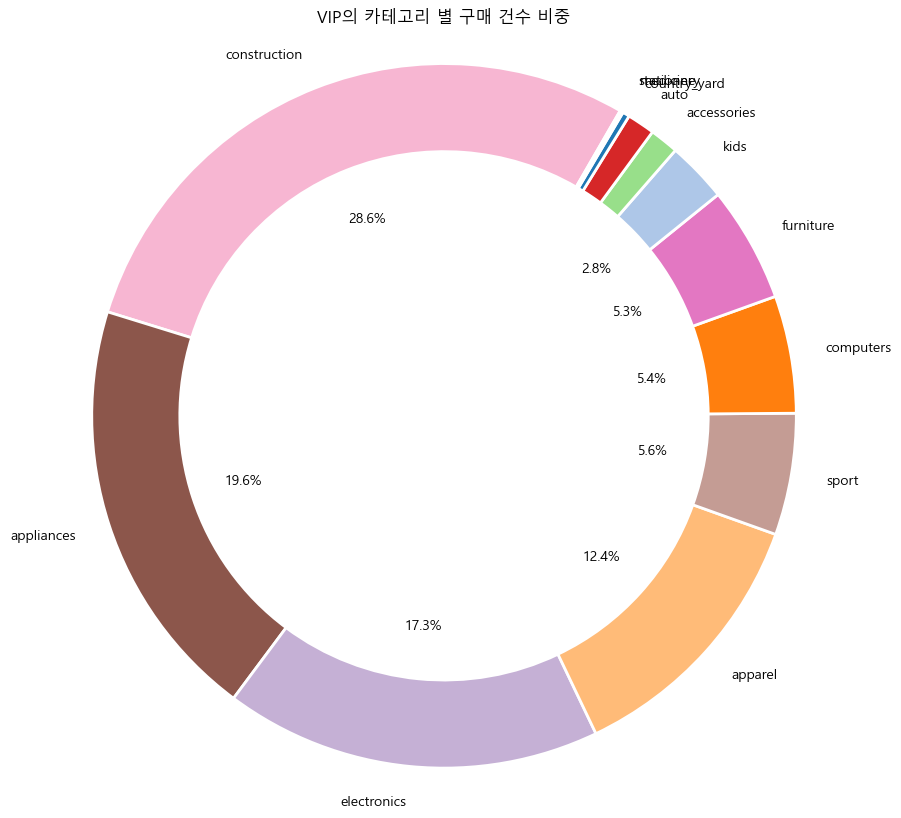

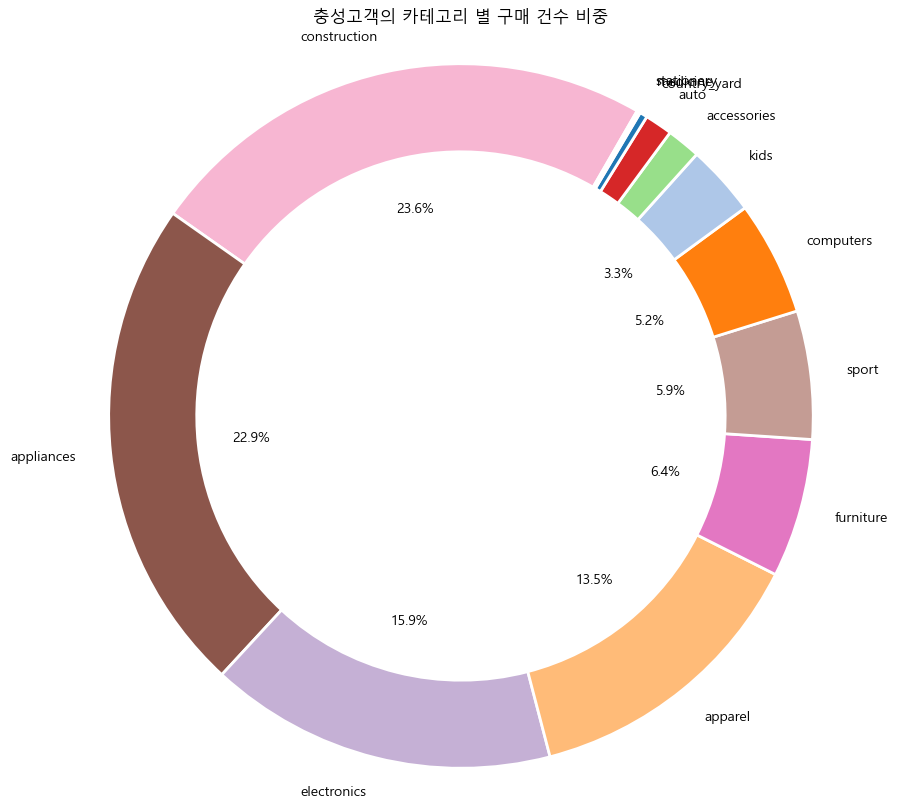

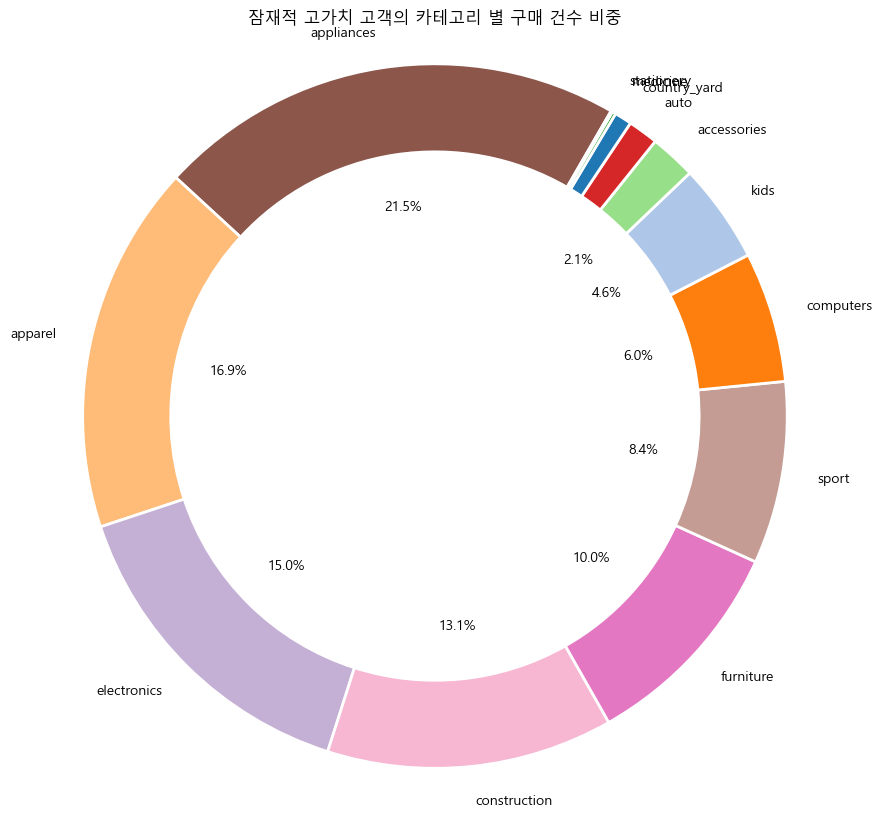

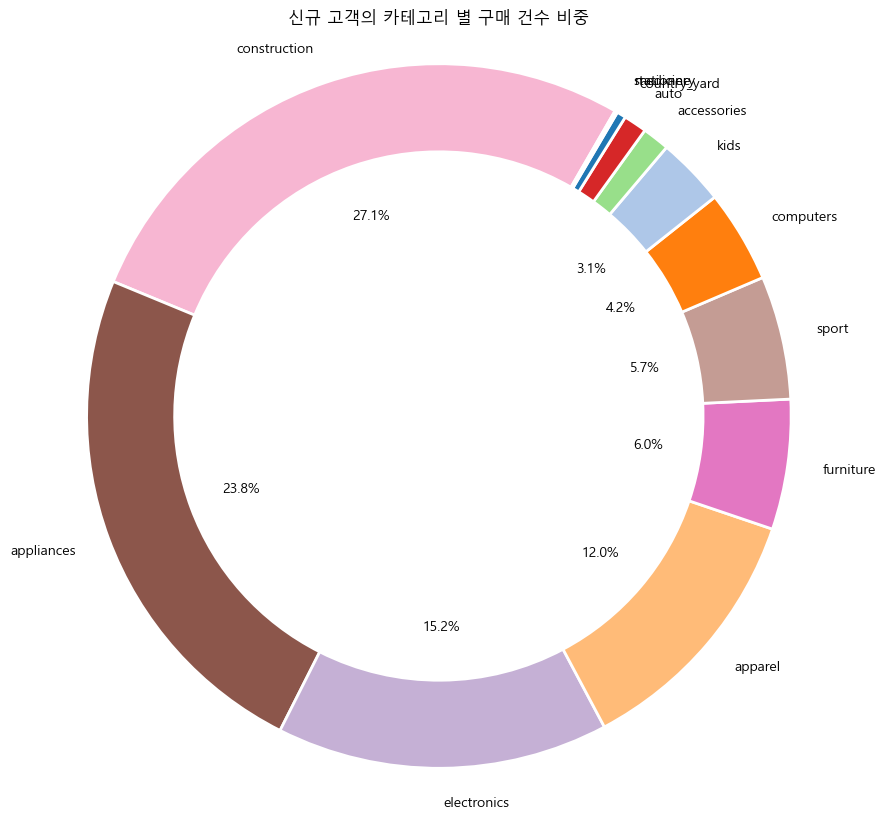

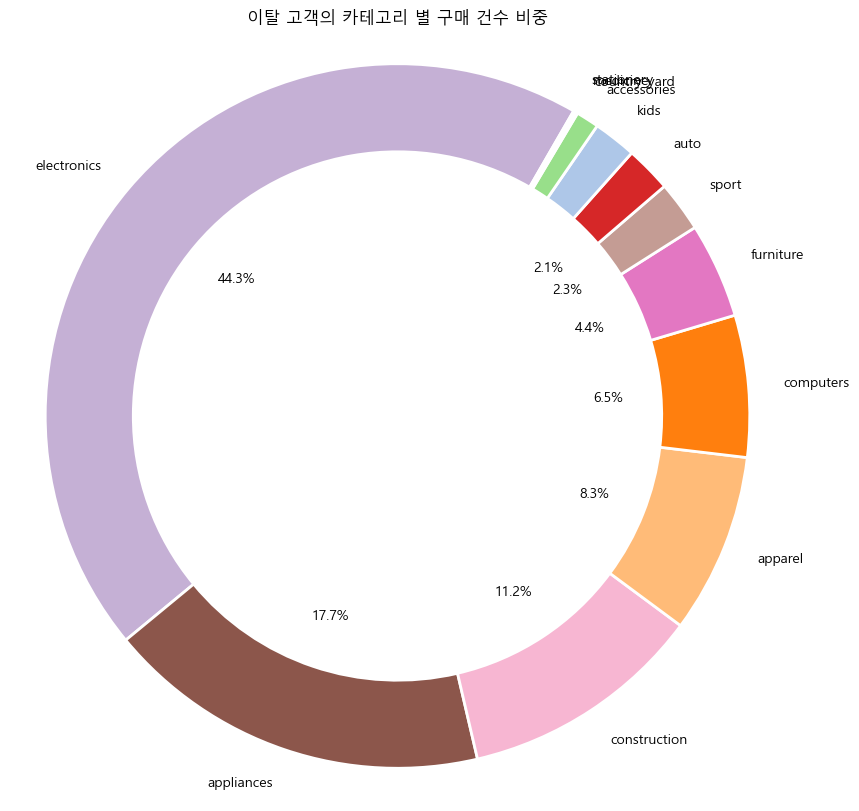

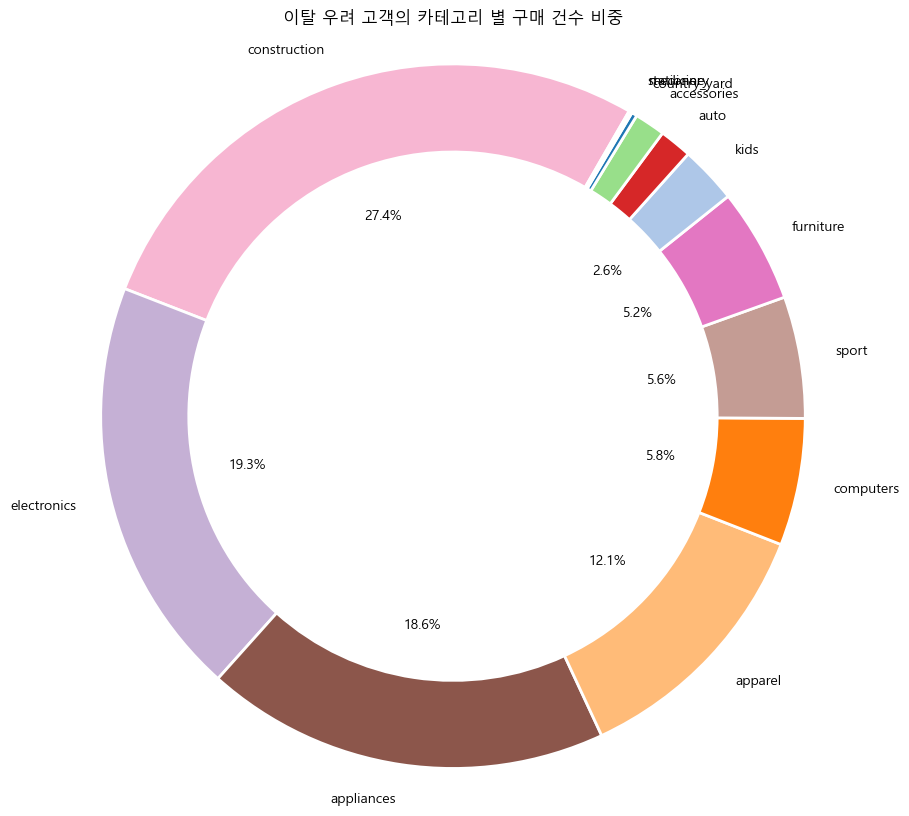

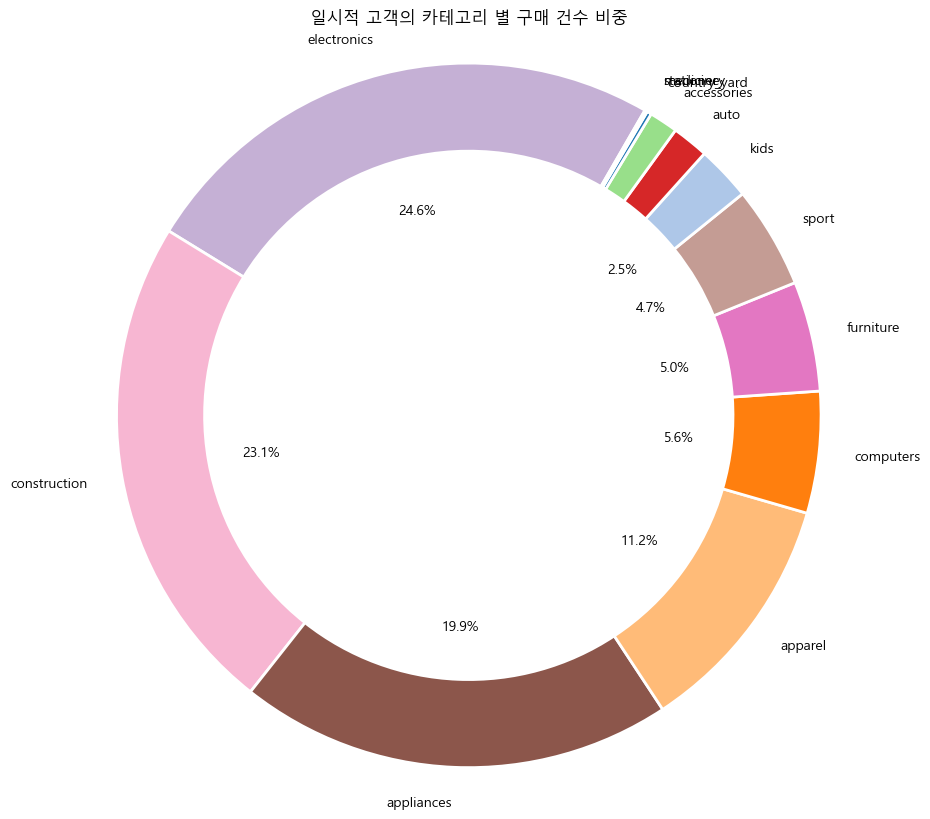

In [139]:
# 1. 전체 code에 대한 고정 색상 매핑 생성
unique_codes = df_rfm_major_category['code'].unique()
color_palette = plt.cm.tab20.colors  # 색상 팔레트 확장
color_mapping = {code: color_palette[i % len(color_palette)] for i, code in enumerate(unique_codes)}

for x in rfm_group_list:
    visual_df = df_rfm_major_category[df_rfm_major_category['rfm_group'] == x]
    visual_category_per_rfm = visual_df.groupby('code')['cnt'].sum()
    visual_category_per_rfm.sort_values(ascending=False, inplace=True)
    total_sales = visual_category_per_rfm.sum()
    sales_percentage = (visual_category_per_rfm / total_sales) * 100
        
    # 색상 매핑 적용
    pie_colors = [color_mapping[code] for code in visual_category_per_rfm.index]
    
    plt.figure(figsize=(10, 10))
    plt.pie(sales_percentage, 
            labels=sales_percentage.index, 
            autopct=lambda p: '{:.1f}%'.format(p) if p > 2 else '', 
            startangle=60, 
            wedgeprops={'width': 0.25, 'edgecolor': 'w', 'linewidth': 2}, 
            colors=pie_colors)
    plt.title(f'{x}의 카테고리 별 구매 건수 비중')
    plt.axis('equal')
    plt.show()

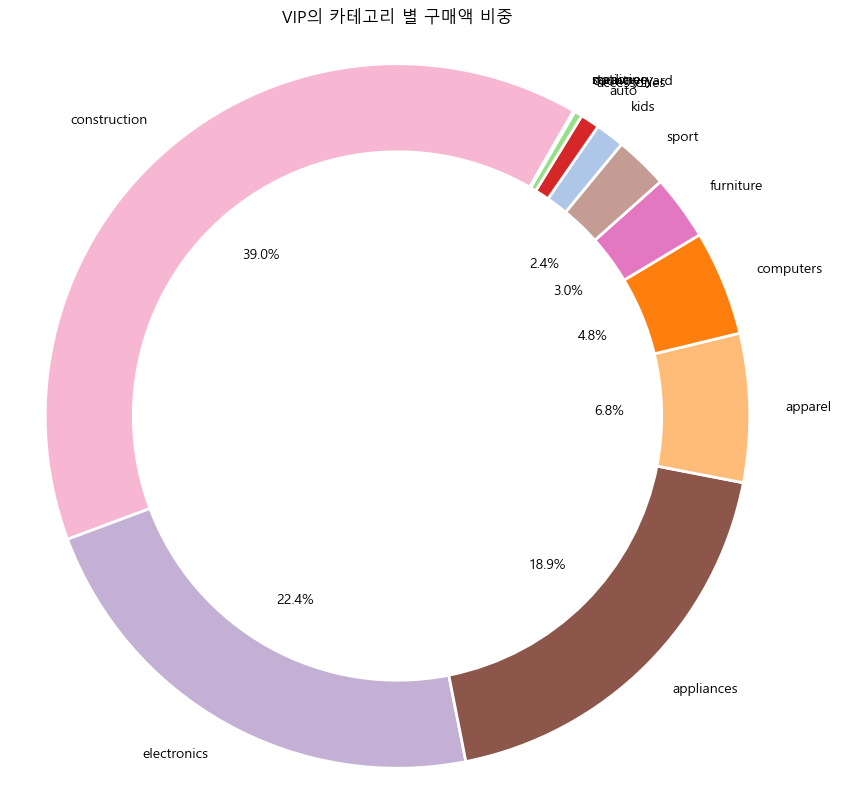

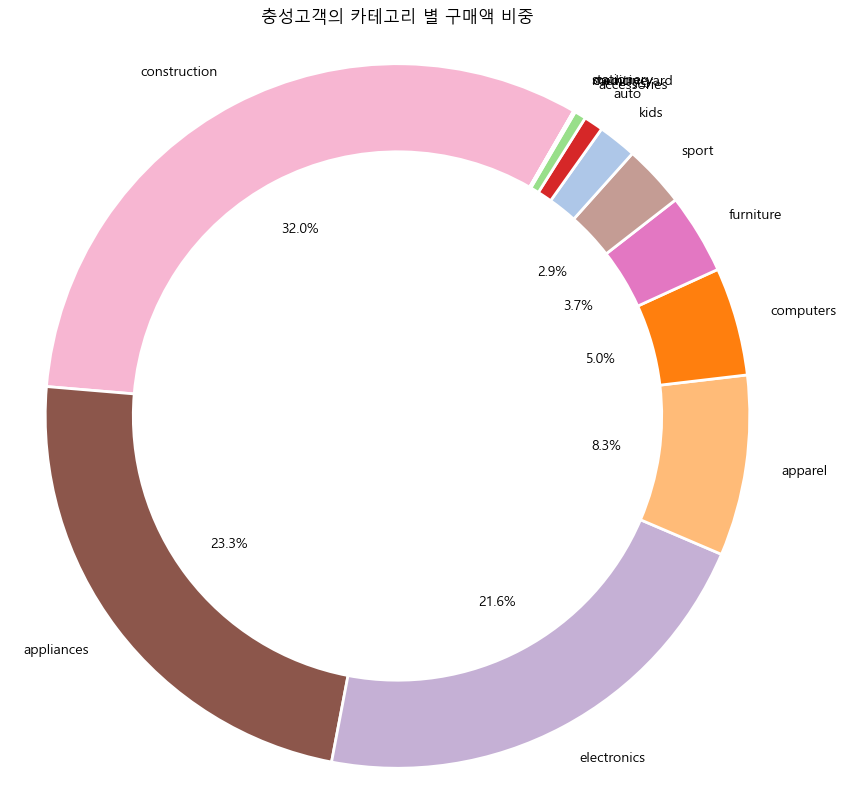

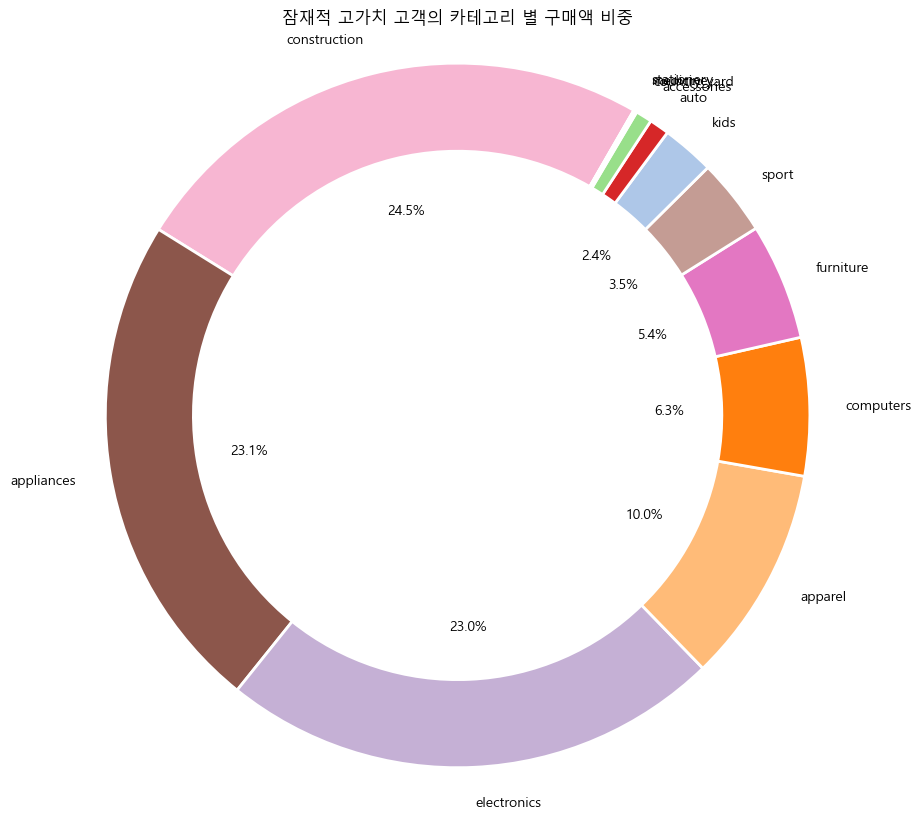

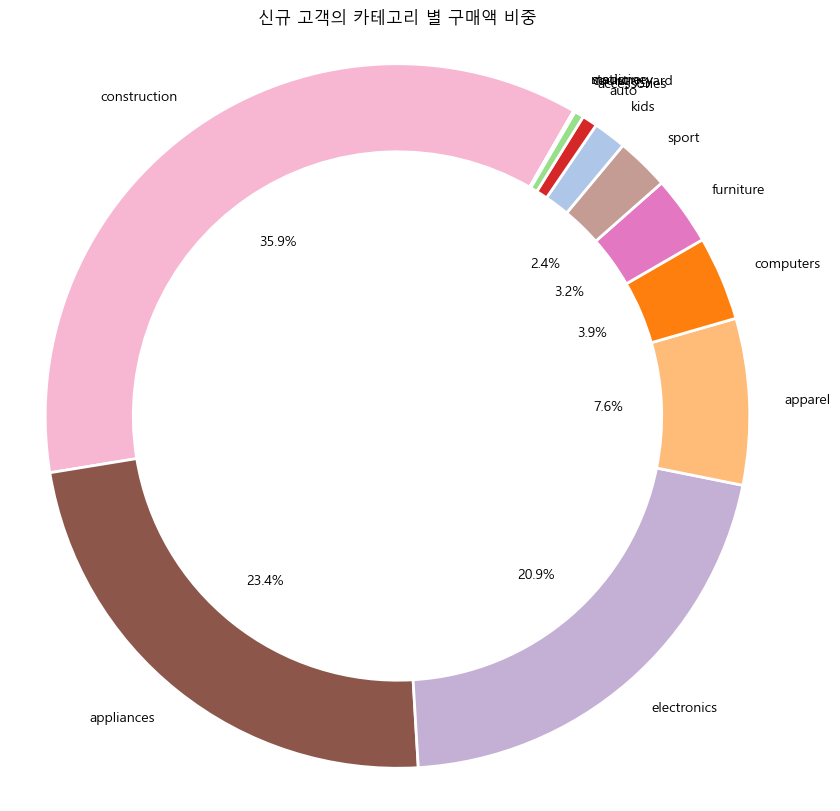

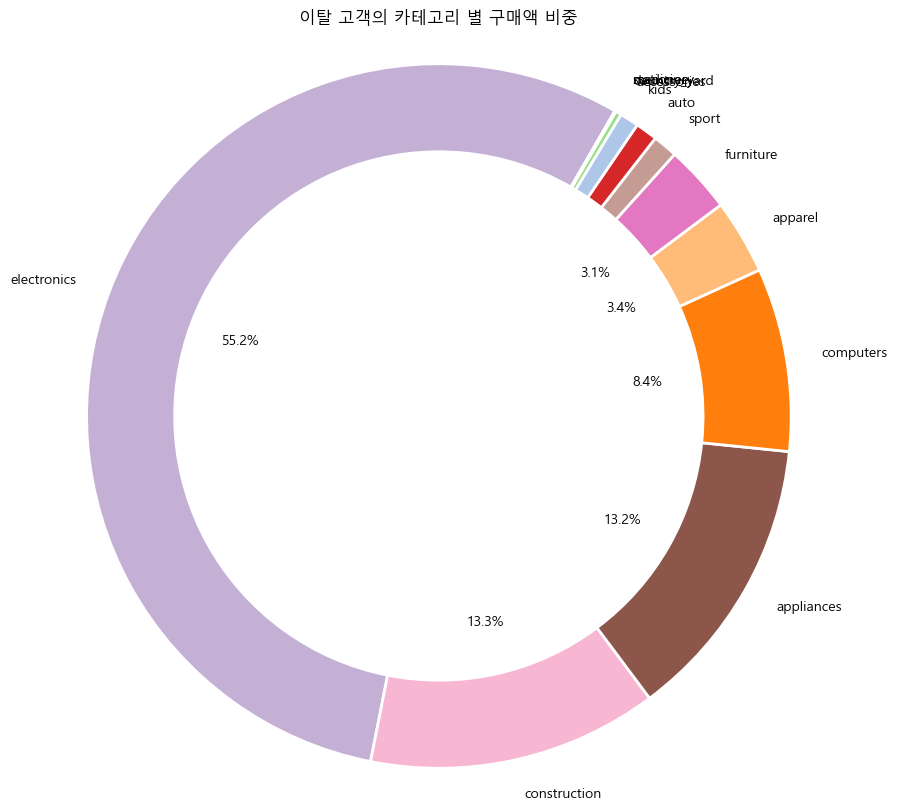

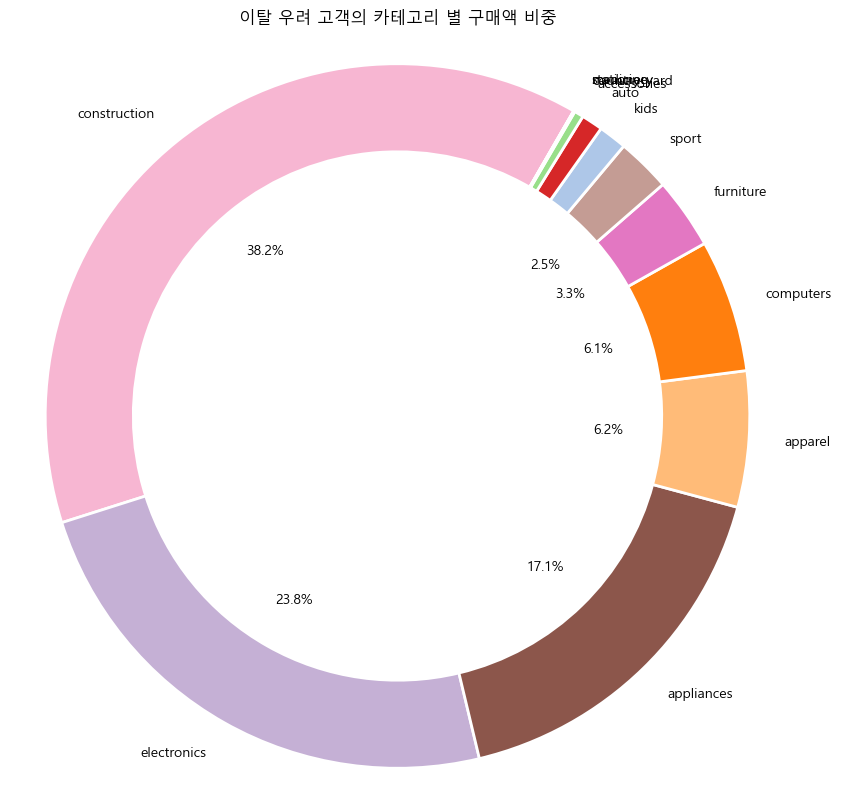

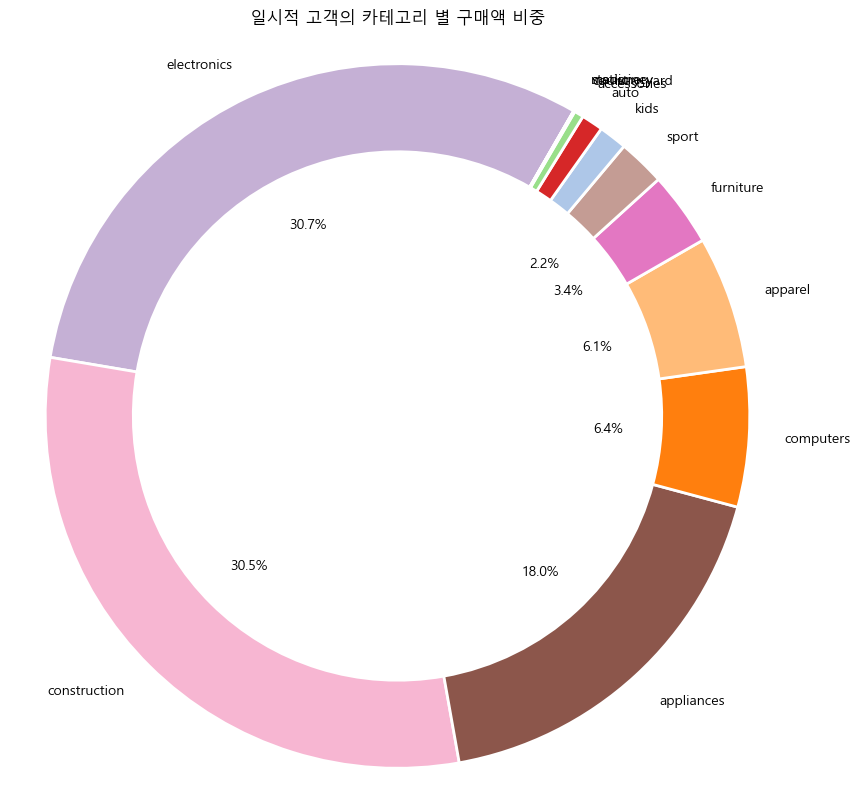

In [140]:
# 1. 전체 code에 대한 고정 색상 매핑 생성
unique_codes = df_rfm_major_category['code'].unique()
color_palette = plt.cm.tab20.colors  # 색상 팔레트 확장
color_mapping = {code: color_palette[i % len(color_palette)] for i, code in enumerate(unique_codes)}

for x in rfm_group_list:
    visual_df = df_rfm_major_category[df_rfm_major_category['rfm_group'] == x]
    visual_category_per_rfm = visual_df.groupby('code')['total_price'].sum()
    visual_category_per_rfm.sort_values(ascending=False, inplace=True)
    total_sales = visual_category_per_rfm.sum()
    sales_percentage = (visual_category_per_rfm / total_sales) * 100
        
    # 색상 매핑 적용
    pie_colors = [color_mapping[code] for code in visual_category_per_rfm.index]
    
    plt.figure(figsize=(10, 10))
    plt.pie(sales_percentage, 
            labels=sales_percentage.index, 
            autopct=lambda p: '{:.1f}%'.format(p) if p > 2 else '', 
            startangle=60, 
            wedgeprops={'width': 0.25, 'edgecolor': 'w', 'linewidth': 2}, 
            colors=pie_colors)
    plt.title(f'{x}의 카테고리 별 구매액 비중')
    plt.axis('equal')
    plt.show()

#### 중분류

In [128]:
rfm_category = spark.sql("""SELECT SUBSTRING_INDEX(category_code, '.', 2) AS code,
                        rfm_group,
                        COUNT(e.user_id ) AS cnt,
                        SUM(price) AS total_price 

          FROM ecommerce e
          LEFT JOIN rfm_tb as r
          ON e.user_id = r.user_id

          GROUP BY rfm_group, code


          """)

In [129]:
df_rfm_category = rfm_category.toPandas()
# 31m11.5s

In [130]:
df_rfm_category.to_csv("RFM 카테고리 분석.csv")

In [126]:
rfm_group_list = ['VIP', '충성고객', '잠재적 고가치 고객', '신규 고객', '이탈 고객','이탈 우려 고객', '일시적 고객']

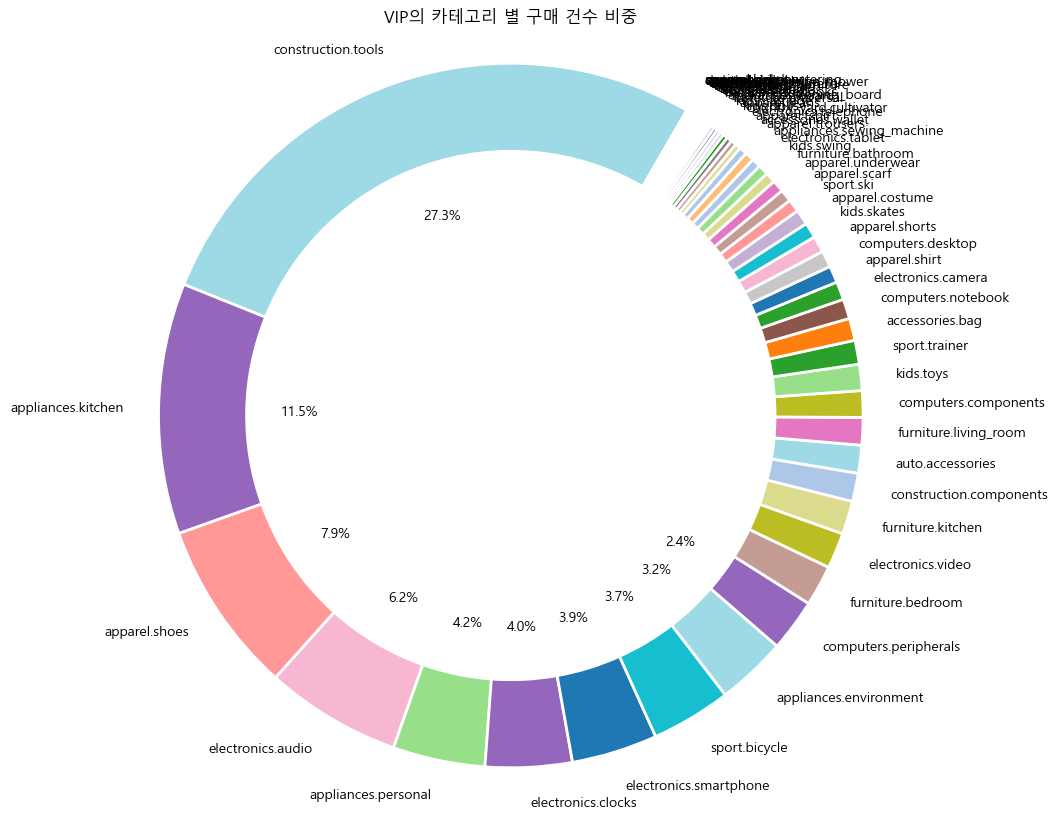

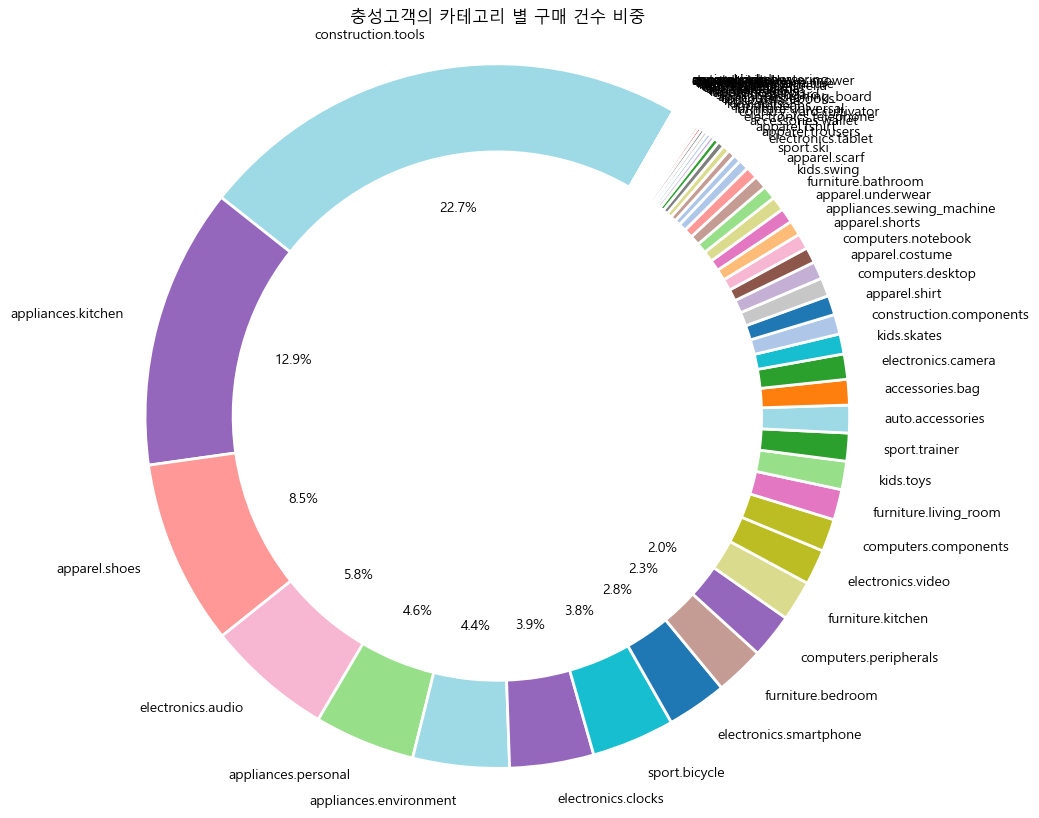

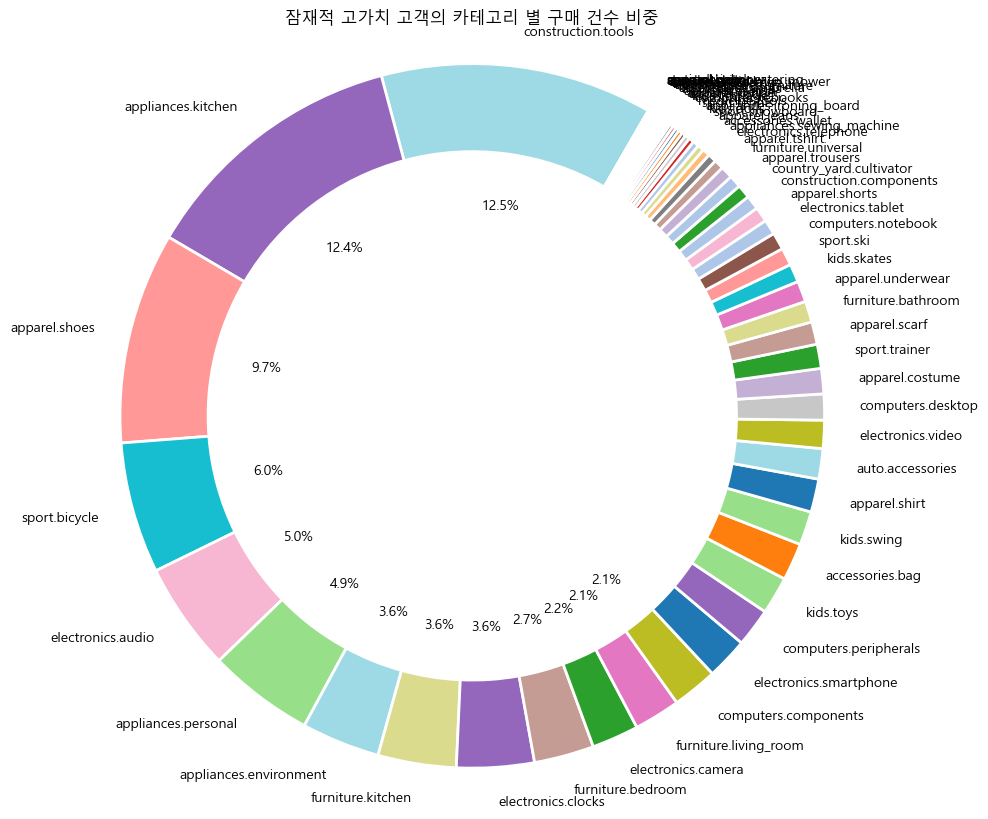

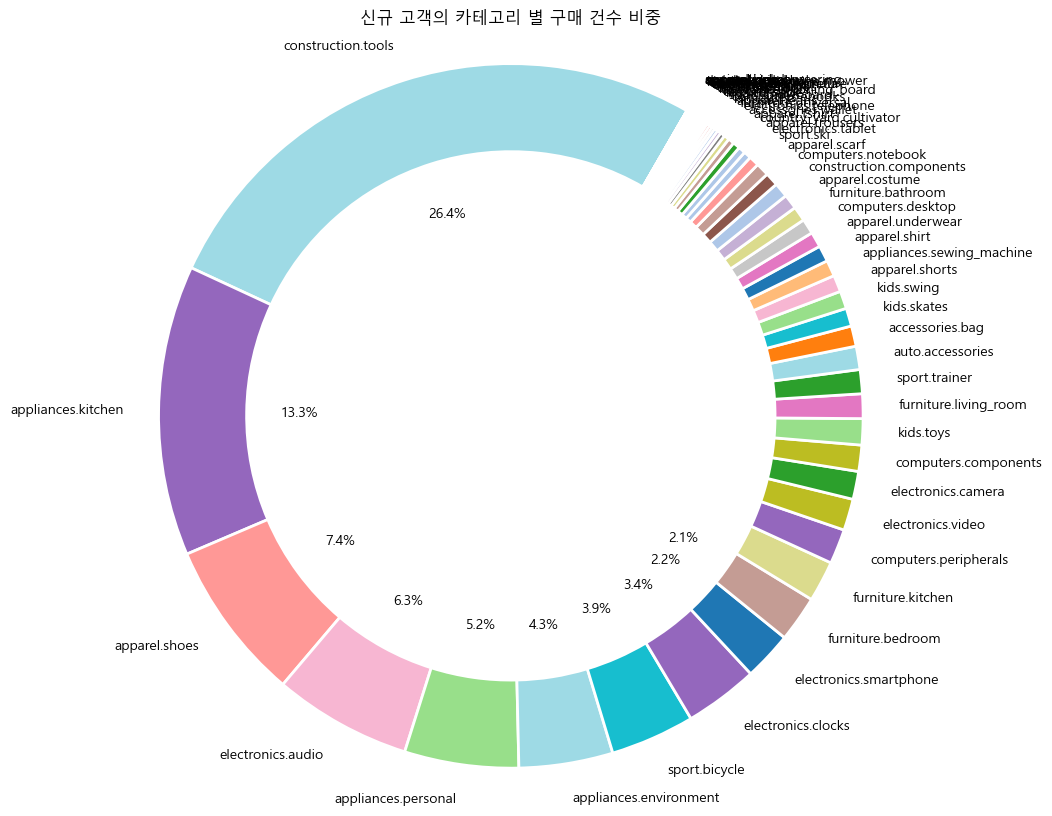

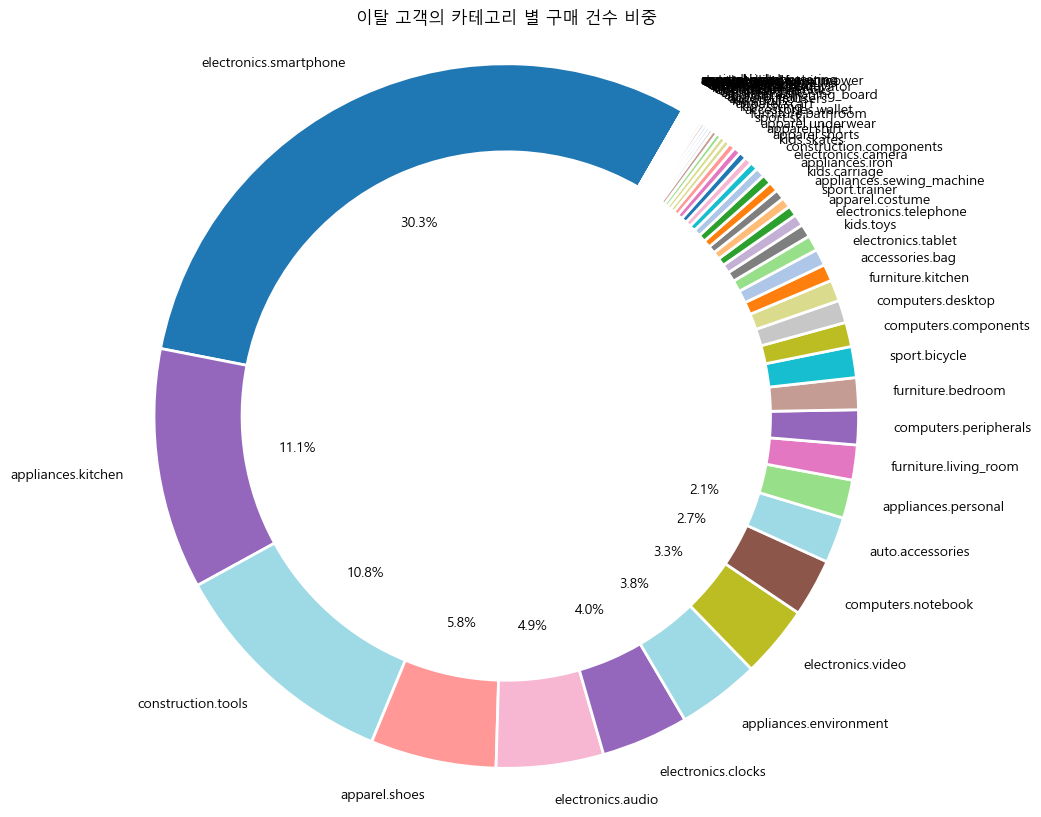

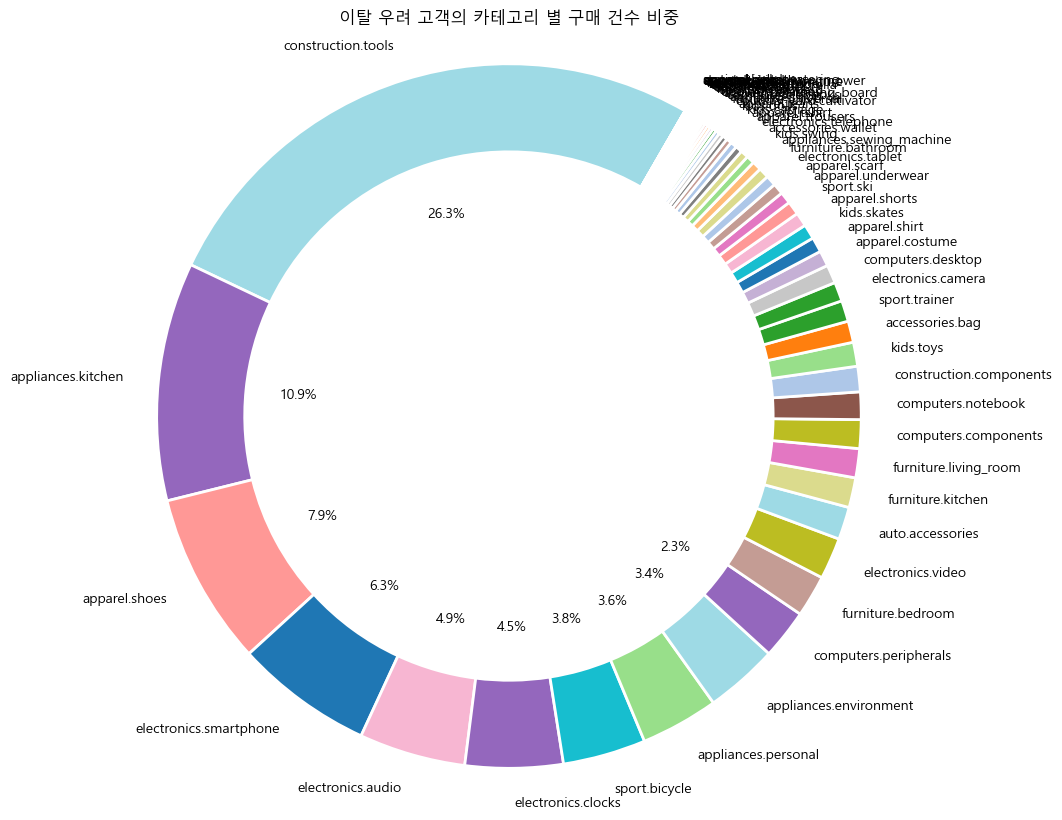

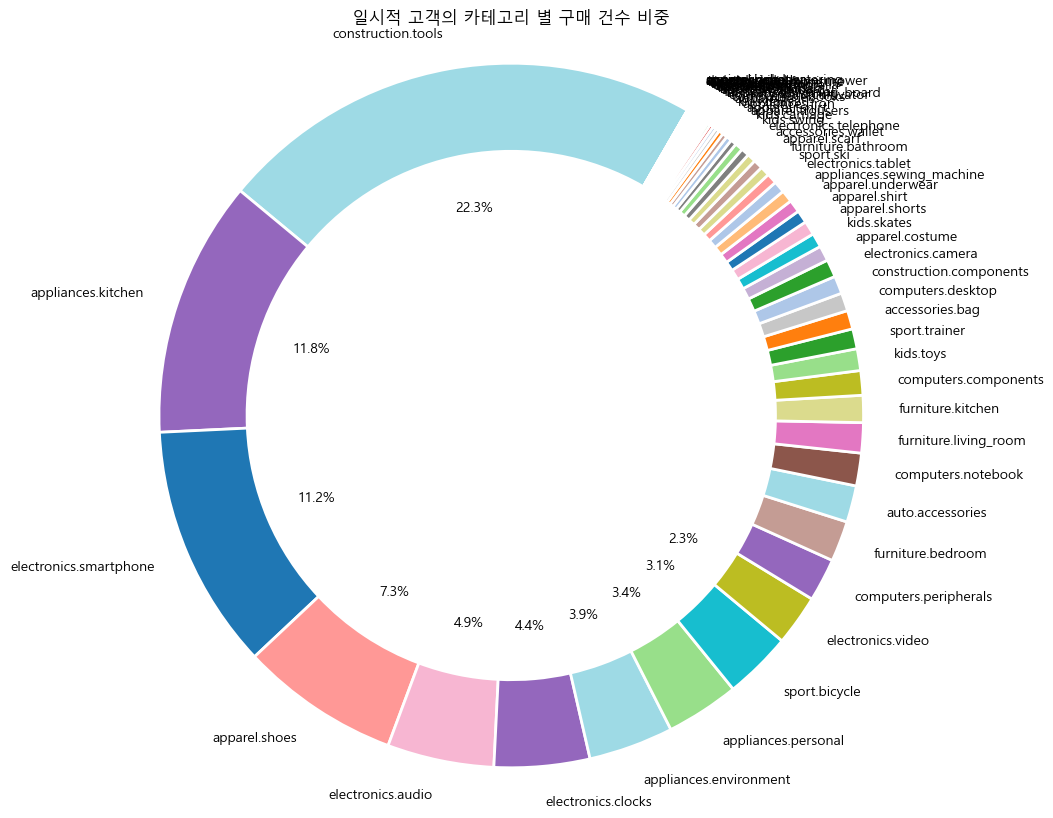

In [133]:
# 1. 전체 code에 대한 고정 색상 매핑 생성
unique_codes = df_rfm_category['code'].unique()
color_palette = plt.cm.tab20.colors  # 색상 팔레트 확장
color_mapping = {code: color_palette[i % len(color_palette)] for i, code in enumerate(unique_codes)}

for x in rfm_group_list:
    visual_df = df_rfm_category[df_rfm_category['rfm_group'] == x]
    visual_category_per_rfm = visual_df.groupby('code')['cnt'].sum()
    visual_category_per_rfm.sort_values(ascending=False, inplace=True)
    total_sales = visual_category_per_rfm.sum()
    sales_percentage = (visual_category_per_rfm / total_sales) * 100
        
    # 색상 매핑 적용
    pie_colors = [color_mapping[code] for code in visual_category_per_rfm.index]
    
    plt.figure(figsize=(10, 10))
    plt.pie(sales_percentage, 
            labels=sales_percentage.index, 
            autopct=lambda p: '{:.1f}%'.format(p) if p > 2 else '', 
            startangle=60, 
            wedgeprops={'width': 0.25, 'edgecolor': 'w', 'linewidth': 2}, 
            colors=pie_colors)
    plt.title(f'{x}의 카테고리 별 구매 건수 비중')
    plt.axis('equal')
    plt.show()

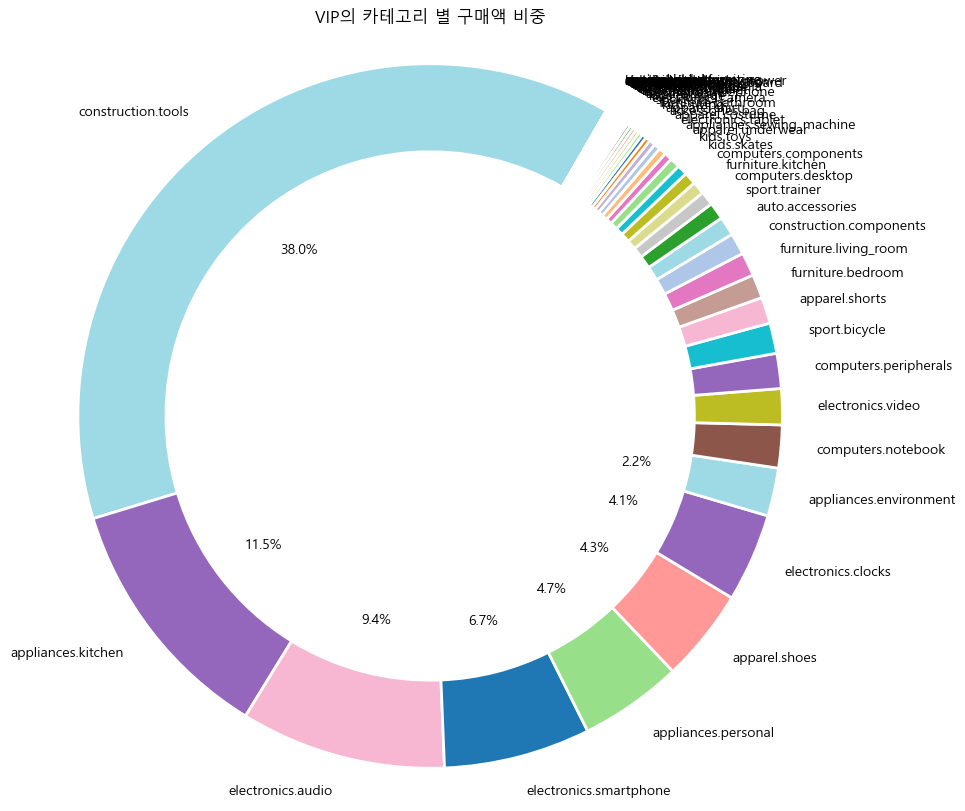

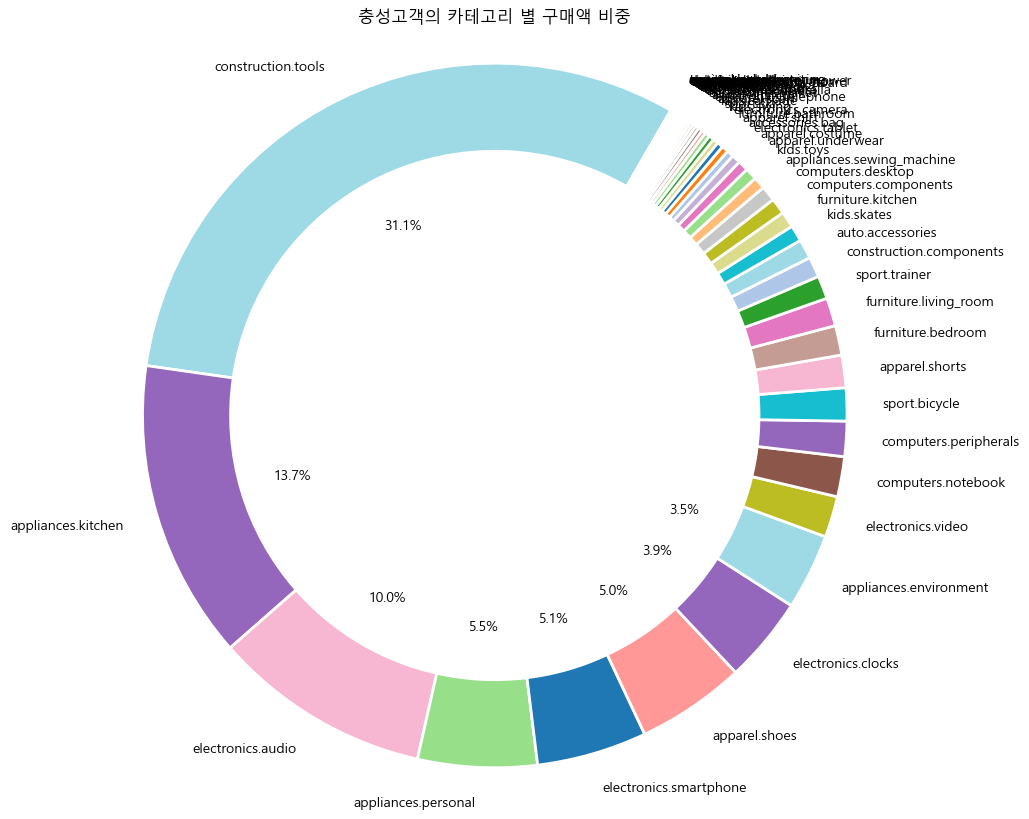

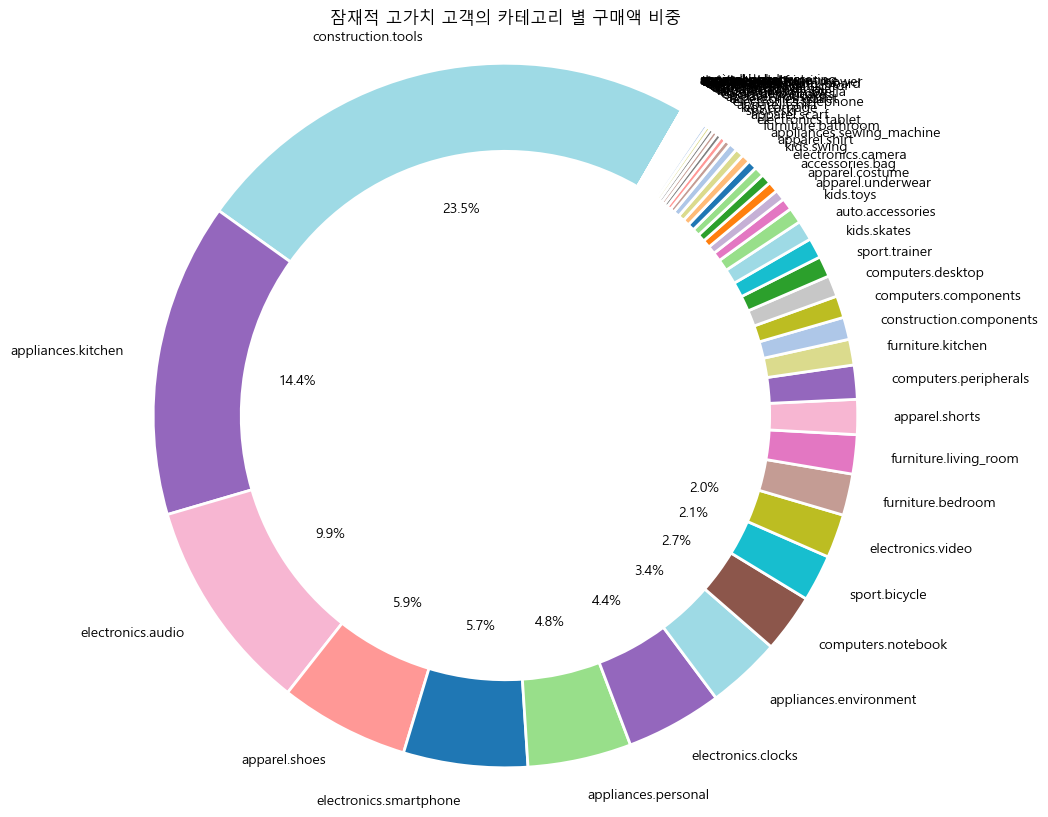

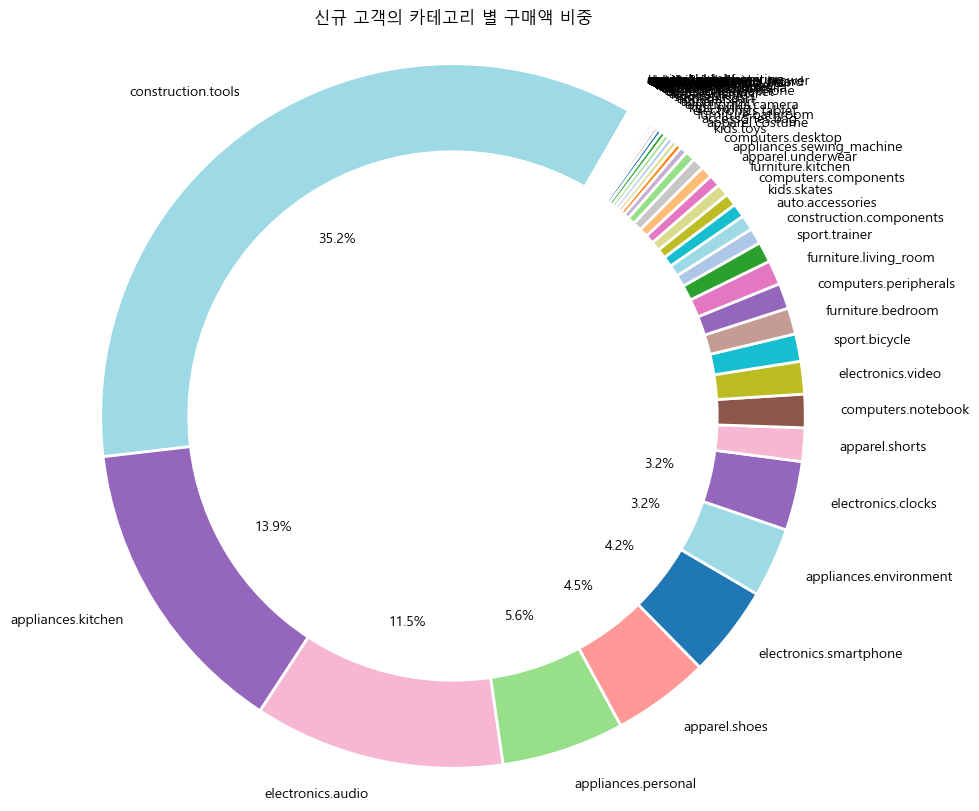

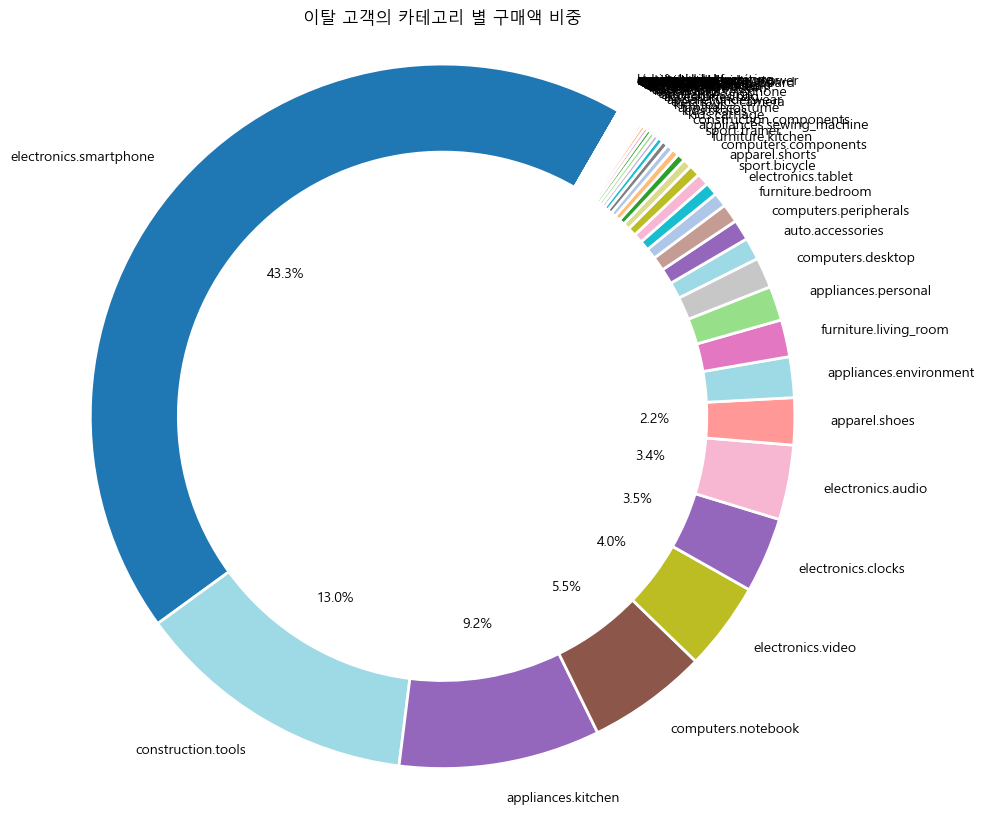

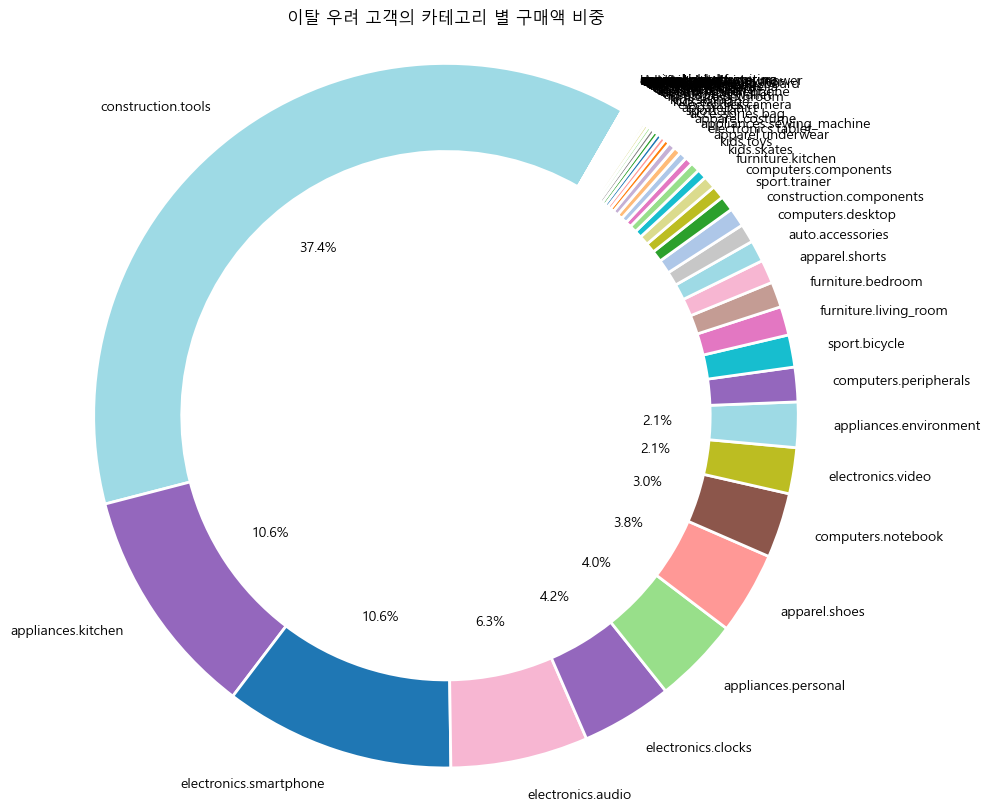

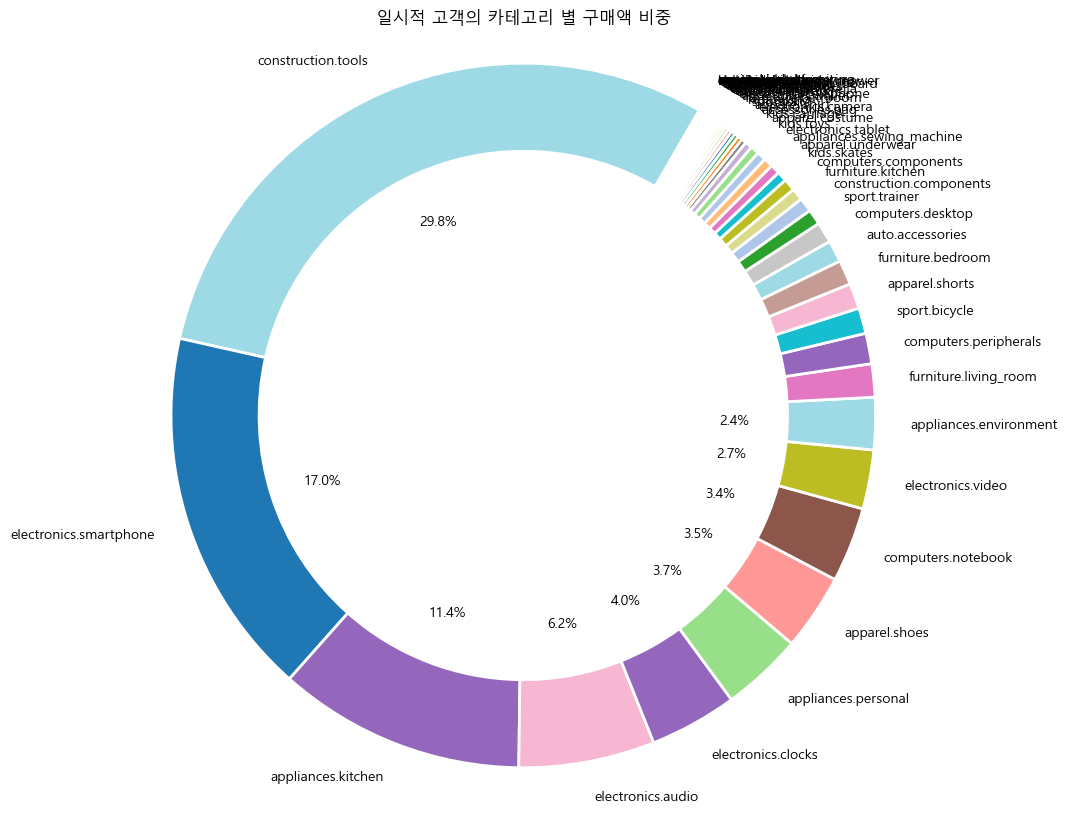

In [134]:
# 1. 전체 code에 대한 고정 색상 매핑 생성
unique_codes = df_rfm_category['code'].unique()
color_palette = plt.cm.tab20.colors  # 색상 팔레트 확장
color_mapping = {code: color_palette[i % len(color_palette)] for i, code in enumerate(unique_codes)}

for x in rfm_group_list:
    visual_df = df_rfm_category[df_rfm_category['rfm_group'] == x]
    visual_category_per_rfm = visual_df.groupby('code')['total_price'].sum()
    visual_category_per_rfm.sort_values(ascending=False, inplace=True)
    total_sales = visual_category_per_rfm.sum()
    sales_percentage = (visual_category_per_rfm / total_sales) * 100
        
    # 색상 매핑 적용
    pie_colors = [color_mapping[code] for code in visual_category_per_rfm.index]
    
    plt.figure(figsize=(10, 10))
    plt.pie(sales_percentage, 
            labels=sales_percentage.index, 
            autopct=lambda p: '{:.1f}%'.format(p) if p > 2 else '', 
            startangle=60, 
            wedgeprops={'width': 0.25, 'edgecolor': 'w', 'linewidth': 2}, 
            colors=pie_colors)
    plt.title(f'{x}의 카테고리 별 구매액 비중')
    plt.axis('equal')
    plt.show()

#### K-MEANS (PASS)

In [10]:
df_kmean = df_rfm2[['Recency_score','Frequency_score','Monetary_score']]

In [11]:
# pca 이용하여 차원 축소 (14차원 -> 2차원)
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
reduced_df = pca.fit_transform(df_kmean)
reduced_df.shape

(2064899, 2)

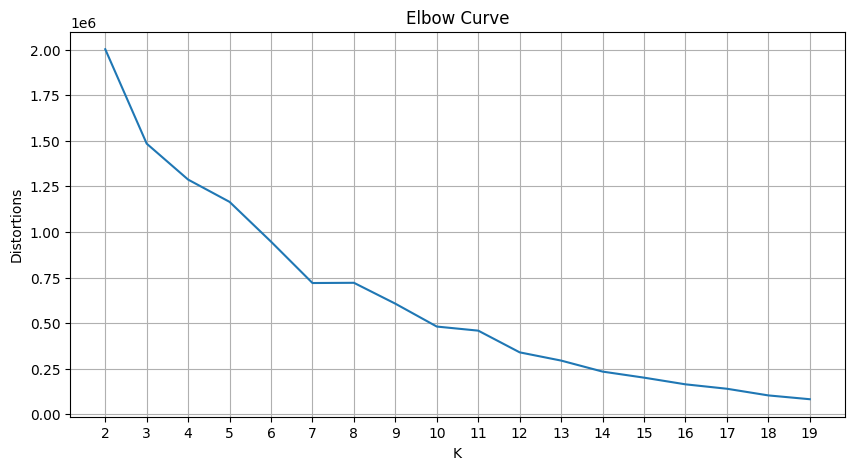

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
distortions = []
for k in range(2,20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_kmean)
    distortions.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(10,5))
plt.plot(range(2,20), distortions)
plt.grid(True)
plt.xticks(np.arange(2,20))
plt.xlabel('K')
plt.ylabel('Distortions')
plt.title("Elbow Curve")
plt.show()

In [52]:
from sklearn.metrics import silhouette_score

def visualize_silhouette_layer(data, param_init='random', param_n_init=10, param_max_iter=300):
    clusters_range = range(3,16)
    results = []
    for i in clusters_range:
        clusterer = KMeans(n_clusters=i, init='k-means++')
        cluster_labels = clusterer.fit_predict(data)
        silhouette_avg = silhouette_score(data, cluster_labels)
        results.append([i, silhouette_avg])

    result = pd.DataFrame(results, columns=["n_clusters", "silhouette_score"])
    pivot_km = pd.pivot_table(result, index="n_clusters", values="silhouette_score")

    plt.figure()
    sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm._rocket_lut)
    plt.tight_layout()
    plt.show()

In [ ]:
reduced_df = pd.DataFrame(reduced_df)
visualize_silhouette_layer(reduced_df)

C:\Users\JINWOO\AppData\Roaming\Python\Python310\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


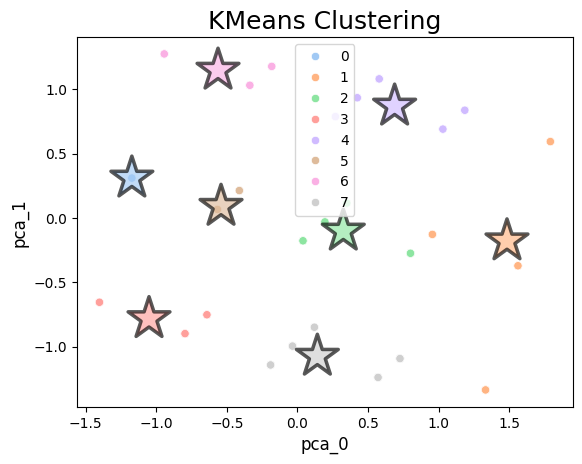

In [17]:
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

reduced_df = pd.DataFrame(reduced_df)

km = KMeans(n_clusters=8, init ='k-means++')

cluster = km.fit(reduced_df)
cluster_id = pd.DataFrame(cluster.labels_)

d1 = pd.concat([reduced_df, cluster_id], axis=1)
d1.columns = [0, 1, "cluster"]

cluster_df = pd.DataFrame(index = [0,1,2,3,4,5,6,7], data = km.cluster_centers_, columns=['x','y'])

sns.scatterplot(x=d1[0], y=d1[1], hue = d1['cluster'], palette="pastel")
plt.legend()
sns.scatterplot(x=km.cluster_centers_[:, 0], y=km.cluster_centers_[:, 1], hue =cluster_df.index, palette="pastel",s=1000, marker="*", edgecolor='black',label = 'Centroids',legend=False, alpha=0.65)
plt.title("KMeans Clustering", size = 18)
plt.xlabel('pca_0', size=12)
plt.ylabel('pca_1', size=12)
plt.show()

# print('Silhouette Coefficient: {:.4f}'.format(silhouette_score(d1.iloc[:,:-1], d1['cluster'])))


In [21]:
df_kmean = df_rfm2[['Recency','Frequency','Monetary']]

In [20]:
from sklearn.preprocessing import MinMaxScaler
# MinMaxScaler 객체를 생성합니다.
minmax_scaler = MinMaxScaler()

In [22]:
df_kmean_minmax = minmax_scaler.fit_transform(df_kmean)

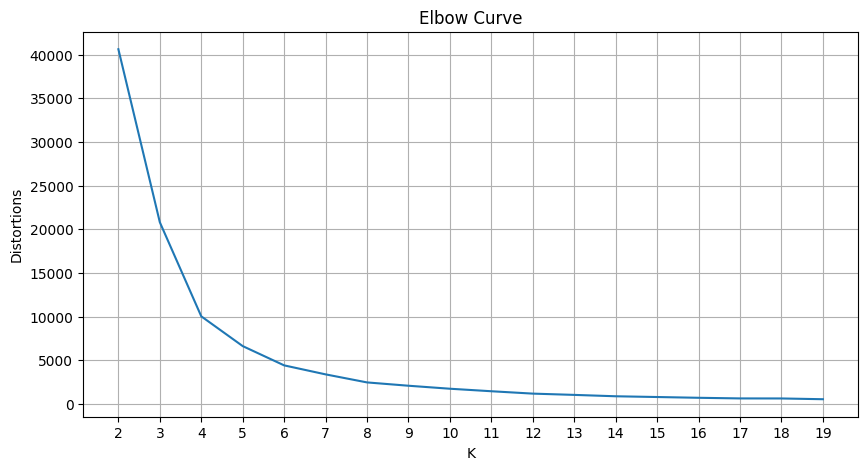

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
distortions = []
for k in range(2,20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_kmean_minmax)
    distortions.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(10,5))
plt.plot(range(2,20), distortions)
plt.grid(True)
plt.xticks(np.arange(2,20))
plt.xlabel('K')
plt.ylabel('Distortions')
plt.title("Elbow Curve")
plt.show()

In [43]:
from sklearn.preprocessing import RobustScaler
# RobustScaler 객체를 생성합니다.
robustScaler = RobustScaler()

In [44]:
df_kmean_minmax = robustScaler.fit_transform(df_kmean)

In [45]:
df_kmean_minmax = pd.DataFrame(df_kmean_minmax, 
                            index=df_kmean.index, 
                            columns=df_kmean.columns)

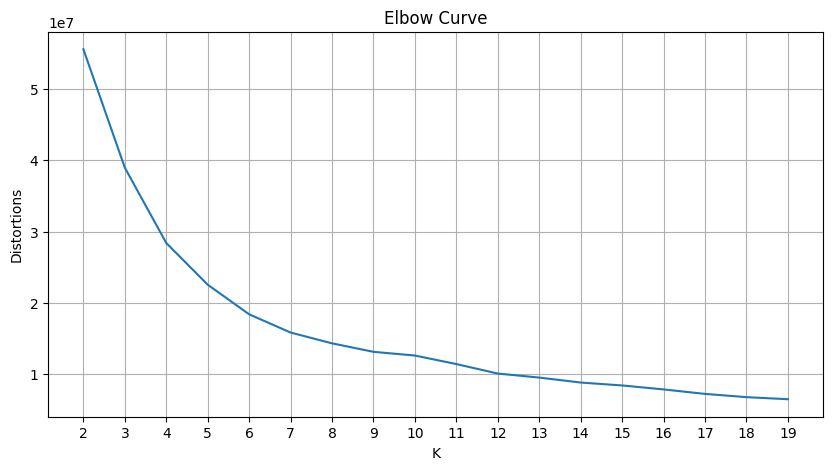

In [50]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
distortions = []
for k in range(2,20):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(df_kmean_minmax)
    distortions.append(kmeans.inertia_)
    
fig = plt.figure(figsize=(10,5))
plt.plot(range(2,20), distortions)
plt.grid(True)
plt.xticks(np.arange(2,20))
plt.xlabel('K')
plt.ylabel('Distortions')
plt.title("Elbow Curve")
plt.show()

In [51]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=12, init ='k-means++')

cluster = km.fit(df_kmean_minmax)
cluster_id = pd.DataFrame(cluster.labels_)

d1 = pd.concat([df_kmean_minmax, cluster_id], axis=1)

In [52]:
d1.columns = ['Recency_score','Frequency_score','Monetary_score', "cluster"]

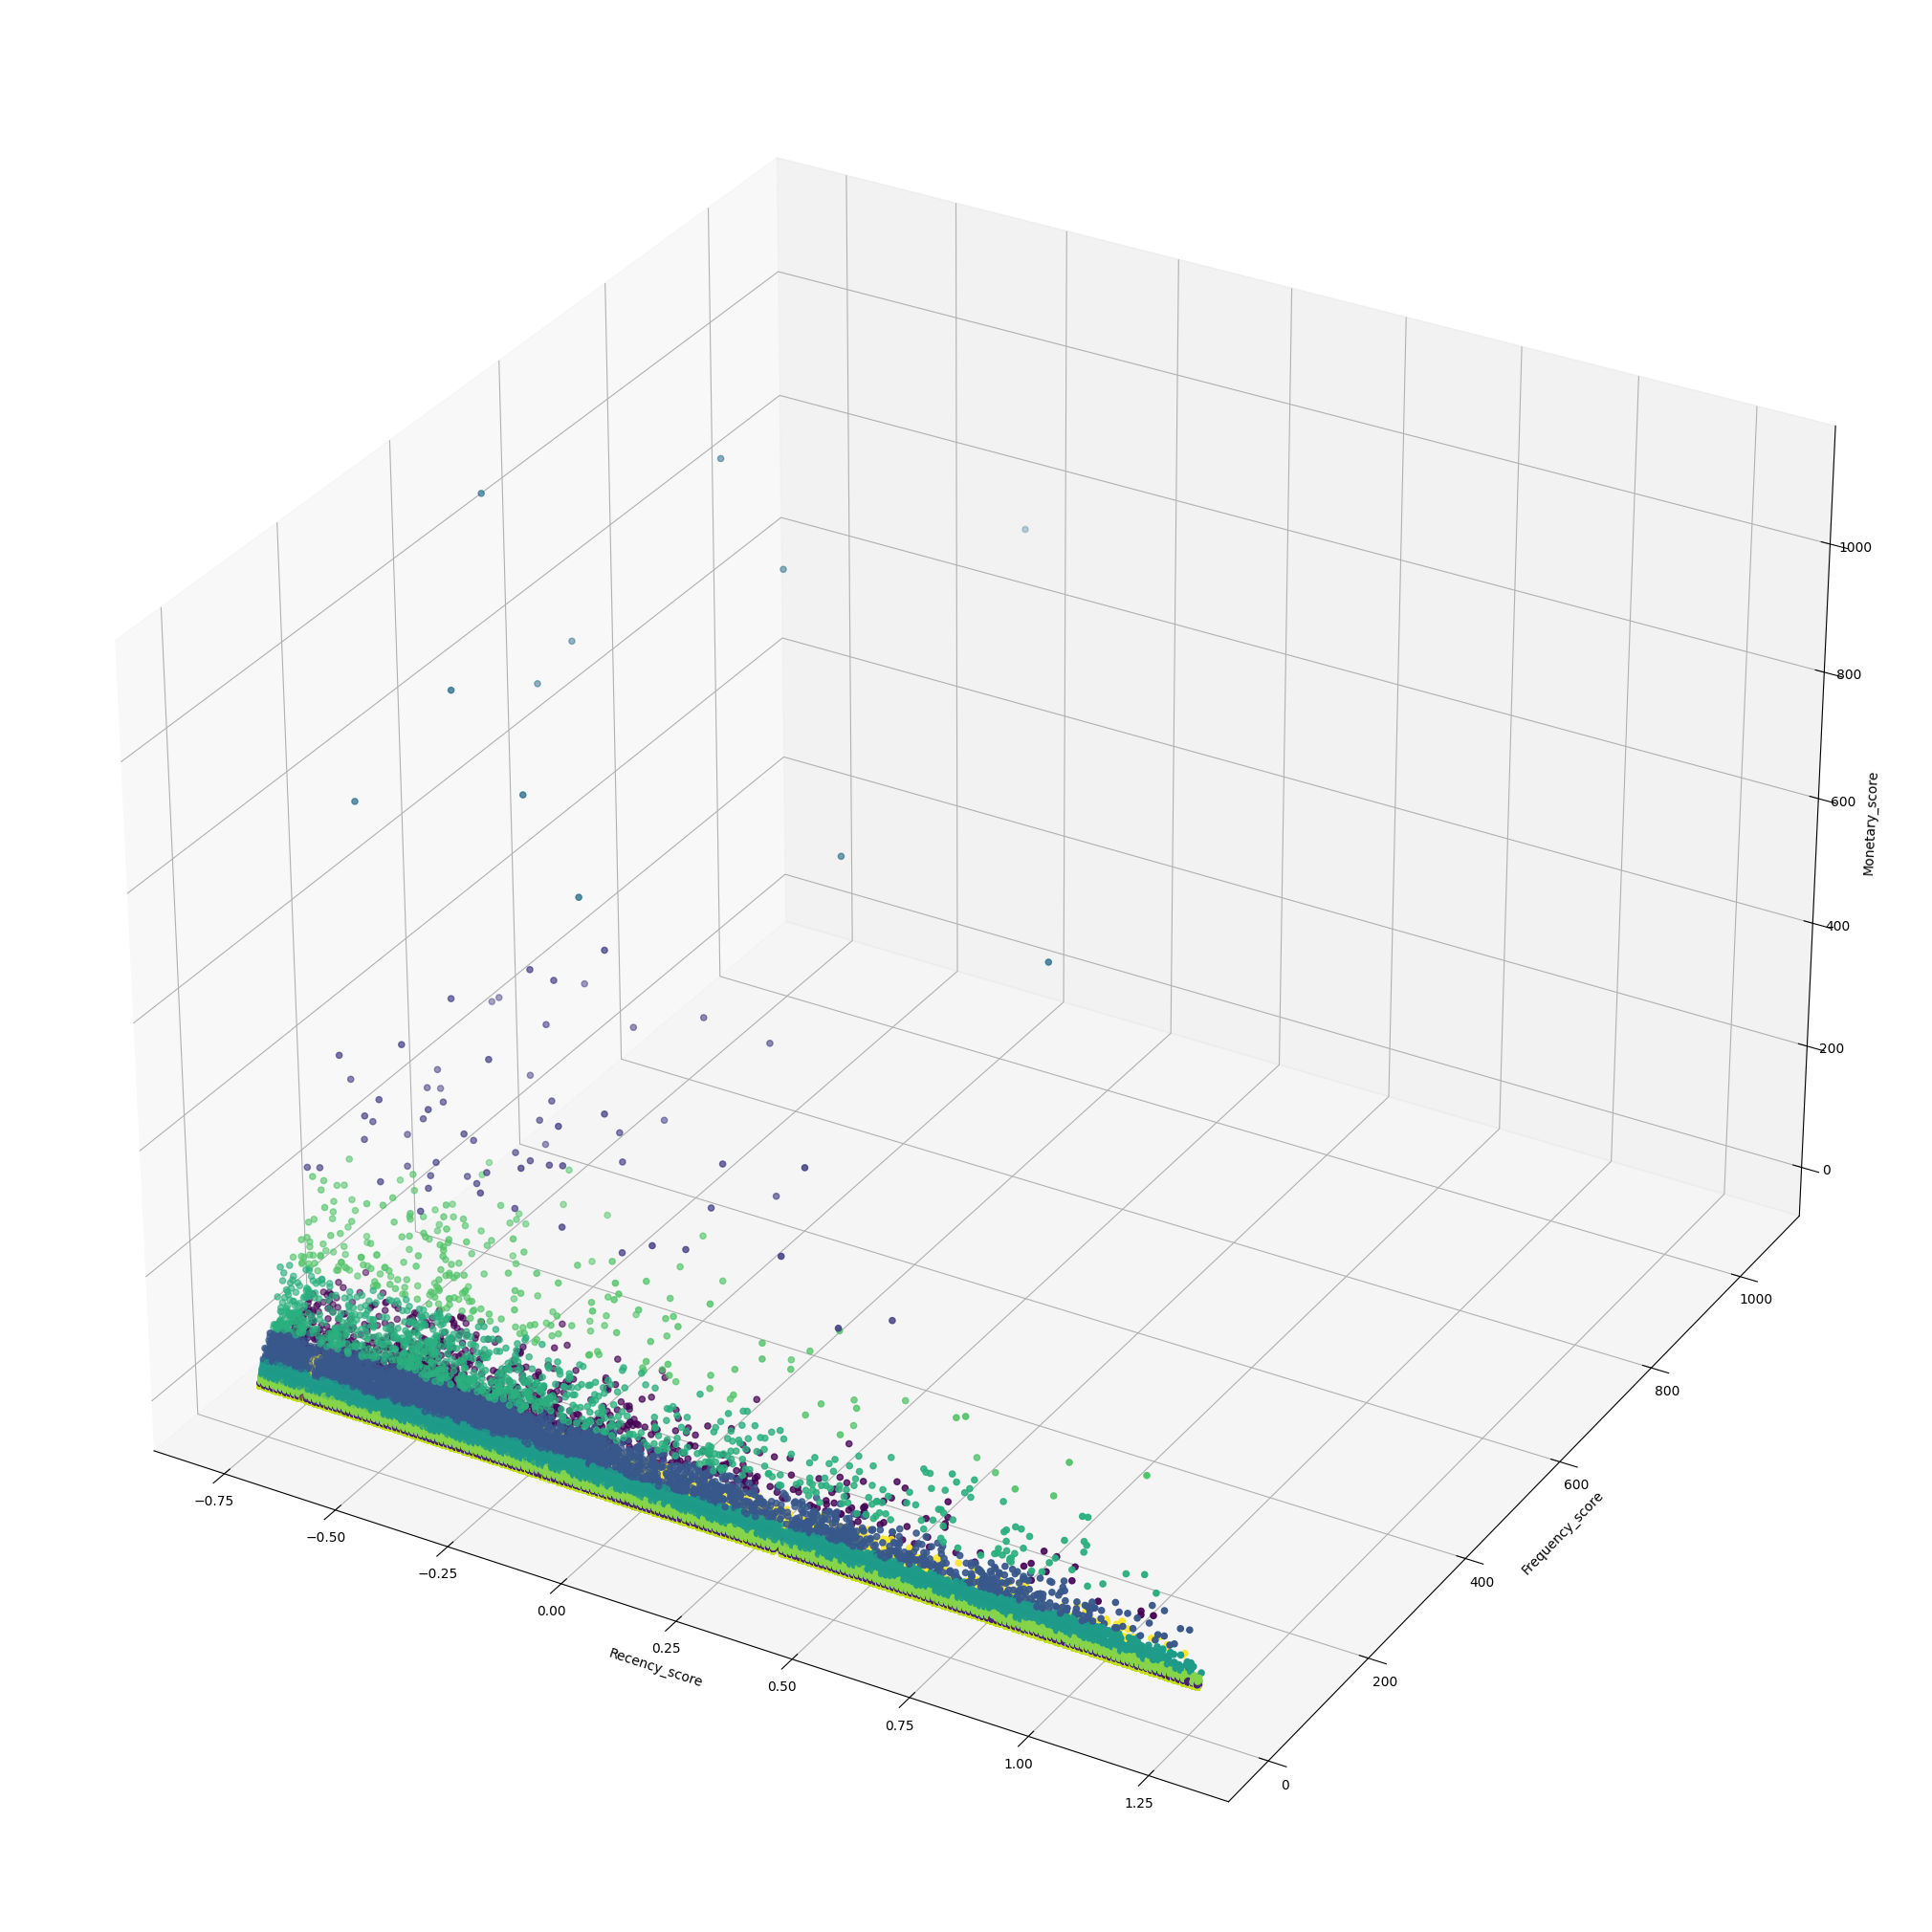

In [53]:
# 패키지 불러오기
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# 3D 그래프 공간 설정
fig = plt.figure(figsize=(20,20))
ax = Axes3D(fig)
fig.add_axes(ax)

# 그래프 그리기
ax.scatter(data=d1, xs='Recency_score', ys='Frequency_score', zs='Monetary_score', c='cluster')
ax.set_xlabel('Recency_score',  rotation=150)
ax.set_ylabel('Frequency_score')
ax.set_zlabel('Monetary_score',  rotation=60)

plt.show()

### RobustScaler를 이용한 점수

In [ ]:

# robustScaler = RobustScaler()
# # fit_transform()을 사용해서 학습과 스케일링을 한 번에 적용합니다.
# X_train_robust = robustScaler.fit_transform(train_X_num)
# # robust 스케일링이 완료된 데이터를 데이터프레임 형태로 변환합니다.
# train_robust = pd.DataFrame(X_train_robust, 
#                             index=train_X_num.index, 
#                             columns=train_X_num.columns)

## 4) 구매율 높은 기간에 카테고리 분석 (기간 : 11.8~11.15)

In [164]:
high_category_main1 = spark.sql("""
                            SELECT DISTINCT SUBSTRING_INDEX(category_code, '.', 2) AS category,
                            COUNT(*) AS purchase_cnt 
                            FROM ecommerce 
                            WHERE event_type = 'purchase' 
                                AND event_time BETWEEN '2019-10-14' AND '2019-10-21'
                            GROUP BY category
                            ORDER BY purchase_cnt DESC
                        """)


In [174]:
df_high_category_main1 = high_category_main1.toPandas()

In [178]:
df_high_category_main1

category  purchase_cnt
0      electronics.smartphone         89334
1                        None         41799
2          appliances.kitchen         13128
3           electronics.audio          8960
4           electronics.video          5921
5      appliances.environment          4875
6          electronics.clocks          4767
7          computers.notebook          4091
8               apparel.shoes          2112
9          construction.tools          2065
10           auto.accessories          1994
11         electronics.tablet          1433
12      computers.peripherals          1384
13            appliances.iron           995
14      electronics.telephone           972
15          computers.desktop           832
16       computers.components           817
17        appliances.personal           661
18      furniture.living_room           606
19          furniture.bedroom           511
20  appliances.sewing_machine           508
21              kids.carriage           458
22          furniture.kitchen           416
23            accessories.bag           314
24                  kids.toys           303
25              sport.bicycle           214
26                kids.skates           192
27            apparel.costume           191
28                  kids.fmcg           189
29   appliances.ironing_board           176
30         electronics.camera           164
31                 kids.dolls            88
32                 kids.swing            87
33         accessories.wallet            86
34             medicine.tools            82
35           computers.ebooks            81
36              sport.trainer            79
37         furniture.bathroom            76
38    construction.components            60
39              apparel.jeans            31
40        stationery.cartrige            29
41          apparel.underwear            21
42    country_yard.lawn_mower            15
43               apparel.sock            12
44              apparel.shirt            10
45             apparel.tshirt             9
46           apparel.trousers             6
47        furniture.universal             6
48               apparel.belt             6
49    country_yard.cultivator             6
50              apparel.scarf             4
51              apparel.skirt             3
52               sport.tennis             2
53       accessories.umbrella             2
54             apparel.jacket             1
55              apparel.dress             1
56                  sport.ski             1

In [166]:
high_category_main2 = spark.sql("""
                            SELECT DISTINCT SUBSTRING_INDEX(category_code, '.', 2) AS category,
                            COUNT(*) AS purchase_cnt 
                            FROM ecommerce 
                            WHERE event_type = 'purchase' 
                                AND event_time BETWEEN '2019-11-11' AND '2019-11-18'
                            GROUP BY category
                            ORDER BY purchase_cnt DESC
                        """)

In [176]:
df_high_category_main2 = high_category_main2.toPandas()

In [177]:
df_high_category_main2

category  purchase_cnt
0      electronics.smartphone        119193
1                        None         72393
2          appliances.kitchen         25788
3           electronics.audio         15772
4           electronics.video         12048
5      appliances.environment         10578
6          electronics.clocks          8444
7          computers.notebook          6866
8               apparel.shoes          4100
9            auto.accessories          3912
10         construction.tools          3154
11      computers.peripherals          2202
12      furniture.living_room          2156
13         electronics.tablet          2136
14       computers.components          2062
15            appliances.iron          1877
16          computers.desktop          1468
17          furniture.bedroom          1368
18  appliances.sewing_machine          1340
19          furniture.kitchen          1152
20      electronics.telephone          1103
21        appliances.personal           947
22              kids.carriage           935
23            accessories.bag           575
24                  kids.toys           374
25   appliances.ironing_board           350
26            apparel.costume           303
27              sport.trainer           271
28         electronics.camera           254
29              sport.bicycle           219
30           computers.ebooks           205
31                 kids.swing           180
32                  kids.fmcg           161
33         furniture.bathroom           152
34    construction.components           144
35                kids.skates           135
36                 kids.dolls           122
37             medicine.tools           116
38         accessories.wallet           107
39            sport.snowboard            94
40              apparel.jeans            56
41              apparel.shirt            52
42        stationery.cartrige            42
43              apparel.dress            39
44                  sport.ski            38
45          apparel.underwear            35
46             apparel.tshirt            34
47             apparel.jumper            29
48           apparel.trousers            25
49    country_yard.lawn_mower            24
50               sport.tennis            17
51               apparel.belt            16
52        furniture.universal            15
53    country_yard.cultivator             9
54       accessories.umbrella             8
55              apparel.scarf             6
56              apparel.skirt             5
57               apparel.sock             3
58              apparel.glove             2
59     country_yard.furniture             1

# 4. REVENUE(수익화)
    - LTV(Life Time Value, 고객 생애 가치)
        사용자당 평균 월간 수익(ARPU) 기반 계산법: LTV = ARPU × 평균 구독 기간
            ARPU: 사용자당 (월간) 평균 구독 매출
        이탈률(Churn Rate) 기반 계산법: LTV = ARPU / 이탈률(Churn Rate)
            이탈률: 전체 고객 중 구독을 취소한 고객의 비율
    - LTR
    - CAC = 총 획득 비용 / 획득한 신규 고객 수
        
    - PU(Paying User, 결제 유저)
    - ARPU(Average Revenue Per User, 유저 당 평균 수익)
    - ARPDAU 데일리
    - ARPWAU 위클리
    - ARPPU (Average Revenue Per Paying User, 결제 유저 당 평균 수익)

ARPU

​

  Average Revenue Per User의 약자로 가입 유저 당 얻는 수입을 의미한다.

​

  즉, 총 매출액을 가입 유저의 수로 나누는 것을 말하며 

​

  LTV는 전체 기간을 기준으로 하고 ARPU는 특정 기간을 기준으로 한다는 점에서 차이가 있다.

​

  ARPU의 경우 보통 단독으로 사용하는 것보다 ARPPU 또는 ARPDAU와 함께 사용하는 경우가 많이 있는데

​

  ARPPU의 경우 총 매출액을 유료 결제를 한 유저의 수로 나누는 것을 의미하고

​

  ARPDAU의 경우 총 매출액을 활성 유조의 수로 나누는 것을 의미한다.

​

  ARPU를 ARPPU, ARPDAU와 비교할 경우 휴면 고객 활성화, 유료 결제 촉진 등 ARPU를 개선할 수 있는 구체적인 전략이 제시될 수 있다.

## 1) ARPDAU
ARPDAU = 일일 수익 ÷ 일일 액티브 유저

In [169]:
ARPDAU = spark.sql("""
                SELECT 
                   DATE(event_time) AS DATE, SUM(price)/COUNT(DISTINCT user_id) AS ARPDAU
                FROM ecommerce
                WHERE event_type = 'purchase'
                GROUP BY DATE
                        """)

In [179]:
df_ARPDAU = ARPDAU.toPandas()

## 2) ARPWAU

In [181]:
ARPWAU = spark.sql("""
                SELECT 
                   DATE(DATE_TRUNC('week',event_time)) AS WEEK, 
                   SUM(price)/COUNT(DISTINCT user_id) AS ARPWAU
                FROM ecommerce
                WHERE event_type = 'purchase'
                GROUP BY WEEK
                        """)

In [182]:
df_ARPWAU = ARPWAU.toPandas()

In [189]:
df_ARPWAU

WEEK       ARPWAU
0   2019-11-18   498.971317
1   2020-03-09   569.968598
2   2019-09-30   525.016662
3   2020-04-13   417.935071
4   2020-04-06   450.251722
5   2019-12-23   539.166032
6   2020-04-20   367.970748
7   2019-12-16   566.106684
8   2019-10-14   553.673838
9   2019-11-11   529.723183
10  2019-10-21   518.724422
11  2020-03-02   576.499816
12  2020-01-13   593.220165
13  2019-10-28   511.448061
14  2020-03-30   504.144968
15  2020-04-27   376.384580
16  2020-01-06   557.168790
17  2020-02-10  1198.758633
18  2019-12-30   519.646764
19  2020-02-24   558.121276
20  2020-01-27   544.649904
21  2020-03-16   591.552356
22  2019-11-25   500.542660
23  2020-03-23   543.374950
24  2019-11-04   483.295697
25  2020-02-17   685.867846
26  2020-01-20   582.443075
27  2019-10-07   493.704884
28  2019-12-02   518.403168
29  2019-12-09   522.742269
30  2020-02-03   558.721659

## 3) ARPU(Average Revenue Per User, 유저 당 평균 수익)

In [8]:
ARPU = spark.sql("""
                 WITH revenue AS (
                     SELECT MONTH(event_time) AS MONTH , SUM(price) AS price
                     FROM ecommerce
                     WHERE event_type = 'purchase'
                     GROUP BY MONTH
                 ), user AS (
                     SELECT MONTH(event_time) AS MONTH , COUNT(DISTINCT user_id) AS cnt
                     FROM ecommerce
                     GROUP BY MONTH
                 )
                  SELECT r.MONTH, r.price / u.cnt AS ARPU
                  FROM revenue r
                  LEFT JOIN user u
                  ON r.MONTH = u.MONTH
                 """)

In [184]:
df_ARPU = ARPU.toPandas()

In [188]:
df_ARPU

MONTH       ARPU
0     12  75.594361
1      1  59.145621
2     11  74.420661
3     10  76.040544
4      4  54.255739
5      5  19.848517
6      2  90.006804
7      3  78.105928

## 4) ARPPU(Average Revenue Per Paying User, 결제 유저 당 평균 수익)

In [185]:
ARPPU = spark.sql("""SELECT MONTH(event_time) AS MONTH, SUM(price) / COUNT(DISTINCT user_id) AS arpu 
                    FROM ecommerce
                    WHERE event_type = 'purchase'
                    GROUP BY MONTH
                 """)


In [186]:
df_ARPPU = ARPPU.toPandas()

In [187]:
df_ARPPU

MONTH        arpu
0     12  687.670659
1      1  725.941013
2      3  709.437393
3      5  330.793640
4      4  504.546963
5     10  661.540842
6     11  623.026443
7      2  971.366732

In [ ]:
df_ARPPU['MONTH'] = df_ARPPU['MONTH'].astype(str)
month_order = ['10','11','12','1','2','3','4']
df_ARPPU.set_index('MONTH', inplace=True)
sales_df_month = df_ARPPU.reindex(month_order)


In [ ]:
fig, ax1 = plt.subplots()

color_1 = 'mediumaquamarine'
ax1.bar(month_order, sales_df_month.total_sales_amount, color=color_1, alpha = 0.8)
ax1.set_title("Sales Amount and Price by Month")
ax1.set_xlabel('Month')
ax1.set_ylabel('Sales Amount', color = color_1)
# ax1.plot(sales_df.index, sales_df.total_sales_amount, marker='s', color=color_1)
# ax1.set_ylim(900000,1500000)
ax1.tick_params(axis='y', labelcolor=color_1)

ax2 = ax1.twinx()
color_2 = 'tab:red'
color_2 = 'firebrick'

ax2.set_xlabel('Day of Week')
ax2.set_ylabel('Sales Price', color = color_2, alpha = 0.6)
ax2.plot(month_order, sales_df_month.total_sales_price, marker='s', color=color_2)
ax2.set_ylim(0,400000000)
ax2.tick_params(axis='y', labelcolor=color_2)

fig.tight_layout()
plt.show()

## 5) LTR(Life Time Revenue, 고객 생애 매출)

In [190]:
total_revenue = spark.sql("""
                            SELECT SUM(price) AS total_price
                        FROM ecommerce
                        WHERE event_type = 'purchase'
""")

In [191]:
df_total_revenue = total_revenue.toPandas()
df_total_revenue

total_price
0  2.057447e+09

In [192]:
total_revenue_per_month = spark.sql("""
                            SELECT MONTH(event_time) AS MONTH, SUM(price) AS total_price
                        FROM ecommerce
                        WHERE event_type = 'purchase'
                        GROUP BY MONTH
""")

In [193]:
df_total_revenue_per_month = total_revenue_per_month.toPandas()
df_total_revenue_per_month

MONTH   total_price
0     12  3.453503e+08
1      1  2.594804e+08
2     11  2.746562e+08
3     10  2.283970e+08
4      4  2.438016e+08
5      5  2.484260e+06
6      2  3.817335e+08
7      3  3.215440e+08

In [231]:
df_total_revenue_per_month.sum()

MONTH          4.800000e+01
total_price    2.057447e+09
dtype: float64

In [14]:
revenue_by_week = spark.sql("""

                                SELECT 
                                    DATE(DATE_TRUNC('week',event_time)) AS week,
                                    FLOOR(SUM(price),2) AS total
                                FROM ecommerce 
                                WHERE event_type = 'purchase'
                                GROUP BY week
                                ORDER BY week
                          """)

In [15]:
revenue_by_week_df = revenue_by_week.toPandas()
revenue_by_week_df

week         total
0   2019-09-30   39909666.57
1   2019-10-07   49520080.96
2   2019-10-14   60315566.88
3   2019-10-21   52370936.37
4   2019-10-28   46222629.92
5   2019-11-04   50749431.23
6   2019-11-11   97058530.25
7   2019-11-18   61287149.91
8   2019-11-25   53878912.45
9   2019-12-02   54110922.72
10  2019-12-09   55558616.53
11  2019-12-16  104465364.76
12  2019-12-23   93551237.41
13  2019-12-30   54957841.80
14  2020-01-06   58650929.80
15  2020-01-13   67029726.08
16  2020-01-20   65053649.47
17  2020-01-27   62279082.53
18  2020-02-03   60088279.49
19  2020-02-10  169964793.99
20  2020-02-17   81115532.54
21  2020-02-24   59410335.44
22  2020-03-02   99765022.68
23  2020-03-09   83844090.63
24  2020-03-16   61106175.25
25  2020-03-23   55353062.80
26  2020-03-30   53560361.37
27  2020-04-06   52633075.54
28  2020-04-13   66833251.01
29  2020-04-20   46253555.06
30  2020-04-27   40549416.29

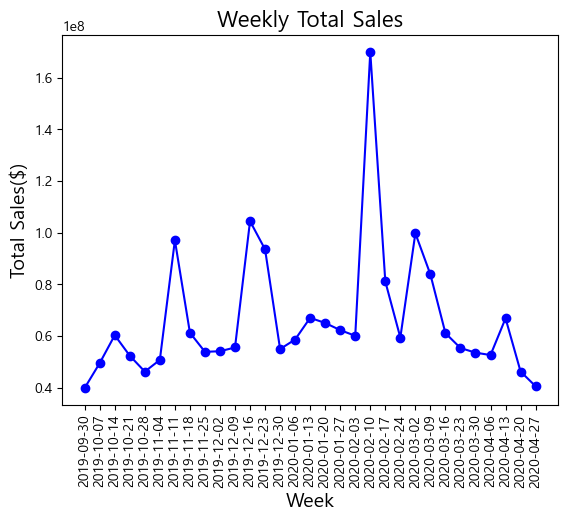

In [197]:
import matplotlib.pyplot as plt

plt.plot(revenue_by_week_df['week'], revenue_by_week_df['total'],
         marker='o', linestyle='-', color='b', label='Total Sales')

plt.title('Weekly Total Sales', fontsize=16)
plt.xlabel('Week', fontsize=14)
plt.ylabel('Total Sales($)', fontsize=14)
plt.xticks(revenue_by_week_df['week'], rotation=90, fontsize=10)

plt.show()

In [206]:
feb_item_list = spark.sql("""
                            SELECT DISTINCT SUBSTRING_INDEX(category_code, '.', 2) AS category,

                            COUNT(*) AS purchase_cnt,
                            SUM(price) AS price
                            FROM ecommerce 
                            WHERE event_type = 'purchase' 
                                AND event_time BETWEEN '2020-02-10' AND '2020-02-17'
                            GROUP BY category
                            ORDER BY purchase_cnt DESC
                        """)


In [207]:
df_feb_item_list = feb_item_list.toPandas()

In [208]:
df_feb_item_list

category  purchase_cnt         price
0        construction.tools        262909  1.199016e+08
1             sport.bicycle         32651  4.518714e+06
2        appliances.kitchen         32480  8.485658e+06
3             apparel.shoes         28088  4.020946e+06
4                      None         23433  2.895682e+06
..                      ...           ...           ...
58  country_yard.lawn_mower            57  2.285630e+03
59             sport.diving            13  1.355500e+03
60          appliances.iron            13  1.539540e+03
61           apparel.jacket            10  9.612000e+01
62            apparel.dress             7  1.259600e+02

[63 rows x 3 columns]

In [203]:
feb_item_list_sobunryu = spark.sql("""
                            SELECT category_code AS category,
                            category_id,
                            COUNT(*) AS purchase_cnt,
                            SUM(price) AS price
                            FROM ecommerce 
                            WHERE event_type = 'purchase' 
                                AND event_time BETWEEN '2020-02-10' AND '2020-02-17'
                            GROUP BY category, category_id
                            ORDER BY purchase_cnt DESC
                        """)


In [215]:
df_feb_item_list_sobunryu = feb_item_list_sobunryu.toPandas()

In [216]:
df_feb_item_list_sobunryu.sort_values(by=['price'],ascending=False)

category          category_id  purchase_cnt  \
0        construction.tools.light  2232732093077520756        256639   
4     electronics.audio.headphone  2053013554658804075         12182   
2    appliances.personal.massager  2232732099754852875         13884   
1                   sport.bicycle  2232732079706079299         31496   
3              electronics.clocks  2232732103101907535         12891   
..                            ...                  ...           ...   
731                  sport.tennis  2053013557544485393             2   
719     furniture.universal.light  2232732092700033384             2   
751             apparel.underwear  2053013555883540911             1   
741  construction.tools.generator  2053013560178508465             1   
748            apparel.shoes.keds  2053013558836331105             1   

            price  
0    1.192175e+08  
4    6.829503e+06  
2    5.428951e+06  
1    4.435533e+06  
3    4.139744e+06  
..            ...  
731  5.760000e+00  
719  5.400000e+00  
751  4.380000e+00  
741  3.840000e+00  
748  9.000000e-01  

[766 rows x 4 columns]

In [209]:
feb_item_list_sobunryu0203 = spark.sql("""
                            SELECT category_code AS category,
                            category_id,
                            COUNT(*) AS purchase_cnt,
                            SUM(price) AS price
                            FROM ecommerce 
                            WHERE event_type = 'purchase' 
                                AND event_time BETWEEN '2020-02-03' AND '2020-02-10'
                            GROUP BY category, category_id
                            ORDER BY purchase_cnt DESC
                        """)


In [211]:
df_feb_item_list_sobunryu0203 = feb_item_list_sobunryu0203.toPandas()

In [214]:
df_feb_item_list_sobunryu0203.sort_values(by=['price'],ascending=False)

category          category_id  purchase_cnt  \
0        construction.tools.light  2232732093077520756         95457   
3     electronics.audio.headphone  2053013554658804075          4305   
2    appliances.personal.massager  2232732099754852875          4986   
1                   sport.bicycle  2232732079706079299         10151   
4              electronics.clocks  2232732103101907535          3597   
..                            ...                  ...           ...   
778                 sport.trainer  2053013555942261171             1   
784  appliances.personal.massager  2053013553635393833             1   
731                          None  2134904816839688395             1   
698      furniture.bedroom.pillow  2069241396576911678             2   
753                apparel.jacket  2059484387635888645             1   

           price  
0    41709511.92  
3     2334494.81  
2     1884627.43  
1     1298088.69  
4     1155454.71  
..           ...  
778         3.32  
784         2.83  
731         1.65  
698         1.58  
753         1.54  

[799 rows x 4 columns]

In [217]:
item_list_sobunryu = spark.sql("""
                            SELECT category_code AS category,
                            category_id,
                            COUNT(*) AS purchase_cnt,
                            SUM(price) AS price
                            FROM ecommerce 
                            WHERE event_type = 'purchase' 
                            GROUP BY category, category_id
                            ORDER BY purchase_cnt DESC
                        """)


In [218]:
item_list_sobunryu.toPandas()

category          category_id  purchase_cnt  \
0         construction.tools.light  2232732093077520756       2300492   
1           electronics.smartphone  2053013555631882655        733673   
2                    sport.bicycle  2232732079706079299        249666   
3      electronics.audio.headphone  2053013554658804075        207189   
4     appliances.personal.massager  2232732099754852875        158689   
...                            ...                  ...           ...   
1459       furniture.kitchen.table  2232732085267726525             1   
1460                          None  2193508829692429007             1   
1461                  apparel.sock  2184976688121643656             1   
1462                          None  2221851497447031037             1   
1463     furniture.universal.light  2232732092624535910             1   

             price  
0     9.907566e+08  
1     3.394914e+08  
2     3.229777e+07  
3     8.362337e+07  
4     6.344711e+07  
...            ...  
1459  7.709000e+01  
1460  1.947000e+01  
1461  6.690000e+00  
1462  1.799000e+01  
1463  3.090100e+02  

[1464 rows x 4 columns]

In [220]:
cohort = spark.sql("""WITH first as (
                                    SELECT user_id, MIN(event_time) AS first_interaction_time
                                    FROM ecommerce
                                    GROUP BY user_id
                                )

                                SELECT MONTH(first_interaction_time) AS MONTH, 
                                COUNT(DISTINCT user_id) as user_cnt
          FROM first
          GROUP BY MONTH
          """)

In [223]:
df_cohort = cohort.toPandas()

In [225]:
df_cohort['MONTH'] = df_cohort['MONTH'].astype(str)
month_order = ['10','11','12','1','2','3','4']
df_cohort.set_index('MONTH', inplace=True)
df_cohort = df_cohort.reindex(month_order)


In [229]:
df_cohort.sum()

user_cnt    15619023
dtype: int64

In [230]:
df_cohort

user_cnt
MONTH          
10      3003621
11      2294808
12      2534092
1       2152155
2       1841332
3       1692773
4       2100242

## 6) LTV(Life Time Value, 고객 생애 가치)

In [251]:
ltr = spark.sql("""
                    WITH first AS (
                        SELECT user_id, MIN(event_time) AS first_interaction_time
                        FROM ecommerce
                        GROUP BY user_id
                        HAVING  DATE_FORMAT(first_interaction_time, 'yyyy-MM') = '2019-11'
                    ),

                    pay AS (
                        SELECT user_id AS pay_user, event_time, price 
                        FROM ecommerce
                        WHERE event_type = 'purchase'
                    ),

                    summary AS (
                        SELECT MONTH(first_interaction_time) AS Month, 
                        COUNT(DISTINCT f.user_id) AS ActiveUser,
                        COUNT(DISTINCT pay_user) AS PayingUser,
                        ROUND(SUM(e.price),0) AS Amount
                        FROM ecommerce e
                        JOIN first f 
                        ON e.user_id = f.user_id
                        LEFT JOIN pay p 
                        ON f.user_id = p.pay_user
                        GROUP BY Month
                    )

                    SELECT *, 
                        ROUND(Amount / FIRST(ActiveUser) OVER (), 2) AS AmountPerFirstActiveUser
                    FROM summary


                """)

In [ ]:
ltr = spark.sql("""
                    WITH october_users AS (
                        SELECT user_id, MIN(event_time) AS first_join
                        FROM ecommerce
                        WHERE MONTH(event_time) = 10
                        GROUP BY user_id
                    ),

                    activity_summary AS (
                        SELECT MONTH(s.event_time) AS Month,
                                COUNT(DISTINCT s.user_id) AS ActiveUser,
                                COUNT(DISTINCT CASE WHEN s.event_type ='purchase' THEN s.user_id END) AS PayingUser,
                                SUM(DISTINCT CASE WHEN s.event_type = 'purchase' THEN s.price END) AS PayingAmount
                        FROM ecommerce s INNER JOIN october_users o
                        ON s.user_id = o.user_id
                        WHERE WHERE s.event_time >= m.first_join
                        GROUP BY Month
                    )

                    SELECT Month, ActiveUser, PayingUser, PayingAmount,
                            PayingAmount / FIRST(ActiveUser) OVER () AS AmountPerFirstActiveUser
                    FROM activity_summary 
                    ORDER BY Month
                """)

In [252]:
df_ltr = ltr.toPandas()

In [254]:
df_ltr['Month'] = df_ltr['Month'].astype(str)
month_order = ['10','11','12','1','2','3','4']
df_ltr.set_index('Month', inplace=True)
df_ltr = df_ltr.reindex(month_order)


In [250]:
# 10월
df_ltr

ActiveUser  PayingUser  PayingAmount  AmountPerFirstActiveUser
Month                                                                
10        3003621      345250    9472517.07                  7.819092
11        1395783      241617    7947595.11                  6.560345
12        1211460      219878    7482888.16                  6.176752
1          975110      126956   10790347.34                  8.906895
2          887524      127272    7082602.59                  5.846336
3          789249      135927    5908110.71                  4.876852
4          714511      112560    6334194.64                  5.228563

In [255]:
# 11월
df_ltr

ActiveUser  PayingUser        Amount  AmountPerFirstActiveUser
Month                                                                
10            NaN         NaN           NaN                       NaN
11      2294808.0    382393.0  1.095579e+11                  47741.63
12            NaN         NaN           NaN                       NaN
1             NaN         NaN           NaN                       NaN
2             NaN         NaN           NaN                       NaN
3             NaN         NaN           NaN                       NaN
4             NaN         NaN           NaN                       NaN

In [9]:
def calculate_ltr(m):
    query = f"""
                    WITH month_users AS (
                        SELECT user_id, MIN(event_time) AS first_join
                        FROM ecommerce
                        GROUP BY user_id
                        HAVING MONTH(first_join) = {m}
                    ),

                    activity_summary AS (
                        SELECT DATE_FORMAT(event_time, 'yyyy-MM') AS Month,
                                COUNT(DISTINCT s.user_id) AS ActiveUser,
                                COUNT(DISTINCT CASE WHEN s.event_type ='purchase' THEN s.user_id END) AS PayingUser,
                                SUM(DISTINCT CASE WHEN s.event_type = 'purchase' THEN s.price END) AS PayingAmount
                        FROM ecommerce s INNER JOIN month_users m
                        ON s.user_id = m.user_id
                        GROUP BY Month
                    )

                    SELECT Month, ActiveUser, PayingUser, PayingAmount,
                            ROUND(PayingAmount / FIRST(ActiveUser) OVER (),2)  AS AmountPerFirstActiveUser
                    FROM activity_summary 
                    ORDER BY Month
                """
    return spark.sql(query)


In [10]:

months = ['10', '11', '12', '1', '2', '3', '4']
ltrsstr = {}

for month in months:
    globals()[f"ltrstr{month}_df"] = calculate_ltr(month).toPandas()
    ltrsstr[month] = globals()[f"ltrstr{month}_df"].AmountPerFirstActiveUser.sum()

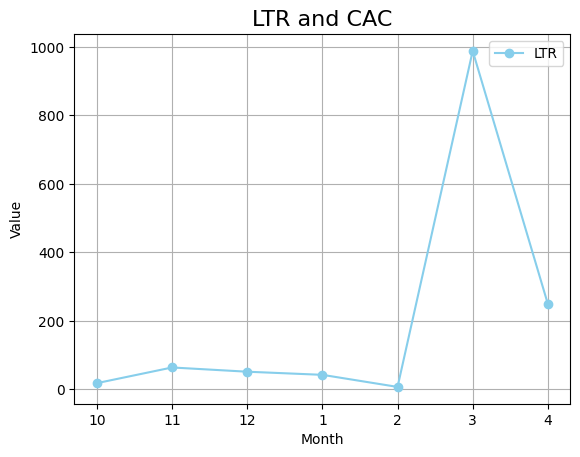

In [12]:
# 시각화 
import matplotlib.pyplot as plt

x = list(ltrsstr.keys())
y = list(ltrsstr.values())

plt.plot(x, y, marker='o', color='skyblue', label="LTR")
plt.title("LTR and CAC", fontsize=16)
plt.xlabel("Month")
plt.ylabel('Value')
plt.xticks(x)
plt.grid(True)
plt.legend()
plt.show()

In [11]:
ltrsstr

{'10': np.float64(18.4),
 '11': np.float64(64.12),
 '12': np.float64(51.730000000000004),
 '1': np.float64(42.61),
 '2': np.float64(7.329999999999999),
 '3': np.float64(988.25),
 '4': np.float64(249.53)}

## 7) 재구매율

In [20]:
rr = spark.sql("""
               WITH rr AS (
                    SELECT user_id, COUNT(*) AS CNT
                    FROM ecommerce
                    WHERE event_type = 'purchase'
                    GROUP BY user_id
                    )
               SELECT (SELECT COUNT(*) FROM rr WHERE CNT > 1) / COUNT(*)
               FROM rr
                """)

In [21]:
rr.toPandas()

(scalarsubquery() / count(1))
0                       0.524133

In [32]:
spark_rfm_df = spark.read.option("encoding", "UTF-8").csv('RFM_GROUP.csv', header=True)
spark_rfm_df.createOrReplaceTempView("rfm_tb")

In [33]:
rfm_repurchase = spark.sql("""
                            WITH first_purchase AS (
                                SELECT user_id, MIN(event_time) AS first_purchase_date
                                FROM ecommerce 
                                WHERE event_type = 'purchase'
                                GROUP BY user_id
                                
                            ),
                            
                            -- 재구매 유저 찾기
                            repurchase AS (
                                SELECT s.user_id, first_purchase_date,
                                      MIN(event_time) AS re_purchase_date
                                FROM ecommerce s JOIN first_purchase f 
                                ON s.user_id = f.user_id
                                WHERE event_type = 'purchase' 
                                  AND event_time > first_purchase_date
                                GROUP BY s.user_id, first_purchase_date 
                            ),
                            
                            -- 재구매 유저랑 RFM Group 결합
                            rfm_repurchase AS (
                                SELECT r.user_id, r.rfm_group,
                                      CASE WHEN r.user_id IN (SELECT user_id FROM repurchase)
                                            THEN 1 ELSE 0 END AS repurchase_flag
                                FROM rfm_tb r LEFT JOIN first_purchase f 
                                ON r.user_id = f.user_id
                            )
                            
                            -- 재구매한 RFM Group별 count
                            SELECT rfm_group, 
                                  COUNT(DISTINCT user_id) AS total_users, 
                                  SUM(repurchase_flag) AS repurchase_users, 
                                  FLOOR(SUM(repurchase_flag) * 1.0 / COUNT(DISTINCT user_id), 3) AS repurchase_rate
                            FROM rfm_repurchase
                            GROUP BY rfm_group
                            ORDER BY repurchase_rate DESC;

                          """)


In [34]:
rfm_repurchase.toPandas()

rfm_group  total_users  repurchase_users repurchase_rate
0         VIP        95588             95588           1.000
1        충성고객       173403            173402           0.999
2  잠재적 고가치 고객        34842             34827           0.999
3       이탈 고객       192733            192721           0.999
4    이탈 우려 고객       585715            565036           0.964
5      일시적 고객       762866                 0           0.000
6       신규 고객       219752                 0           0.000

In [35]:
# 그룹별 코호트별 리텐션(재구매율)
rfm_retention = spark.sql("""
                            WITH first_purchase AS (
                                SELECT user_id, 
                                        MIN(event_time) AS first_purchase_date
                                FROM ecommerce 
                                GROUP BY user_id
                            ),

                            cohort AS (
                                SELECT DATE(DATE_TRUNC('week', first_purchase_date)) AS cohort_week,
                                        rfm_group,
                                        FLOOR(DATEDIFF(event_time, first_purchase_date) / 7) AS week_num, 
                                        COUNT(DISTINCT s.user_id) AS user_cnt
                                FROM ecommerce s LEFT JOIN first_purchase f 
                                ON s.user_id = f.user_id
                                LEFT JOIN rfm_tb r 
                                ON s.user_id = r.user_id
                                WHERE event_type = 'purchase' 
                                GROUP BY cohort_week, rfm_group, week_num
                                ORDER BY cohort_week, rfm_group, week_num
                            )

                            SELECT * FROM cohort

                          """)

In [36]:
rfm_retention.toPandas()

cohort_week   rfm_group  week_num  user_cnt
0     2019-09-30         VIP         0      5378
1     2019-09-30         VIP         1      3381
2     2019-09-30         VIP         2      3096
3     2019-09-30         VIP         3      2673
4     2019-09-30         VIP         4      2662
...          ...         ...       ...       ...
2447  2020-04-20        충성고객         1       788
2448  2020-04-27         VIP         0       527
2449  2020-04-27       신규 고객         0     13040
2450  2020-04-27  잠재적 고가치 고객         0       805
2451  2020-04-27        충성고객         0      3693

[2452 rows x 4 columns]

In [ ]:
# pdf = df[df['event_type'] == 'purchase'] # purchase 데이터 추출
# for x in rfm_group_list:
#     tempdf = pdf[pdf['rfm_group'] == x] # rfm 그룹 별 데이터 프레임 생성
#     print(f"{x} 그룹의 재구매율 : {len(tempdf[tempdf[]])/len(tempdf)}") # rfm 그룹 별 (재구매한 고객수 / 전체 고객수)

# SPARK STOP

In [16]:
spark.stop()